
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

import numpy as np

In [ ]:
!nvidia-smi

Wed Jun 24 20:23:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    59W / 149W |  10873MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Set Arguments**

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [ ]:
from torchvision.datasets import VisionDataset

from PIL import Image
import random

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    

    
class Caltech(VisionDataset):

    
    
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)
        
        self.data = {}
        self.labels = []
        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        f = open(root.split("/")[0]+"/"+split+".txt","r")
        rl = f.readlines()
        for l in rl:
            l = l.replace("\n","")
            if l.startswith("BACKGROUND"):
                continue
            else:
                img = pil_loader(root+"/"+l)
                label = l.split("/")[0]
                
                self.data[len(self.data)] = [img,self.__map__(label)]
        f.close()
        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''
        
    def __map__(self,label):
        if label in self.labels:
            return self.labels.index(label)
        else:
            self.labels.append(label)
            return self.labels.index(label)
    
    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''
        try:
            image, label = self.data[index] # Provide a way to access image and label via index
                           # Image should be a PIL Image
                           # label can be int
        except IndexError:
            parent = ""
            return "error at index: "+index,label
            

        # Applies preprocessing when accessing the image
        if self.transform is not None and type(image) is not torch.Tensor:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.data) # Provide a way to get the length (number of elements) of the dataset
        return length

    def __indexes_split__(self,train_perc = 0.5):
        if(train_perc == 1):
            indexes = self.data.keys()
            labels = list( label for [img,label] in self.data.values())
            return list(zip(indexes,labels)),[]
        dataview = {}
        for key, val in self.data.items(): #{index,[img,label]}
            dataview[val[1]] = dataview.get(val[1],[]) + [key] 
        train_indexes = []
        val_indexes = []
        last_train = True
        for label in dataview.keys():
            tmp = dataview[label]
            split_index = int(len(tmp)*train_perc)
            if len(tmp) % 2 != 0:
                if last_train:
                    split_index += 1
                last_train = not last_train
            random.shuffle(tmp)
            train_indexes.extend(tmp[:split_index])
            val_indexes.extend(tmp[-(len(tmp)-split_index):])
        return train_indexes,val_indexes

    def __get_distribution__(self):
        dataview = {}
        for key, val in self.data.items(): #{index,[img,label]}
            label = self.labels[val[1]]
            dataview[label] = dataview.get(label,0) + 1 
        return dataview.keys(),dataview.values()


    def __augment__(self, aug_transform):
        augmented_data = {}
        it = 0
        for img,label in self.data.values():
            augmented_data[it] = [img,label]
            it += 1
            augmented_data[len(self.data)+it] = [aug_transform(img),label]
        self.data = augmented_data

dict_keys(['accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'Motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball'

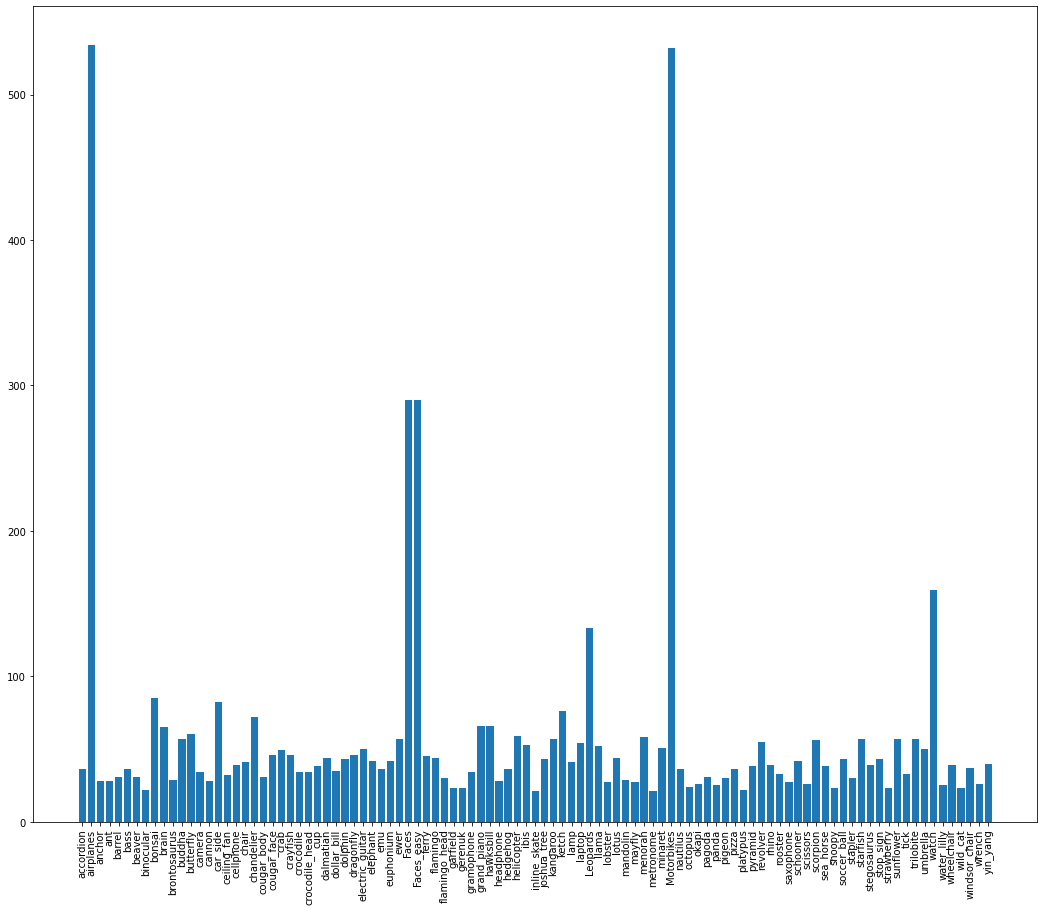

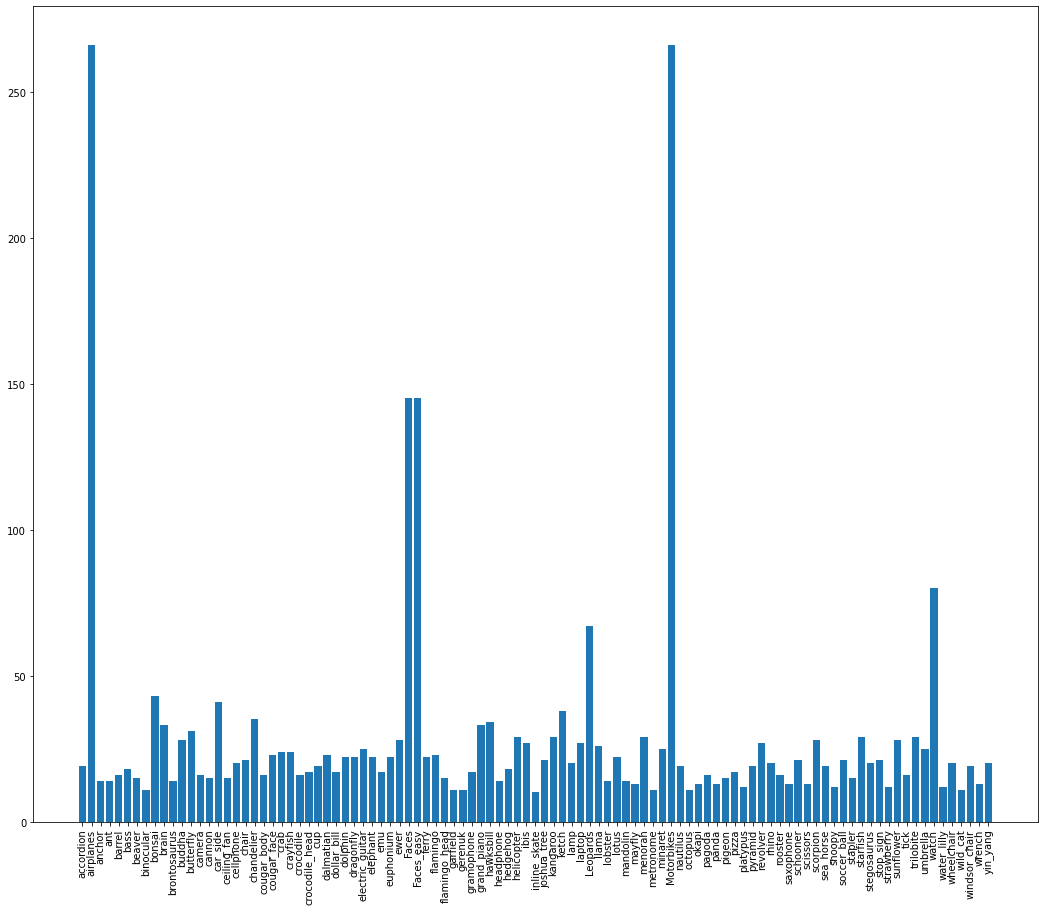

5784
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
#from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
labels, counts = train_dataset.__get_distribution__()
print(labels)
plt.figure(figsize=(18, 15))
plt.bar(labels, counts,)
plt.xticks(rotation='vertical')
plt.show()


test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
labels, counts = test_dataset.__get_distribution__()
plt.figure(figsize=(18, 15))
plt.bar(labels, counts,)
plt.xticks(rotation='vertical')
plt.show()

#train_indexes = # split the indices for your train split
#val_indexes = # split the indices for your val split
print(train_dataset.__len__())

train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

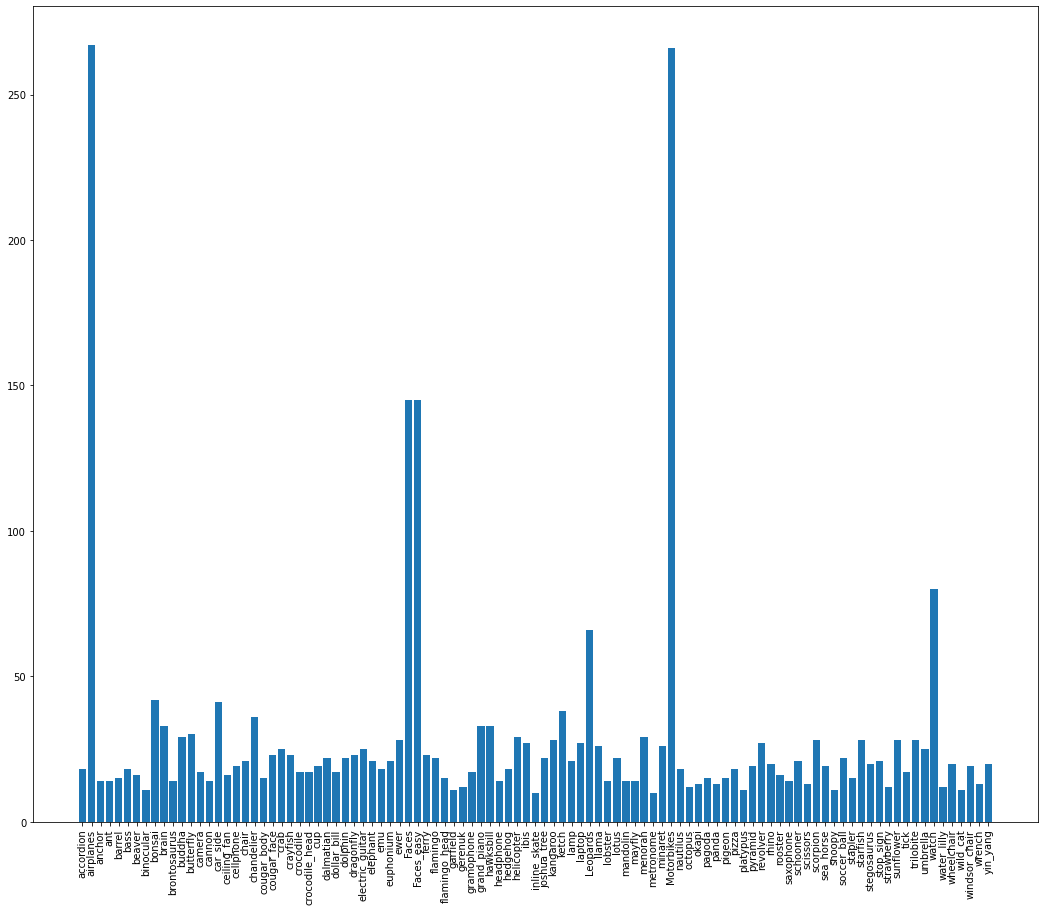

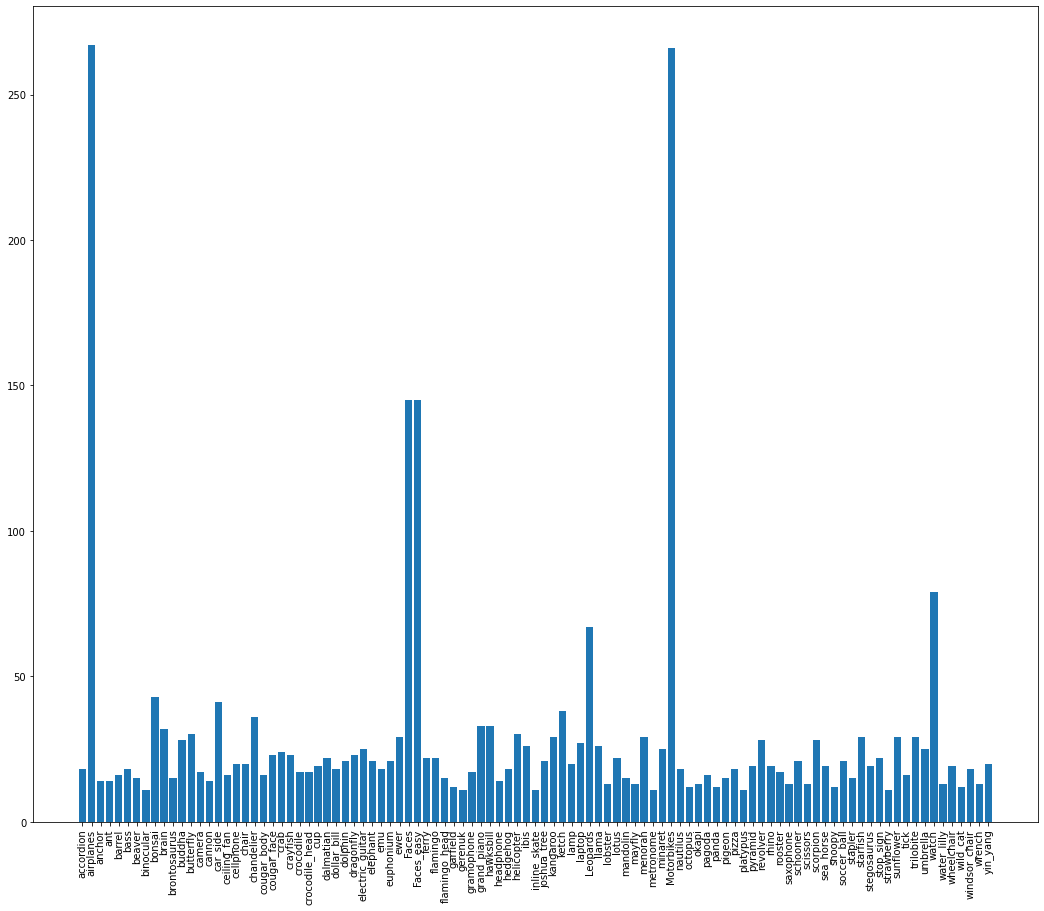

In [ ]:
train_dist = np.zeros(101)

for elem in train_dataset:
  train_dist[elem[1]] += 1

val_dist = np.zeros(101)

for elem in val_dataset:
  val_dist[elem[1]] += 1

plt.figure(figsize=(18, 15))
plt.bar(labels, train_dist,)
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(18, 15))
plt.bar(labels, val_dist,)
plt.xticks(rotation='vertical')
plt.show()

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

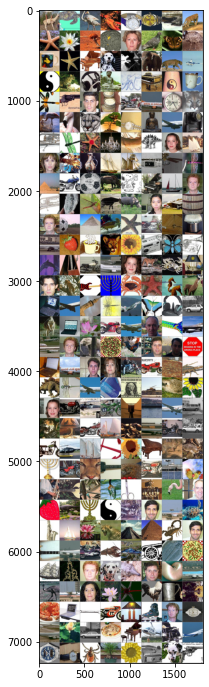

In [ ]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

**Prepare Network**

In [ ]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train & Validation**

In [ ]:
# By default, everything is loaded to cpu

def train(net,train_dataloader,val_dataloader,checkpoint_path):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  n_epochs_stop = 5
  min_val_loss = np.Inf
  epochs_no_improve = 0
  cudnn.benchmark # Calling this optimizes runtime
  train_loss , train_accuracy = [], []
  val_loss , val_accuracy = [], []

  current_step = 0
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    val_running_loss = 0.0
    val_running_correct = 0
    train_running_loss = 0.0
    train_running_correct = 0
    train_NUM_BATCHES = 0
    val_NUM_BATCHES = 0
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
    net.train(True)
    # Iterate over the dataset
    for images, labels in train_dataloader:  ##---------------------------------  TRAINING
      train_NUM_BATCHES += 1
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      train_running_loss += loss.item()
      _, preds = torch.max(outputs.data, 1)
      train_running_correct += torch.sum(preds == labels.data).data.item()
      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients
      

      current_step += 1


    net.train(False) # Set Network to evaluation mode
    for val_images, val_labels in tqdm(val_dataloader): ##----------------------  VALIDATION
      val_NUM_BATCHES += 1
      val_images = val_images.to(DEVICE)
      val_labels = val_labels.to(DEVICE)

      # Forward Pass
      outputs = net(val_images)
      loss = criterion(outputs, val_labels)
      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      val_running_correct += torch.sum(preds == val_labels.data).data.item()

      val_running_loss += loss.item()

    print()
    epoch_train_loss = train_running_loss/train_NUM_BATCHES
    epoch_train_accuracy = train_running_correct/float(len(train_dataset))
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}")
    epoch_val_loss = val_running_loss/val_NUM_BATCHES
    epoch_val_accuracy = val_running_correct / float(len(val_dataset))
    print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}')
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)
    # Step the scheduler
    scheduler.step() 
    print()
    print()


    # If the validation loss is at a minimum
    if epoch_val_loss < min_val_loss:
      # Save the model
      torch.save(net, checkpoint_path)
      epochs_no_improve = 0
      min_val_loss = epoch_val_loss
      
    else:
      epochs_no_improve += 1
      # Check early stopping condition
      if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        
        # Load in the best model
        net = torch.load(checkpoint_path)
  net = torch.load(checkpoint_path)
  return train_loss,train_accuracy,val_loss,val_accuracy,net
  


In [ ]:
def print_acc_loss(train_loss,train_accuracy,val_loss,val_accuracy,title):
  print(list(zip(train_loss,train_accuracy)),list(zip(val_loss,val_accuracy)))
  # accuracy plots
  plt.figure(figsize=(10, 7))
  plt.plot(train_accuracy, color='green', label='train accuracy')
  plt.plot(val_accuracy, color='blue', label='validataion accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(title+'_accuracy.png')
  plt.show()

  # loss plots
  plt.figure(figsize=(10, 7))
  plt.plot(train_loss, color='orange', label='train loss')
  plt.plot(val_loss, color='red', label='validataion loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(title+'_loss.png')
  plt.show()



**Test**

In [ ]:
def test(net, test_dataloader):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))

  print('Test Accuracy: {}'.format(accuracy))



Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.618052005767822


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss 4.617215156555176


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]



Train Loss: 4.6173, Train Acc: 0.01
Val Loss: 4.6165, Val Acc: 0.01


Starting epoch 2/30, LR = [0.001]
Step 20, Loss 4.613480567932129


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]



Train Loss: 4.6152, Train Acc: 0.01
Val Loss: 4.6140, Val Acc: 0.01


Starting epoch 3/30, LR = [0.001]
Step 30, Loss 4.612371921539307


100%|██████████| 12/12 [00:10<00:00,  1.18it/s]



Train Loss: 4.6124, Train Acc: 0.02
Val Loss: 4.6113, Val Acc: 0.01


Starting epoch 4/30, LR = [0.001]
Step 40, Loss 4.609251499176025


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]



Train Loss: 4.6094, Train Acc: 0.05
Val Loss: 4.6084, Val Acc: 0.09


Starting epoch 5/30, LR = [0.001]
Step 50, Loss 4.607298374176025


100%|██████████| 12/12 [00:09<00:00,  1.20it/s]



Train Loss: 4.6063, Train Acc: 0.08
Val Loss: 4.6055, Val Acc: 0.09


Starting epoch 6/30, LR = [0.001]
Step 60, Loss 4.601655006408691


100%|██████████| 12/12 [00:10<00:00,  1.18it/s]



Train Loss: 4.6032, Train Acc: 0.09
Val Loss: 4.6026, Val Acc: 0.09


Starting epoch 7/30, LR = [0.001]
Step 70, Loss 4.601445198059082


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]



Train Loss: 4.6002, Train Acc: 0.09
Val Loss: 4.5996, Val Acc: 0.09


Starting epoch 8/30, LR = [0.001]
Step 80, Loss 4.6002912521362305


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]



Train Loss: 4.5968, Train Acc: 0.09
Val Loss: 4.5966, Val Acc: 0.09


Starting epoch 9/30, LR = [0.001]
Step 90, Loss 4.595135688781738


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]



Train Loss: 4.5937, Train Acc: 0.09
Val Loss: 4.5936, Val Acc: 0.09


Starting epoch 10/30, LR = [0.001]
Step 100, Loss 4.590801239013672


100%|██████████| 12/12 [00:10<00:00,  1.18it/s]



Train Loss: 4.5902, Train Acc: 0.09
Val Loss: 4.5905, Val Acc: 0.11


Starting epoch 11/30, LR = [0.001]
Step 110, Loss 4.591506481170654


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss 4.584349155426025


100%|██████████| 12/12 [00:10<00:00,  1.20it/s]



Train Loss: 4.5872, Train Acc: 0.09
Val Loss: 4.5874, Val Acc: 0.12


Starting epoch 12/30, LR = [0.001]
Step 130, Loss 4.58420991897583


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]



Train Loss: 4.5836, Train Acc: 0.09
Val Loss: 4.5842, Val Acc: 0.12


Starting epoch 13/30, LR = [0.001]
Step 140, Loss 4.579031944274902


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]



Train Loss: 4.5803, Train Acc: 0.10
Val Loss: 4.5808, Val Acc: 0.12


Starting epoch 14/30, LR = [0.001]
Step 150, Loss 4.575170516967773


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]



Train Loss: 4.5763, Train Acc: 0.10
Val Loss: 4.5774, Val Acc: 0.11


Starting epoch 15/30, LR = [0.001]
Step 160, Loss 4.569559574127197


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.5723, Train Acc: 0.10
Val Loss: 4.5737, Val Acc: 0.11


Starting epoch 16/30, LR = [0.001]
Step 170, Loss 4.562412738800049


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.5679, Train Acc: 0.09
Val Loss: 4.5696, Val Acc: 0.09


Starting epoch 17/30, LR = [0.001]
Step 180, Loss 4.5552802085876465


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]



Train Loss: 4.5640, Train Acc: 0.09
Val Loss: 4.5651, Val Acc: 0.09


Starting epoch 18/30, LR = [0.001]
Step 190, Loss 4.556334018707275


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.5588, Train Acc: 0.10
Val Loss: 4.5602, Val Acc: 0.09


Starting epoch 19/30, LR = [0.001]
Step 200, Loss 4.544390678405762


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.5525, Train Acc: 0.10
Val Loss: 4.5542, Val Acc: 0.09


Starting epoch 20/30, LR = [0.001]
Step 210, Loss 4.557578086853027


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.5457, Train Acc: 0.09
Val Loss: 4.5470, Val Acc: 0.09


Starting epoch 21/30, LR = [0.0001]
Step 220, Loss 4.554315567016602


  0%|          | 0/12 [00:00<?, ?it/s]

Step 230, Loss 4.53397274017334


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.5415, Train Acc: 0.09
Val Loss: 4.5461, Val Acc: 0.09


Starting epoch 22/30, LR = [0.0001]
Step 240, Loss 4.543642997741699


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.5397, Train Acc: 0.09
Val Loss: 4.5452, Val Acc: 0.09


Starting epoch 23/30, LR = [0.0001]
Step 250, Loss 4.537551403045654


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.5380, Train Acc: 0.09
Val Loss: 4.5442, Val Acc: 0.09


Starting epoch 24/30, LR = [0.0001]
Step 260, Loss 4.531592845916748


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.5371, Train Acc: 0.10
Val Loss: 4.5431, Val Acc: 0.09


Starting epoch 25/30, LR = [0.0001]
Step 270, Loss 4.522591590881348


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.5358, Train Acc: 0.09
Val Loss: 4.5420, Val Acc: 0.09


Starting epoch 26/30, LR = [0.0001]
Step 280, Loss 4.530325412750244


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 4.5348, Train Acc: 0.09
Val Loss: 4.5409, Val Acc: 0.09


Starting epoch 27/30, LR = [0.0001]
Step 290, Loss 4.532498836517334


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.5338, Train Acc: 0.09
Val Loss: 4.5397, Val Acc: 0.09


Starting epoch 28/30, LR = [0.0001]
Step 300, Loss 4.527505397796631


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.5312, Train Acc: 0.09
Val Loss: 4.5385, Val Acc: 0.09


Starting epoch 29/30, LR = [0.0001]
Step 310, Loss 4.534125328063965


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.5303, Train Acc: 0.09
Val Loss: 4.5372, Val Acc: 0.09


Starting epoch 30/30, LR = [0.0001]
Step 320, Loss 4.514565467834473


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.5283, Train Acc: 0.09
Val Loss: 4.5358, Val Acc: 0.09


[(4.617290930314497, 0.012448132780082987), (4.615190462632612, 0.012448132780082987), (4.612375779585405, 0.01590594744121715), (4.609374739907005, 0.048409405255878286), (4.6063430526039815, 0.08367911479944674), (4.6031671870838515, 0.0867911479944675), (4.600217429074374, 0.08817427385892117), (4.596828330646861, 0.09266943291839558), (4.593700885772705, 0.09336099585062241), (4.590233586051247, 0.09163208852005532), (4.587163491682573, 0.08852005532503458), (4.583613612435081, 0.08990318118948824), (4.580305793068626, 0.0995850622406639), (4.576331962238658, 0.09889349930843706), (4.572267879139293, 0.09923928077455048), (4.567904038862749, 0.08817427385892117), (4.564016602256081, 0.08817427385892117), (4.558849161321467, 0.09820193637621023), (4.552517414093018, 0.09578146611341633), (4.54565091566606, 0.09163208852005532), (4.541531779549339, 0.09163208852005532), (4.539686853235418, 0.08990318118948824), (4

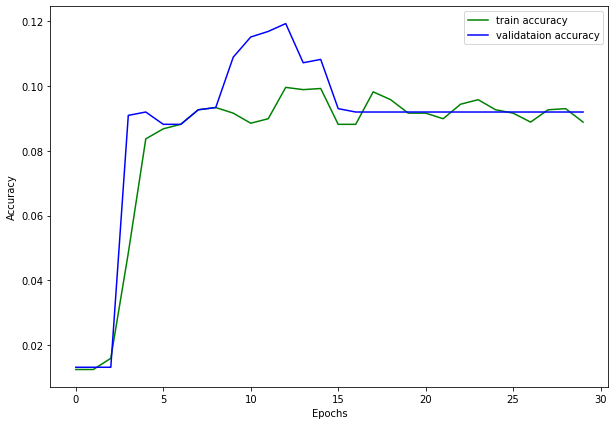

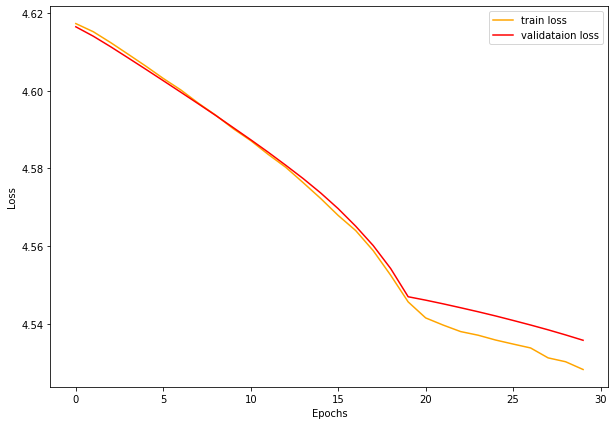

100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

Test Accuracy: 0.09194607673695127


In [ ]:
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet")
print_acc_loss(tl,ta,vl,va,"alexnet")
test(net,test_dataloader)

Hyperparameters experiments

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.615392684936523


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss 4.603328704833984


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.6102, Train Acc: 0.04
Val Loss: 4.6022, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.583361625671387


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.5909, Train Acc: 0.09
Val Loss: 4.5795, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.551033020019531


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 4.5638, Train Acc: 0.09
Val Loss: 4.5517, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.5227179527282715


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]



Train Loss: 4.5279, Train Acc: 0.09
Val Loss: 4.5071, Val Acc: 0.09


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.428945541381836


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.4044, Train Acc: 0.09
Val Loss: 4.3644, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.217484474182129


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 4.2646, Train Acc: 0.08
Val Loss: 4.2785, Val Acc: 0.09


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.253415107727051


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 4.2107, Train Acc: 0.10
Val Loss: 4.2325, Val Acc: 0.09


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.165233135223389


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 4.1768, Train Acc: 0.10
Val Loss: 4.2021, Val Acc: 0.14


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.103043556213379


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 4.1409, Train Acc: 0.11
Val Loss: 4.1580, Val Acc: 0.15


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 4.0235209465026855


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.0907, Train Acc: 0.14
Val Loss: 4.0878, Val Acc: 0.16


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 3.991727352142334


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss 3.957064151763916


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 4.0305, Train Acc: 0.16
Val Loss: 4.0344, Val Acc: 0.20


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 4.125749111175537


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 3.9488, Train Acc: 0.19
Val Loss: 3.9233, Val Acc: 0.21


Starting epoch 13/30, LR = [0.01]
Step 140, Loss 3.8302395343780518


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 3.8569, Train Acc: 0.20
Val Loss: 3.8321, Val Acc: 0.22


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 3.7782652378082275


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 3.7395, Train Acc: 0.22
Val Loss: 3.7233, Val Acc: 0.23


Starting epoch 15/30, LR = [0.01]
Step 160, Loss 3.8297531604766846


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 3.6606, Train Acc: 0.22
Val Loss: 3.7032, Val Acc: 0.24


Starting epoch 16/30, LR = [0.01]
Step 170, Loss 3.6700403690338135


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.6251, Train Acc: 0.23
Val Loss: 3.6046, Val Acc: 0.24


Starting epoch 17/30, LR = [0.01]
Step 180, Loss 3.4513680934906006


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.5206, Train Acc: 0.23
Val Loss: 3.5521, Val Acc: 0.26


Starting epoch 18/30, LR = [0.01]
Step 190, Loss 3.4583609104156494


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.4618, Train Acc: 0.24
Val Loss: 3.5295, Val Acc: 0.25


Starting epoch 19/30, LR = [0.01]
Step 200, Loss 3.3997883796691895


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 3.4190, Train Acc: 0.25
Val Loss: 3.4322, Val Acc: 0.27


Starting epoch 20/30, LR = [0.01]
Step 210, Loss 3.3957016468048096


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.3126, Train Acc: 0.27
Val Loss: 3.4327, Val Acc: 0.27


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 3.207629680633545


  0%|          | 0/12 [00:00<?, ?it/s]

Step 230, Loss 3.154329776763916


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.2049, Train Acc: 0.29
Val Loss: 3.3202, Val Acc: 0.29


Starting epoch 22/30, LR = [0.001]
Step 240, Loss 3.2057368755340576


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.1551, Train Acc: 0.29
Val Loss: 3.3282, Val Acc: 0.29


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 3.057046890258789


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.1344, Train Acc: 0.29
Val Loss: 3.3427, Val Acc: 0.29


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 3.110319137573242


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.1173, Train Acc: 0.30
Val Loss: 3.3016, Val Acc: 0.30


Starting epoch 25/30, LR = [0.001]
Step 270, Loss 3.024951219558716


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.0877, Train Acc: 0.30
Val Loss: 3.2857, Val Acc: 0.30


Starting epoch 26/30, LR = [0.001]
Step 280, Loss 2.999316453933716


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 3.0693, Train Acc: 0.29
Val Loss: 3.2720, Val Acc: 0.30


Starting epoch 27/30, LR = [0.001]
Step 290, Loss 2.966179370880127


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.0494, Train Acc: 0.31
Val Loss: 3.2652, Val Acc: 0.30


Starting epoch 28/30, LR = [0.001]
Step 300, Loss 3.179774045944214


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.0410, Train Acc: 0.31
Val Loss: 3.3094, Val Acc: 0.30


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 3.1434245109558105


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.0151, Train Acc: 0.31
Val Loss: 3.2807, Val Acc: 0.30


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 2.8349220752716064


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 2.9953, Train Acc: 0.31
Val Loss: 3.2373, Val Acc: 0.31


[(4.610172791914507, 0.04391424619640387), (4.5908987738869405, 0.08817427385892117), (4.563792272047563, 0.08955739972337483), (4.52785097468983, 0.08990318118948824), (4.404394886710427, 0.09024896265560166), (4.26456525109031, 0.084716459197787), (4.210661281238902, 0.09785615491009682), (4.176847024397417, 0.10269709543568464), (4.140860774300315, 0.11168741355463348), (4.09069165316495, 0.13692946058091288), (4.0304693525487725, 0.15802213001383125), (3.948848941109397, 0.19052558782849238), (3.856894384730946, 0.20401106500691563), (3.739540620283647, 0.21507607192254496), (3.660629229112105, 0.21542185338865838), (3.625075405294245, 0.23167358229598894), (3.5206475908106025, 0.23167358229598894), (3.461774479259144, 0.23962655601659752), (3.419032487002286, 0.24654218533886585), (3.3126499436118384, 0.2693637621023513), (3.204860557209362, 0.28526970954356845), (3.155072797428478, 0.28803596127247577), (3.134

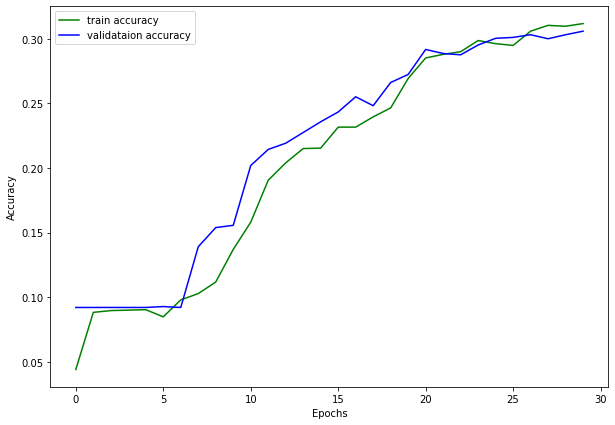

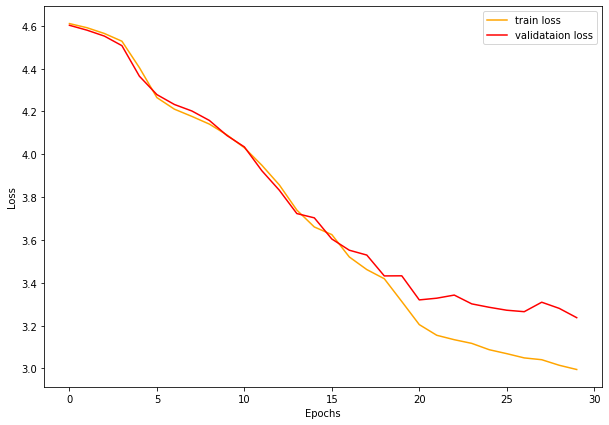

100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

Test Accuracy: 0.3131697200138265


In [ ]:
LR = 1e-2
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet LR 1e-2")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-2")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.1]
Step 0, Loss 4.615151882171631


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss 4.4997711181640625


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.5699, Train Acc: 0.07
Val Loss: 4.4423, Val Acc: 0.09


Starting epoch 2/30, LR = [0.1]
Step 20, Loss 4.4663472175598145


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 4.4832, Train Acc: 0.09
Val Loss: 4.4430, Val Acc: 0.09


Starting epoch 3/30, LR = [0.1]


Step 30, Loss 4.294369697570801


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.3596, Train Acc: 0.09
Val Loss: 4.3031, Val Acc: 0.09


Starting epoch 4/30, LR = [0.1]
Step 40, Loss 4.1747894287109375


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.2320, Train Acc: 0.09
Val Loss: 4.2343, Val Acc: 0.09


Starting epoch 5/30, LR = [0.1]
Step 50, Loss 4.086668968200684


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.1722, Train Acc: 0.11
Val Loss: 4.1799, Val Acc: 0.11


Starting epoch 6/30, LR = [0.1]
Step 60, Loss 4.034832954406738


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Train Loss: 4.1315, Train Acc: 0.11
Val Loss: 4.2690, Val Acc: 0.09


Starting epoch 7/30, LR = [0.1]


Step 70, Loss 4.179238319396973


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 4.2232, Train Acc: 0.10
Val Loss: 4.2435, Val Acc: 0.09


Starting epoch 8/30, LR = [0.1]


Step 80, Loss 4.116239070892334


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.1620, Train Acc: 0.13
Val Loss: 4.1287, Val Acc: 0.16


Starting epoch 9/30, LR = [0.1]
Step 90, Loss 4.081120014190674


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 4.0698, Train Acc: 0.16
Val Loss: 4.1723, Val Acc: 0.11


Starting epoch 10/30, LR = [0.1]


Step 100, Loss 4.103595733642578


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 4.0741, Train Acc: 0.15
Val Loss: 4.0522, Val Acc: 0.19


Starting epoch 11/30, LR = [0.1]
Step 110, Loss 4.000649452209473


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss 3.8988027572631836


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.0853, Train Acc: 0.15
Val Loss: 3.9693, Val Acc: 0.18


Starting epoch 12/30, LR = [0.1]
Step 130, Loss 3.817829132080078


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 3.8990, Train Acc: 0.19
Val Loss: 3.9668, Val Acc: 0.17


Starting epoch 13/30, LR = [0.1]
Step 140, Loss 3.8186872005462646


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Train Loss: 3.8088, Train Acc: 0.19
Val Loss: 3.9955, Val Acc: 0.18


Starting epoch 14/30, LR = [0.1]


Step 150, Loss 3.8646700382232666


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 3.7897, Train Acc: 0.20
Val Loss: 3.6941, Val Acc: 0.23


Starting epoch 15/30, LR = [0.1]
Step 160, Loss 3.669588327407837


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Train Loss: 3.5713, Train Acc: 0.23
Val Loss: 3.8133, Val Acc: 0.21


Starting epoch 16/30, LR = [0.1]


Step 170, Loss 3.535081624984741


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 3.6279, Train Acc: 0.22
Val Loss: 3.6363, Val Acc: 0.25


Starting epoch 17/30, LR = [0.1]
Step 180, Loss 3.5417540073394775


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.4548, Train Acc: 0.24
Val Loss: 3.4419, Val Acc: 0.27


Starting epoch 18/30, LR = [0.1]
Step 190, Loss 3.401576042175293


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 3.4220, Train Acc: 0.26
Val Loss: 3.4723, Val Acc: 0.27


Starting epoch 19/30, LR = [0.1]


Step 200, Loss 3.6469533443450928


100%|██████████| 12/12 [00:09<00:00,  1.20it/s]



Train Loss: 3.2726, Train Acc: 0.28
Val Loss: 3.2852, Val Acc: 0.30


Starting epoch 20/30, LR = [0.1]
Step 210, Loss 3.312476873397827


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Train Loss: 3.0860, Train Acc: 0.31
Val Loss: 3.3645, Val Acc: 0.25


Starting epoch 21/30, LR = [0.010000000000000002]


Step 220, Loss 2.8817243576049805


  0%|          | 0/12 [00:00<?, ?it/s]

Step 230, Loss 2.9905738830566406


100%|██████████| 12/12 [00:10<00:00,  1.14it/s]



Train Loss: 2.9821, Train Acc: 0.31
Val Loss: 3.2126, Val Acc: 0.31


Starting epoch 22/30, LR = [0.010000000000000002]
Step 240, Loss 2.872119426727295


100%|██████████| 12/12 [00:12<00:00,  1.08s/it]



Train Loss: 2.7789, Train Acc: 0.35
Val Loss: 3.0961, Val Acc: 0.34


Starting epoch 23/30, LR = [0.010000000000000002]
Step 250, Loss 2.6312568187713623


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]



Train Loss: 2.6725, Train Acc: 0.36
Val Loss: 3.0674, Val Acc: 0.35


Starting epoch 24/30, LR = [0.010000000000000002]
Step 260, Loss 2.68660044670105


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]



Train Loss: 2.5712, Train Acc: 0.38
Val Loss: 3.0034, Val Acc: 0.36


Starting epoch 25/30, LR = [0.010000000000000002]
Step 270, Loss 2.493382453918457


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]



Train Loss: 2.4923, Train Acc: 0.40
Val Loss: 2.9970, Val Acc: 0.37


Starting epoch 26/30, LR = [0.010000000000000002]
Step 280, Loss 2.32562255859375


100%|██████████| 12/12 [00:10<00:00,  1.14it/s]



Train Loss: 2.4320, Train Acc: 0.41
Val Loss: 2.9200, Val Acc: 0.37


Starting epoch 27/30, LR = [0.010000000000000002]
Step 290, Loss 2.350576400756836


100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Train Loss: 2.3557, Train Acc: 0.42
Val Loss: 2.9319, Val Acc: 0.39


Starting epoch 28/30, LR = [0.010000000000000002]


Step 300, Loss 2.440936803817749


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Train Loss: 2.2802, Train Acc: 0.44
Val Loss: 2.9339, Val Acc: 0.39


Starting epoch 29/30, LR = [0.010000000000000002]


Step 310, Loss 2.317016363143921


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Train Loss: 2.2195, Train Acc: 0.44
Val Loss: 2.9203, Val Acc: 0.40


Starting epoch 30/30, LR = [0.010000000000000002]


Step 320, Loss 2.1783454418182373


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]



Train Loss: 2.1247, Train Acc: 0.47
Val Loss: 2.8500, Val Acc: 0.40


[(4.569898301904852, 0.07434301521438451), (4.483153343200684, 0.0867911479944675), (4.359644543040883, 0.08955739972337483), (4.232032645832408, 0.08955739972337483), (4.172182863408869, 0.11134163208852006), (4.131547711112282, 0.10719225449515905), (4.223178950223056, 0.09612724757952974), (4.162013097242876, 0.1251728907330567), (4.0697547955946485, 0.15594744121715076), (4.074128736149181, 0.15283540802213003), (4.0853071212768555, 0.15110650069156292), (3.899034695191817, 0.18672199170124482), (3.8087769855152476, 0.18741355463347165), (3.7896636616099966, 0.20435684647302904), (3.571289474313909, 0.22856154910096818), (3.627937663685192, 0.21749654218533887), (3.4548100341450083, 0.23962655601659752), (3.421992063522339, 0.2572614107883817), (3.2725822058590976, 0.28042876901798064), (3.0860257582231, 0.3091286307053942), (2.9820862033150415, 0.3070539419087137), (2.778944579037753, 0.3478561549100968), (2.67

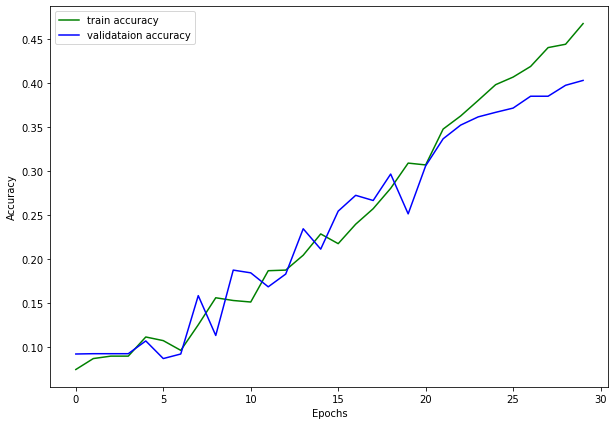

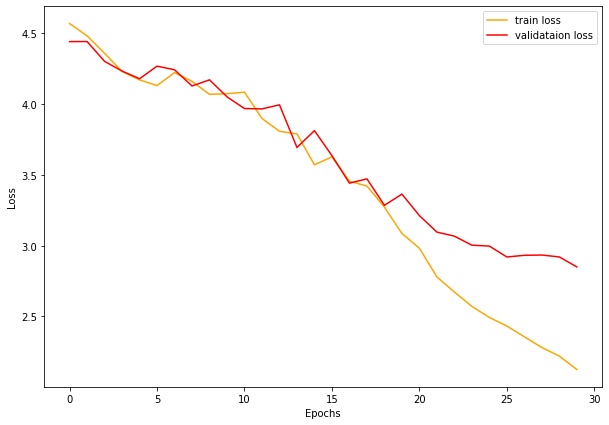

100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

Test Accuracy: 0.40926374006221916


In [ ]:
LR = 1e-1
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet LR 1e-2")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-2")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.614316463470459
Step 10, Loss 4.603462219238281


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 4.6092, Train Acc: 0.05
Val Loss: 4.6011, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.5848870277404785


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 4.5901, Train Acc: 0.09
Val Loss: 4.5777, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.550736427307129


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]



Train Loss: 4.5619, Train Acc: 0.09
Val Loss: 4.5477, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.519993782043457


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]



Train Loss: 4.5187, Train Acc: 0.09
Val Loss: 4.4757, Val Acc: 0.09


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.3415021896362305


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 4.3536, Train Acc: 0.09
Val Loss: 4.3311, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.289024353027344


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2518, Train Acc: 0.09
Val Loss: 4.2422, Val Acc: 0.09


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.244075298309326


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2027, Train Acc: 0.09
Val Loss: 4.2169, Val Acc: 0.09


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.259140491485596


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.1641, Train Acc: 0.12
Val Loss: 4.1925, Val Acc: 0.14


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.1330180168151855


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.1430, Train Acc: 0.12
Val Loss: 4.1422, Val Acc: 0.14


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 4.110635757446289


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.0905, Train Acc: 0.14
Val Loss: 4.0796, Val Acc: 0.15


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 3.992586851119995
Step 120, Loss 4.104930877685547


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.0192, Train Acc: 0.16
Val Loss: 4.0215, Val Acc: 0.19


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 3.9861292839050293


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 3.9576, Train Acc: 0.18
Val Loss: 3.9365, Val Acc: 0.20


Starting epoch 13/30, LR = [0.01]
Step 140, Loss 3.826054573059082


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 3.8477, Train Acc: 0.20
Val Loss: 3.8122, Val Acc: 0.22


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 3.541379928588867


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 3.7460, Train Acc: 0.21
Val Loss: 3.7468, Val Acc: 0.23


Starting epoch 15/30, LR = [0.01]
Step 160, Loss 3.703537940979004


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 3.6938, Train Acc: 0.21
Val Loss: 3.6507, Val Acc: 0.24


Starting epoch 16/30, LR = [0.001]
Step 170, Loss 3.7316043376922607


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 3.5883, Train Acc: 0.23
Val Loss: 3.6334, Val Acc: 0.24


Starting epoch 17/30, LR = [0.001]
Step 180, Loss 3.6262316703796387


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]



Train Loss: 3.5637, Train Acc: 0.23
Val Loss: 3.6144, Val Acc: 0.24


Starting epoch 18/30, LR = [0.001]
Step 190, Loss 3.5227091312408447


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



Train Loss: 3.5530, Train Acc: 0.23
Val Loss: 3.5979, Val Acc: 0.24


Starting epoch 19/30, LR = [0.001]
Step 200, Loss 3.7756917476654053


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 3.5328, Train Acc: 0.23
Val Loss: 3.5893, Val Acc: 0.25


Starting epoch 20/30, LR = [0.001]
Step 210, Loss 3.627582311630249


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 3.5193, Train Acc: 0.24
Val Loss: 3.5758, Val Acc: 0.25


Starting epoch 21/30, LR = [0.001]
Step 220, Loss 3.5354716777801514
Step 230, Loss 3.5258703231811523


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Train Loss: 3.5026, Train Acc: 0.24
Val Loss: 3.5864, Val Acc: 0.24


Starting epoch 22/30, LR = [0.001]


Step 240, Loss 3.3910417556762695


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 3.4934, Train Acc: 0.24
Val Loss: 3.5528, Val Acc: 0.25


Starting epoch 23/30, LR = [0.001]
Step 250, Loss 3.6410670280456543


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Train Loss: 3.4800, Train Acc: 0.24
Val Loss: 3.5661, Val Acc: 0.25


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 3.6357436180114746


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]



Train Loss: 3.4665, Train Acc: 0.24
Val Loss: 3.5432, Val Acc: 0.25


Starting epoch 25/30, LR = [0.001]
Step 270, Loss 3.3933351039886475


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



Train Loss: 3.4560, Train Acc: 0.24
Val Loss: 3.5306, Val Acc: 0.25


Starting epoch 26/30, LR = [0.001]
Step 280, Loss 3.2837352752685547


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 3.4430, Train Acc: 0.25
Val Loss: 3.5228, Val Acc: 0.25


Starting epoch 27/30, LR = [0.001]
Step 290, Loss 3.3924643993377686


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 3.4331, Train Acc: 0.25
Val Loss: 3.5143, Val Acc: 0.25


Starting epoch 28/30, LR = [0.001]
Step 300, Loss 3.4162464141845703


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 3.4099, Train Acc: 0.25
Val Loss: 3.5122, Val Acc: 0.26


Starting epoch 29/30, LR = [0.001]
Step 310, Loss 3.4434094429016113


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



Train Loss: 3.3931, Train Acc: 0.26
Val Loss: 3.4911, Val Acc: 0.26


Starting epoch 30/30, LR = [0.001]
Step 320, Loss 3.2828192710876465


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]



Train Loss: 3.3748, Train Acc: 0.26
Val Loss: 3.4903, Val Acc: 0.26


[(4.609228697690097, 0.054287690179806364), (4.5900678201155225, 0.08955739972337483), (4.561869404532692, 0.088865836791148), (4.518738009712913, 0.08817427385892117), (4.353577483784068, 0.08921161825726141), (4.251759225671941, 0.09197786998616875), (4.202697970650413, 0.08990318118948824), (4.164082873951305, 0.11894882434301521), (4.14304122057828, 0.12448132780082988), (4.09046179598028, 0.1400414937759336), (4.019247857007113, 0.16182572614107885), (3.957620469006625, 0.18464730290456433), (3.847703066739169, 0.20470262793914246), (3.7460226362401787, 0.2095435684647303), (3.69378493048928, 0.21334716459197786), (3.5883186730471524, 0.22579529737206086), (3.5637304999611596, 0.23098201936376211), (3.55304538119923, 0.23167358229598894), (3.532807631926103, 0.23201936376210236), (3.519278721375899, 0.24031811894882435), (3.5026388385079126, 0.23824343015214383), (3.4934001835909756, 0.23997233748271093), (3.47

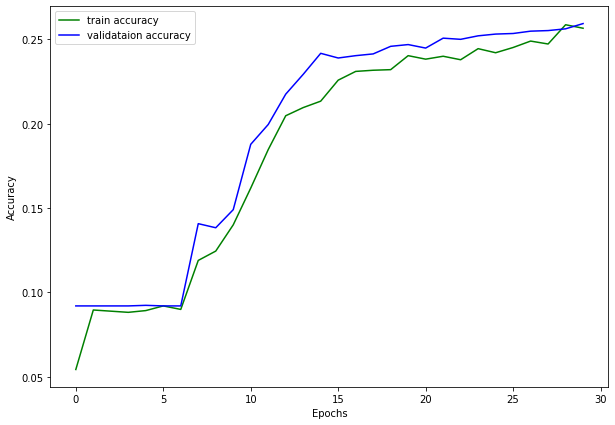

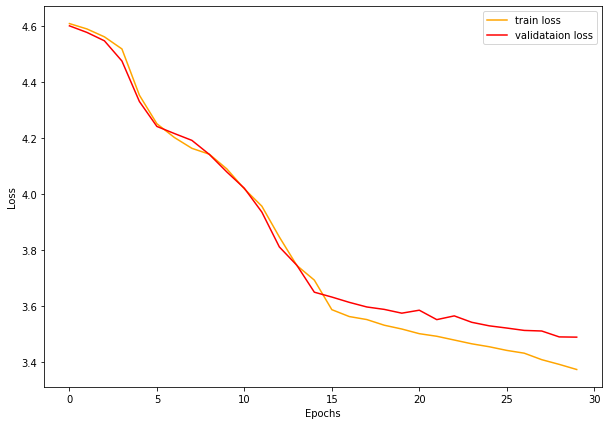

100%|██████████| 12/12 [00:08<00:00,  1.39it/s]

Test Accuracy: 0.25475285171102663


In [ ]:
STEP_SIZE = 15
LR = 1e-2
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet LR 1e-1")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-1")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.615085601806641
Step 10, Loss 4.6047282218933105


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 4.6110, Train Acc: 0.05
Val Loss: 4.6028, Val Acc: 0.14


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.578464984893799


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 4.5917, Train Acc: 0.10
Val Loss: 4.5801, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.560129165649414


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.5636, Train Acc: 0.09
Val Loss: 4.5505, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.496909141540527


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.5205, Train Acc: 0.09
Val Loss: 4.4858, Val Acc: 0.09


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.306229591369629


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.3569, Train Acc: 0.09
Val Loss: 4.3038, Val Acc: 0.09


Starting epoch 6/30, LR = [0.001]
Step 60, Loss 4.31486701965332


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2582, Train Acc: 0.10
Val Loss: 4.2764, Val Acc: 0.09


Starting epoch 7/30, LR = [0.001]
Step 70, Loss 4.122486591339111


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2367, Train Acc: 0.09
Val Loss: 4.2608, Val Acc: 0.09


Starting epoch 8/30, LR = [0.001]
Step 80, Loss 4.1546549797058105


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2197, Train Acc: 0.09
Val Loss: 4.2570, Val Acc: 0.09


Starting epoch 9/30, LR = [0.001]
Step 90, Loss 4.351139545440674


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2126, Train Acc: 0.09
Val Loss: 4.2518, Val Acc: 0.09


Starting epoch 10/30, LR = [0.001]
Step 100, Loss 4.2421441078186035


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



Train Loss: 4.2120, Train Acc: 0.09
Val Loss: 4.2463, Val Acc: 0.09


Starting epoch 11/30, LR = [0.0001]
Step 110, Loss 4.232907295227051
Step 120, Loss 4.287365436553955


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2046, Train Acc: 0.09
Val Loss: 4.2460, Val Acc: 0.09


Starting epoch 12/30, LR = [0.0001]
Step 130, Loss 4.1024909019470215


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 4.2099, Train Acc: 0.09
Val Loss: 4.2458, Val Acc: 0.09


Starting epoch 13/30, LR = [0.0001]
Step 140, Loss 4.229328632354736


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2070, Train Acc: 0.09
Val Loss: 4.2455, Val Acc: 0.09


Starting epoch 14/30, LR = [0.0001]
Step 150, Loss 4.214751243591309


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2063, Train Acc: 0.09
Val Loss: 4.2452, Val Acc: 0.09


Starting epoch 15/30, LR = [0.0001]
Step 160, Loss 4.168382167816162


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



Train Loss: 4.2020, Train Acc: 0.09
Val Loss: 4.2449, Val Acc: 0.09


Starting epoch 16/30, LR = [1e-05]
Step 170, Loss 4.1592698097229


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2044, Train Acc: 0.09
Val Loss: 4.2448, Val Acc: 0.09


Starting epoch 17/30, LR = [1e-05]
Step 180, Loss 4.202399253845215


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2055, Train Acc: 0.09
Val Loss: 4.2448, Val Acc: 0.09


Starting epoch 18/30, LR = [1e-05]
Step 190, Loss 4.059183120727539


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.1950, Train Acc: 0.09
Val Loss: 4.2448, Val Acc: 0.09


Starting epoch 19/30, LR = [1e-05]
Step 200, Loss 4.299867153167725


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2077, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 20/30, LR = [1e-05]
Step 210, Loss 4.245327472686768


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2006, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 21/30, LR = [1.0000000000000002e-06]
Step 220, Loss 4.104640483856201
Step 230, Loss 4.105597019195557


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2038, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 22/30, LR = [1.0000000000000002e-06]
Step 240, Loss 4.240875244140625


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2001, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 23/30, LR = [1.0000000000000002e-06]
Step 250, Loss 4.188950061798096


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]



Train Loss: 4.2026, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 24/30, LR = [1.0000000000000002e-06]
Step 260, Loss 4.123685359954834


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2062, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 25/30, LR = [1.0000000000000002e-06]
Step 270, Loss 4.183487892150879


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2042, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 26/30, LR = [1.0000000000000002e-07]
Step 280, Loss 4.198347091674805


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2081, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 27/30, LR = [1.0000000000000002e-07]
Step 290, Loss 4.262397766113281


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]



Train Loss: 4.2060, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 28/30, LR = [1.0000000000000002e-07]
Step 300, Loss 4.1343207359313965


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 4.2014, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 29/30, LR = [1.0000000000000002e-07]
Step 310, Loss 4.209224224090576


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2035, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


Starting epoch 30/30, LR = [1.0000000000000002e-07]
Step 320, Loss 4.151827812194824


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 4.2096, Train Acc: 0.09
Val Loss: 4.2447, Val Acc: 0.09


[(4.610959659923207, 0.04529737206085754), (4.591716202822599, 0.09820193637621023), (4.563608169555664, 0.09232365145228216), (4.520524761893532, 0.08955739972337483), (4.356911529194225, 0.09024896265560166), (4.258226134560325, 0.09508990318118948), (4.2366720546375625, 0.09405255878284924), (4.219742558219216, 0.0912863070539419), (4.212577559731224, 0.088865836791148), (4.211954290216619, 0.08921161825726141), (4.204565958543257, 0.09059474412171507), (4.209911259737882, 0.08955739972337483), (4.2070230137218125, 0.08955739972337483), (4.206272905523127, 0.09163208852005532), (4.202019691467285, 0.09024896265560166), (4.204394600608132, 0.08955739972337483), (4.20546631379561, 0.08852005532503458), (4.194967096502131, 0.09163208852005532), (4.207725568251177, 0.088865836791148), (4.200625679709694, 0.09094052558782849), (4.203818104483864, 0.09163208852005532), (4.200148235667836, 0.09059474412171507), (4.20264

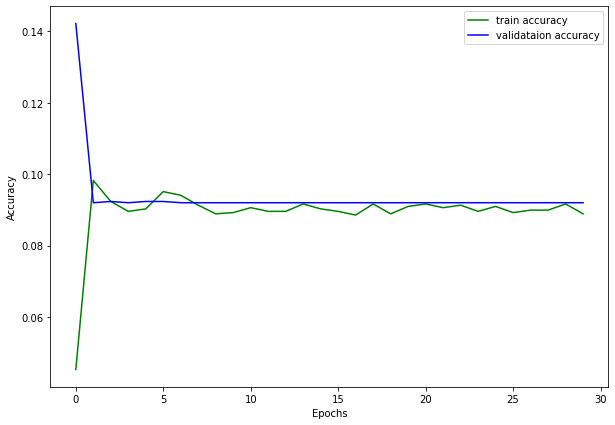

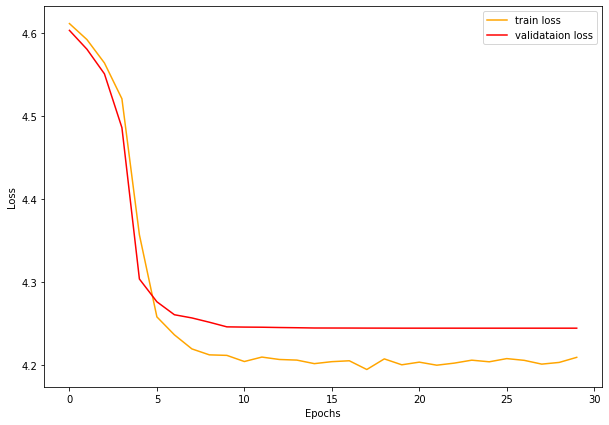

100%|██████████| 12/12 [00:08<00:00,  1.37it/s]

Test Accuracy: 0.09194607673695127


In [ ]:
STEP_SIZE = 5
LR = 1e-2
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet LR 1e-1")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-1")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.6145920753479
Step 10, Loss 4.602213382720947


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]



Train Loss: 4.6100, Train Acc: 0.05
Val Loss: 4.6017, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.579292297363281


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 4.5895, Train Acc: 0.10
Val Loss: 4.5776, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.563114643096924


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]



Train Loss: 4.5580, Train Acc: 0.11
Val Loss: 4.5416, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.469381809234619


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.4793, Train Acc: 0.09
Val Loss: 4.3444, Val Acc: 0.09


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.239418983459473


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.2856, Train Acc: 0.09
Val Loss: 4.2824, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.264627456665039


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.2348, Train Acc: 0.09
Val Loss: 4.2453, Val Acc: 0.09


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.185744285583496


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.1939, Train Acc: 0.10
Val Loss: 4.2112, Val Acc: 0.10


Starting epoch 8/30, LR = [0.001]
Step 80, Loss 4.112286567687988


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.1692, Train Acc: 0.11
Val Loss: 4.2083, Val Acc: 0.13


Starting epoch 9/30, LR = [0.001]
Step 90, Loss 4.176692008972168


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 4.1621, Train Acc: 0.14
Val Loss: 4.2030, Val Acc: 0.15


Starting epoch 10/30, LR = [0.001]
Step 100, Loss 4.296353816986084


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.1693, Train Acc: 0.12
Val Loss: 4.2003, Val Acc: 0.13


Starting epoch 11/30, LR = [0.001]
Step 110, Loss 4.1706318855285645
Step 120, Loss 4.165968894958496


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.1582, Train Acc: 0.11
Val Loss: 4.1958, Val Acc: 0.13


Starting epoch 12/30, LR = [0.001]
Step 130, Loss 4.104220390319824


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.1559, Train Acc: 0.11
Val Loss: 4.1916, Val Acc: 0.14


Starting epoch 13/30, LR = [0.001]
Step 140, Loss 4.122584342956543


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.1537, Train Acc: 0.13
Val Loss: 4.1887, Val Acc: 0.15


Starting epoch 14/30, LR = [0.001]
Step 150, Loss 4.149580478668213


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.1496, Train Acc: 0.13
Val Loss: 4.1813, Val Acc: 0.14


Starting epoch 15/30, LR = [0.0001]
Step 160, Loss 4.150404453277588


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.1549, Train Acc: 0.12
Val Loss: 4.1811, Val Acc: 0.15


Starting epoch 16/30, LR = [0.0001]
Step 170, Loss 4.112802982330322


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 4.1464, Train Acc: 0.13
Val Loss: 4.1811, Val Acc: 0.15


Starting epoch 17/30, LR = [0.0001]


Step 180, Loss 4.088146686553955


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.1418, Train Acc: 0.13
Val Loss: 4.1810, Val Acc: 0.15


Starting epoch 18/30, LR = [0.0001]
Step 190, Loss 4.126495838165283


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.1456, Train Acc: 0.13
Val Loss: 4.1807, Val Acc: 0.15


Starting epoch 19/30, LR = [0.0001]
Step 200, Loss 4.016839981079102


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.1480, Train Acc: 0.13
Val Loss: 4.1801, Val Acc: 0.15


Starting epoch 20/30, LR = [0.0001]
Step 210, Loss 4.0436930656433105


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.1402, Train Acc: 0.13
Val Loss: 4.1794, Val Acc: 0.15


Starting epoch 21/30, LR = [0.0001]
Step 220, Loss 4.035336971282959
Step 230, Loss 4.056642055511475


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.1454, Train Acc: 0.13
Val Loss: 4.1792, Val Acc: 0.15


Starting epoch 22/30, LR = [1e-05]
Step 240, Loss 4.075801849365234


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.1455, Train Acc: 0.13
Val Loss: 4.1791, Val Acc: 0.15


Starting epoch 23/30, LR = [1e-05]
Step 250, Loss 4.135680198669434


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.1403, Train Acc: 0.13
Val Loss: 4.1791, Val Acc: 0.15


Starting epoch 24/30, LR = [1e-05]
Step 260, Loss 3.991471767425537


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 4.1420, Train Acc: 0.13
Val Loss: 4.1790, Val Acc: 0.15


Starting epoch 25/30, LR = [1e-05]
Step 270, Loss 4.176736354827881


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.1388, Train Acc: 0.13
Val Loss: 4.1789, Val Acc: 0.15


Starting epoch 26/30, LR = [1e-05]
Step 280, Loss 4.188307762145996


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.1392, Train Acc: 0.13
Val Loss: 4.1788, Val Acc: 0.15


Starting epoch 27/30, LR = [1e-05]
Step 290, Loss 4.10906457901001


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.1429, Train Acc: 0.13
Val Loss: 4.1788, Val Acc: 0.15


Starting epoch 28/30, LR = [1e-05]
Step 300, Loss 4.182104110717773


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.1364, Train Acc: 0.13
Val Loss: 4.1787, Val Acc: 0.15


Starting epoch 29/30, LR = [1.0000000000000002e-06]
Step 310, Loss 4.171961784362793


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.1425, Train Acc: 0.13
Val Loss: 4.1787, Val Acc: 0.15


Starting epoch 30/30, LR = [1.0000000000000002e-06]
Step 320, Loss 4.240261554718018


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.1444, Train Acc: 0.13
Val Loss: 4.1787, Val Acc: 0.15


[(4.609964500774037, 0.052904564315352696), (4.589489286596125, 0.09508990318118948), (4.557955395091664, 0.10995850622406639), (4.47929573059082, 0.09024896265560166), (4.285567587072199, 0.09232365145228216), (4.234849106181752, 0.0867911479944675), (4.193910945545543, 0.10269709543568464), (4.169176318428733, 0.11479944674965421), (4.162122076207941, 0.13623789764868602), (4.169329643249512, 0.11583679114799447), (4.15824369950728, 0.10684647302904564), (4.155944000590932, 0.11134163208852006), (4.153743548826738, 0.12621023513139695), (4.149639909917658, 0.1251728907330567), (4.154918974096125, 0.12136929460580913), (4.146372708407315, 0.12621023513139695), (4.141811414198442, 0.13174273858921162), (4.145615014162931, 0.12863070539419086), (4.148018230091441, 0.13208852005532504), (4.140214920043945, 0.12966804979253113), (4.145409497347745, 0.12966804979253113), (4.145504973151467, 0.13001383125864455), (4.1402

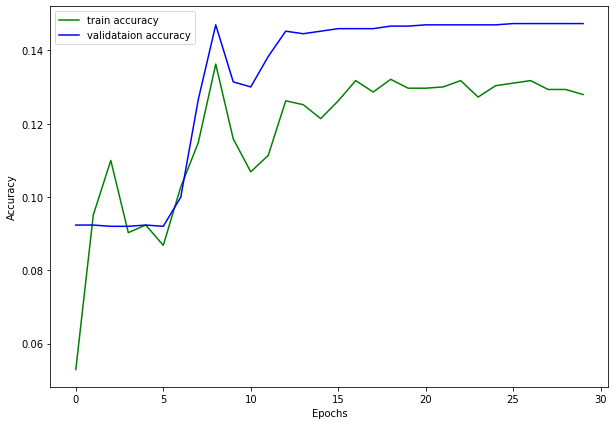

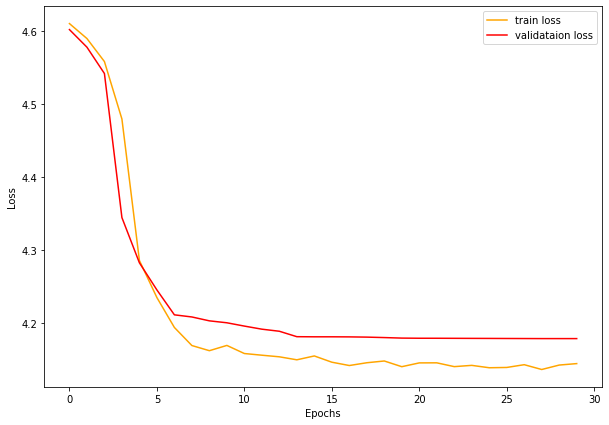

100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

Test Accuracy: 0.14344970618734879


In [ ]:
STEP_SIZE = 10
LR = 1e-2
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet LR 1e-1")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-1")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.615483283996582
Step 10, Loss 4.603641510009766



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.6112, Train Acc: 0.06
Val Loss: 4.6034, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.582437992095947



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.5917, Train Acc: 0.09
Val Loss: 4.5803, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.552960395812988



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.5642, Train Acc: 0.09
Val Loss: 4.5510, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.519539833068848



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.5251, Train Acc: 0.09
Val Loss: 4.4992, Val Acc: 0.10


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.339590549468994



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.3848, Train Acc: 0.10
Val Loss: 4.2975, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.35988712310791



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.2567, Train Acc: 0.09
Val Loss: 4.2644, Val Acc: 0.09


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.192566871643066



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.2100, Train Acc: 0.10
Val Loss: 4.2281, Val Acc: 0.10


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.171319961547852



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.1829, Train Acc: 0.12
Val Loss: 4.2112, Val Acc: 0.12


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.199757099151611



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 4.1441, Train Acc: 0.11
Val Loss: 4.1716, Val Acc: 0.12


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 4.027096748352051



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 4.1041, Train Acc: 0.12
Val Loss: 4.1041, Val Acc: 0.14


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 4.020592212677002
Step 120, Loss 3.9099173545837402



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.0249, Train Acc: 0.15
Val Loss: 4.0303, Val Acc: 0.18


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 3.919804573059082



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.9598, Train Acc: 0.18
Val Loss: 3.9664, Val Acc: 0.21


Starting epoch 13/30, LR = [0.01]
Step 140, Loss 3.942962408065796



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.8918, Train Acc: 0.19
Val Loss: 3.8863, Val Acc: 0.19


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 3.937920093536377



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]



Train Loss: 3.8303, Train Acc: 0.19
Val Loss: 3.7956, Val Acc: 0.22


Starting epoch 15/30, LR = [0.01]
Step 160, Loss 3.882981061935425



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.7771, Train Acc: 0.19
Val Loss: 3.7679, Val Acc: 0.22


Starting epoch 16/30, LR = [0.01]
Step 170, Loss 3.4770123958587646



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 3.6631, Train Acc: 0.22
Val Loss: 3.7411, Val Acc: 0.23


Starting epoch 17/30, LR = [0.01]
Step 180, Loss 3.53891921043396



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.6056, Train Acc: 0.22
Val Loss: 3.6592, Val Acc: 0.24


Starting epoch 18/30, LR = [0.01]
Step 190, Loss 3.490238666534424



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.5021, Train Acc: 0.23
Val Loss: 3.5791, Val Acc: 0.24


Starting epoch 19/30, LR = [0.01]
Step 200, Loss 3.4009101390838623



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 3.4481, Train Acc: 0.24
Val Loss: 3.5206, Val Acc: 0.25


Starting epoch 20/30, LR = [0.01]
Step 210, Loss 3.322324275970459



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.3874, Train Acc: 0.24
Val Loss: 3.4906, Val Acc: 0.26


Starting epoch 21/30, LR = [0.001]
Step 220, Loss 3.362597942352295
Step 230, Loss 3.3283638954162598



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.3242, Train Acc: 0.26
Val Loss: 3.4196, Val Acc: 0.27


Starting epoch 22/30, LR = [0.001]
Step 240, Loss 3.4697628021240234



100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Train Loss: 3.2453, Train Acc: 0.27
Val Loss: 3.4472, Val Acc: 0.28


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 3.2081046104431152



100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 3.2085, Train Acc: 0.27
Val Loss: 3.4026, Val Acc: 0.28


Starting epoch 24/30, LR = [0.001]
Step 260, Loss 3.2347702980041504



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 3.2074, Train Acc: 0.27
Val Loss: 3.3767, Val Acc: 0.28


Starting epoch 25/30, LR = [0.001]
Step 270, Loss 3.180995464324951



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.2212, Train Acc: 0.27
Val Loss: 3.3723, Val Acc: 0.28


Starting epoch 26/30, LR = [0.001]
Step 280, Loss 3.146376848220825



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.1627, Train Acc: 0.28
Val Loss: 3.3522, Val Acc: 0.28


Starting epoch 27/30, LR = [0.001]
Step 290, Loss 2.99418044090271



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.1678, Train Acc: 0.28
Val Loss: 3.3435, Val Acc: 0.29


Starting epoch 28/30, LR = [0.001]
Step 300, Loss 2.983407497406006



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 3.1419, Train Acc: 0.29
Val Loss: 3.3289, Val Acc: 0.29


Starting epoch 29/30, LR = [0.001]
Step 310, Loss 3.1160404682159424



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.1296, Train Acc: 0.29
Val Loss: 3.3379, Val Acc: 0.28


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 3.016606092453003



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.1277, Train Acc: 0.29
Val Loss: 3.3423, Val Acc: 0.28


[(4.6112495335665615, 0.06258644536652835), (4.59170709956776, 0.09059474412171507), (4.564232522791082, 0.088865836791148), (4.525076562708074, 0.09197786998616875), (4.384812008250844, 0.0975103734439834), (4.256663582541726, 0.09301521438450899), (4.209964752197266, 0.10062240663900415), (4.182854999195445, 0.11549100968188106), (4.144129991531372, 0.10822959889349931), (4.104094548658892, 0.12482710926694329), (4.02489482272755, 0.15145228215767634), (3.9597612511027944, 0.17876901798063624), (3.891768954016946, 0.1912171507607192), (3.830286156047474, 0.18775933609958506), (3.777126810767434, 0.19294605809128632), (3.6630599065260454, 0.2206085753803596), (3.6055748896165327, 0.22164591977869985), (3.5020949190313164, 0.23098201936376211), (3.4480701793323862, 0.23789764868603042), (3.387368679046631, 0.24239280774550484), (3.3242109688845547, 0.2603734439834025), (3.2453031756661157, 0.2669432918395574), (3.20

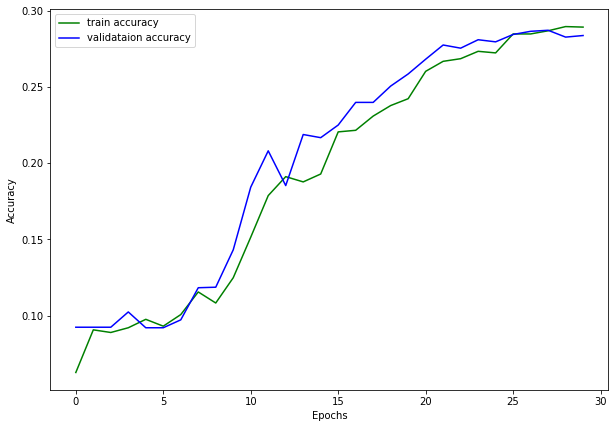

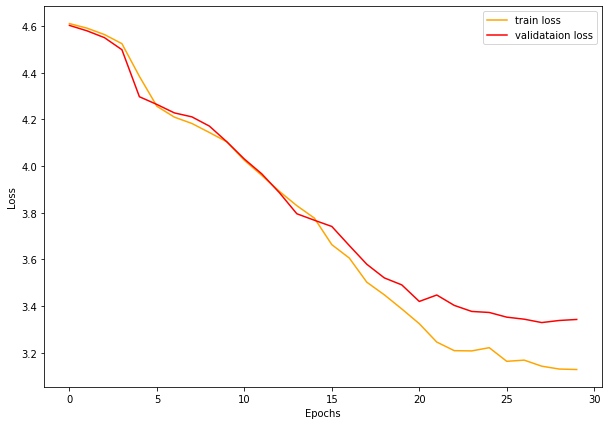


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

Test Accuracy: 0.29934324230902176


In [ ]:
STEP_SIZE = 20
LR = 1e-2
WEIGHT_DECAY = 5e-4 
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet wd4")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-1")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.613016128540039
Step 10, Loss 4.6039862632751465



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.6093, Train Acc: 0.07
Val Loss: 4.6022, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.583140850067139



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.5903, Train Acc: 0.09
Val Loss: 4.5795, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.553617477416992



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.5630, Train Acc: 0.09
Val Loss: 4.5513, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.522138595581055



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.5281, Train Acc: 0.11
Val Loss: 4.5079, Val Acc: 0.11


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.427635192871094



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 4.4133, Train Acc: 0.09
Val Loss: 4.3450, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.206482887268066



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.2661, Train Acc: 0.09
Val Loss: 4.2660, Val Acc: 0.09


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.326328277587891



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.2058, Train Acc: 0.09
Val Loss: 4.2303, Val Acc: 0.09


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.161525726318359



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.1733, Train Acc: 0.12
Val Loss: 4.2087, Val Acc: 0.12


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.22123384475708



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.1445, Train Acc: 0.11
Val Loss: 4.1559, Val Acc: 0.14


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 4.141134738922119



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.0866, Train Acc: 0.14
Val Loss: 4.0903, Val Acc: 0.16


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 3.963273286819458
Step 120, Loss 4.005195140838623



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.0260, Train Acc: 0.15
Val Loss: 4.0268, Val Acc: 0.20


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 4.04910135269165



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.9553, Train Acc: 0.18
Val Loss: 3.9530, Val Acc: 0.21


Starting epoch 13/30, LR = [0.01]
Step 140, Loss 3.8788657188415527



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.8630, Train Acc: 0.20
Val Loss: 3.8585, Val Acc: 0.21


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 3.7974436283111572



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 3.7692, Train Acc: 0.21
Val Loss: 3.7918, Val Acc: 0.22


Starting epoch 15/30, LR = [0.01]
Step 160, Loss 3.8580896854400635



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 3.7200, Train Acc: 0.21
Val Loss: 3.7679, Val Acc: 0.21


Starting epoch 16/30, LR = [0.01]
Step 170, Loss 3.8066742420196533



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.6792, Train Acc: 0.21
Val Loss: 3.6956, Val Acc: 0.22


Starting epoch 17/30, LR = [0.01]
Step 180, Loss 3.601975679397583



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.5737, Train Acc: 0.23
Val Loss: 3.5692, Val Acc: 0.25


Starting epoch 18/30, LR = [0.01]
Step 190, Loss 3.4717342853546143



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.4769, Train Acc: 0.23
Val Loss: 3.5249, Val Acc: 0.26


Starting epoch 19/30, LR = [0.01]
Step 200, Loss 3.6627357006073



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.4425, Train Acc: 0.23
Val Loss: 3.4923, Val Acc: 0.26


Starting epoch 20/30, LR = [0.01]
Step 210, Loss 3.1052017211914062



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.3225, Train Acc: 0.26
Val Loss: 3.4121, Val Acc: 0.26


Starting epoch 21/30, LR = [0.001]
Step 220, Loss 3.2464072704315186
Step 230, Loss 3.090311050415039



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.2261, Train Acc: 0.27
Val Loss: 3.3743, Val Acc: 0.28


Starting epoch 22/30, LR = [0.001]
Step 240, Loss 2.9621167182922363



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 3.1861, Train Acc: 0.28
Val Loss: 3.3791, Val Acc: 0.28


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 3.1791322231292725



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.1629, Train Acc: 0.29
Val Loss: 3.3532, Val Acc: 0.29


Starting epoch 24/30, LR = [0.001]
Step 260, Loss 3.1904032230377197



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.1506, Train Acc: 0.29
Val Loss: 3.3441, Val Acc: 0.29


Starting epoch 25/30, LR = [0.001]
Step 270, Loss 3.387132167816162



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.1300, Train Acc: 0.29
Val Loss: 3.3439, Val Acc: 0.29


Starting epoch 26/30, LR = [0.001]
Step 280, Loss 3.24092173576355



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.1258, Train Acc: 0.29
Val Loss: 3.3428, Val Acc: 0.29


Starting epoch 27/30, LR = [0.001]
Step 290, Loss 3.144117593765259



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.1122, Train Acc: 0.29
Val Loss: 3.3329, Val Acc: 0.29


Starting epoch 28/30, LR = [0.001]
Step 300, Loss 2.8943090438842773



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 3.0879, Train Acc: 0.30
Val Loss: 3.3425, Val Acc: 0.29


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 3.172020435333252



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 3.0869, Train Acc: 0.30
Val Loss: 3.3373, Val Acc: 0.29


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 3.0395641326904297



100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 3.0525, Train Acc: 0.30
Val Loss: 3.3536, Val Acc: 0.29


[(4.60932410847057, 0.0656984785615491), (4.590310270136053, 0.08990318118948824), (4.562993829900568, 0.09370677731673582), (4.528056664900347, 0.11168741355463348), (4.413308186964556, 0.09405255878284924), (4.2661236416209825, 0.088865836791148), (4.20584149794145, 0.09059474412171507), (4.173318256031383, 0.11721991701244813), (4.144493796608665, 0.11307053941908714), (4.086580233140425, 0.1376210235131397), (4.025963653217662, 0.14868603042876902), (3.9553070935336025, 0.17738589211618258), (3.8629972717978736, 0.2036652835408022), (3.7692323597994717, 0.21127247579529737), (3.720030892979015, 0.21127247579529737), (3.679152076894587, 0.21127247579529737), (3.5736631480130283, 0.2306362378976487), (3.4769422574476763, 0.22579529737206086), (3.442478440024636, 0.23443983402489627), (3.322472160512751, 0.26313969571230983), (3.2260760177265513, 0.2697095435684647), (3.186099247498946, 0.2800829875518672), (3.1629

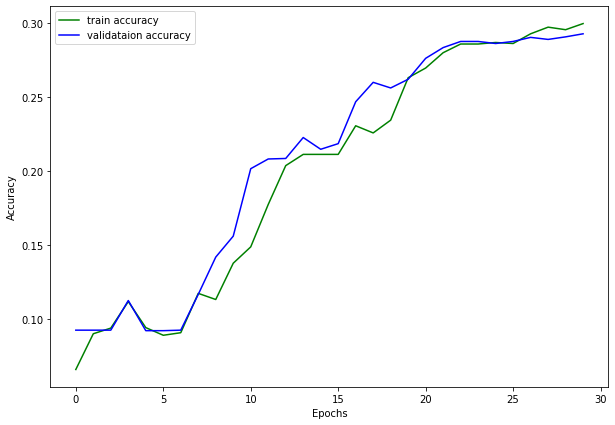

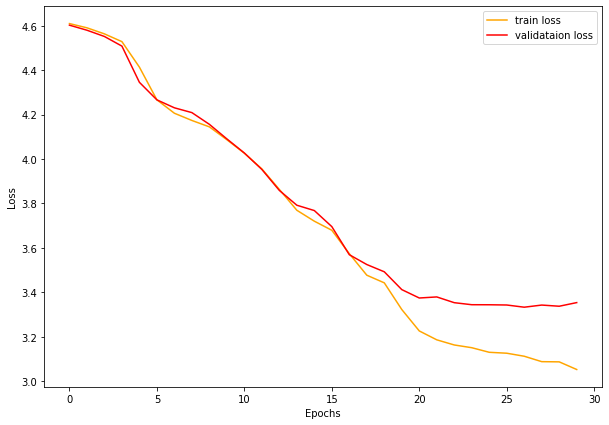


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

Test Accuracy: 0.2920843415139993


In [ ]:
STEP_SIZE = 20
LR = 1e-2
WEIGHT_DECAY = 5e-6
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet wd4")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-1")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.616522789001465
Step 10, Loss 4.6057305335998535



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.6120, Train Acc: 0.04
Val Loss: 4.6042, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.583371639251709



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.5921, Train Acc: 0.10
Val Loss: 4.5793, Val Acc: 0.16


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.548873424530029



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.5611, Train Acc: 0.10
Val Loss: 4.5452, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.503811359405518



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.4951, Train Acc: 0.09
Val Loss: 4.3973, Val Acc: 0.09


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.276574611663818



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.3143, Train Acc: 0.09
Val Loss: 4.3178, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.230733394622803



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.2396, Train Acc: 0.09
Val Loss: 4.2536, Val Acc: 0.09


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.232264518737793



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.2043, Train Acc: 0.09
Val Loss: 4.2258, Val Acc: 0.09


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.254042148590088



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.1705, Train Acc: 0.09
Val Loss: 4.2074, Val Acc: 0.09


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.105324745178223



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.1421, Train Acc: 0.11
Val Loss: 4.1658, Val Acc: 0.15


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 4.243485927581787



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 4.0864, Train Acc: 0.13
Val Loss: 4.0913, Val Acc: 0.15


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 4.266402244567871
Step 120, Loss 3.8899340629577637



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.0304, Train Acc: 0.14
Val Loss: 4.0360, Val Acc: 0.17


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 4.003278732299805



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.9612, Train Acc: 0.17
Val Loss: 4.0073, Val Acc: 0.21


Starting epoch 13/30, LR = [0.01]
Step 140, Loss 3.957044839859009



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 3.9008, Train Acc: 0.19
Val Loss: 3.8715, Val Acc: 0.22


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 3.691288471221924



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.7881, Train Acc: 0.21
Val Loss: 3.8237, Val Acc: 0.22


Starting epoch 15/30, LR = [0.01]
Step 160, Loss 3.871201992034912



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 3.7075, Train Acc: 0.22
Val Loss: 3.8082, Val Acc: 0.22


Starting epoch 16/30, LR = [0.01]
Step 170, Loss 3.629276990890503



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.6500, Train Acc: 0.23
Val Loss: 3.7171, Val Acc: 0.21


Starting epoch 17/30, LR = [0.01]
Step 180, Loss 3.4718575477600098



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.5689, Train Acc: 0.22
Val Loss: 3.6103, Val Acc: 0.23


Starting epoch 18/30, LR = [0.01]
Step 190, Loss 3.5827062129974365



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.5030, Train Acc: 0.23
Val Loss: 3.5320, Val Acc: 0.25


Starting epoch 19/30, LR = [0.01]
Step 200, Loss 3.4725770950317383



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.4084, Train Acc: 0.25
Val Loss: 3.5141, Val Acc: 0.25


Starting epoch 20/30, LR = [0.01]
Step 210, Loss 3.312270402908325



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.3443, Train Acc: 0.25
Val Loss: 3.4815, Val Acc: 0.24


Starting epoch 21/30, LR = [0.002]
Step 220, Loss 3.0926709175109863
Step 230, Loss 3.264169454574585



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.2690, Train Acc: 0.25
Val Loss: 3.3755, Val Acc: 0.27


Starting epoch 22/30, LR = [0.002]
Step 240, Loss 3.2755019664764404



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.1983, Train Acc: 0.28
Val Loss: 3.3683, Val Acc: 0.28


Starting epoch 23/30, LR = [0.002]
Step 250, Loss 3.037292718887329



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 3.1699, Train Acc: 0.28
Val Loss: 3.3273, Val Acc: 0.29


Starting epoch 24/30, LR = [0.002]
Step 260, Loss 3.1535556316375732



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.1331, Train Acc: 0.29
Val Loss: 3.3321, Val Acc: 0.28


Starting epoch 25/30, LR = [0.002]


Step 270, Loss 3.0100088119506836



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 3.1146, Train Acc: 0.29
Val Loss: 3.3357, Val Acc: 0.29


Starting epoch 26/30, LR = [0.002]


Step 280, Loss 3.027698278427124



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.0920, Train Acc: 0.29
Val Loss: 3.2811, Val Acc: 0.29


Starting epoch 27/30, LR = [0.002]
Step 290, Loss 2.777597427368164



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 3.0464, Train Acc: 0.31
Val Loss: 3.2946, Val Acc: 0.29


Starting epoch 28/30, LR = [0.002]


Step 300, Loss 2.9175002574920654



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.0322, Train Acc: 0.30
Val Loss: 3.2814, Val Acc: 0.30


Starting epoch 29/30, LR = [0.002]


Step 310, Loss 2.942457914352417



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.0026, Train Acc: 0.31
Val Loss: 3.2565, Val Acc: 0.30


Starting epoch 30/30, LR = [0.002]
Step 320, Loss 3.1247220039367676



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 2.9894, Train Acc: 0.31
Val Loss: 3.3147, Val Acc: 0.30


[(4.611971161582253, 0.040110650069156296), (4.592094898223877, 0.10027662517289074), (4.56107607754794, 0.10442600276625173), (4.495072018016469, 0.09059474412171507), (4.314299063249067, 0.08713692946058091), (4.2396182146939365, 0.088865836791148), (4.20428297736428, 0.09197786998616875), (4.170510422099721, 0.09232365145228216), (4.142122095281428, 0.10615491009681881), (4.0864432941783555, 0.12966804979253113), (4.030360612002286, 0.1417704011065007), (3.9612112695520576, 0.16666666666666666), (3.9007585048675537, 0.18706777316735823), (3.7881430929357354, 0.21058091286307054), (3.7075158682736484, 0.22130013831258644), (3.6500437476418237, 0.22510373443983403), (3.568873318758878, 0.2157676348547718), (3.5029766776344995, 0.2327109266943292), (3.4083770621906626, 0.25103734439834025), (3.3443305492401123, 0.25380359612724757), (3.268973328850486, 0.25380359612724757), (3.1983014887029473, 0.27627939142461966),

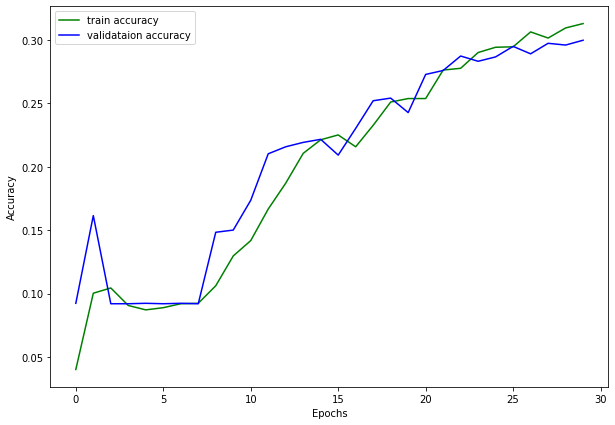

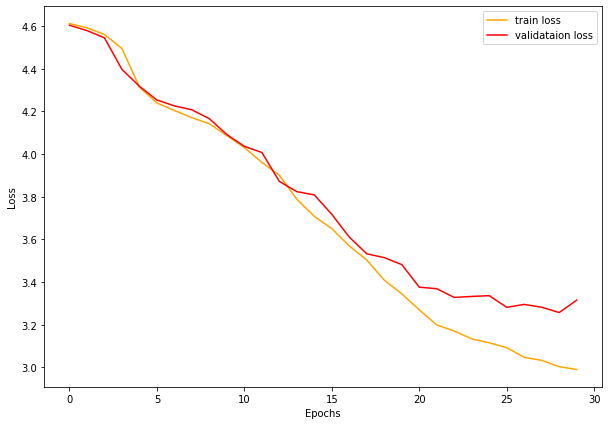


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]

Test Accuracy: 0.30902177670238506


In [ ]:
STEP_SIZE = 20
LR = 1e-2
WEIGHT_DECAY = 5e-5
GAMMA = 0.2
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet wd4")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-1")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.616747856140137
Step 10, Loss 4.60548734664917



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.6121, Train Acc: 0.04
Val Loss: 4.6034, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.579119682312012



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.5924, Train Acc: 0.09
Val Loss: 4.5805, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.563525676727295



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.5655, Train Acc: 0.09
Val Loss: 4.5523, Val Acc: 0.10


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.506174564361572



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 4.5290, Train Acc: 0.11
Val Loss: 4.5101, Val Acc: 0.09


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.41285514831543



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.4152, Train Acc: 0.09
Val Loss: 4.3329, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.226340293884277



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.2608, Train Acc: 0.09
Val Loss: 4.2700, Val Acc: 0.14


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.346126556396484



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 4.2383, Train Acc: 0.09
Val Loss: 4.2399, Val Acc: 0.09


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.2188801765441895



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.1918, Train Acc: 0.09
Val Loss: 4.2133, Val Acc: 0.09


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.071439266204834



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.1591, Train Acc: 0.09
Val Loss: 4.1853, Val Acc: 0.09


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 4.168478965759277



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.1191, Train Acc: 0.12
Val Loss: 4.1389, Val Acc: 0.14


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 4.117929935455322
Step 120, Loss 4.027512550354004



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 4.0632, Train Acc: 0.14
Val Loss: 4.0745, Val Acc: 0.15


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 3.9108994007110596



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.9990, Train Acc: 0.16
Val Loss: 4.0104, Val Acc: 0.20


Starting epoch 13/30, LR = [0.01]
Step 140, Loss 3.9502222537994385



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.9253, Train Acc: 0.18
Val Loss: 3.9649, Val Acc: 0.19


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 3.893230438232422



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.8459, Train Acc: 0.20
Val Loss: 3.8861, Val Acc: 0.21


Starting epoch 15/30, LR = [0.01]
Step 160, Loss 3.7725255489349365



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 3.7511, Train Acc: 0.21
Val Loss: 3.8167, Val Acc: 0.22


Starting epoch 16/30, LR = [0.01]
Step 170, Loss 3.737428903579712



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.6921, Train Acc: 0.21
Val Loss: 3.7257, Val Acc: 0.22


Starting epoch 17/30, LR = [0.01]
Step 180, Loss 3.710968494415283



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 3.6149, Train Acc: 0.23
Val Loss: 3.6351, Val Acc: 0.24


Starting epoch 18/30, LR = [0.01]
Step 190, Loss 3.615804433822632



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.5482, Train Acc: 0.23
Val Loss: 3.6110, Val Acc: 0.25


Starting epoch 19/30, LR = [0.01]
Step 200, Loss 3.302424907684326



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 3.4269, Train Acc: 0.25
Val Loss: 3.4829, Val Acc: 0.27


Starting epoch 20/30, LR = [0.01]
Step 210, Loss 3.5310468673706055



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 3.3534, Train Acc: 0.26
Val Loss: 3.4551, Val Acc: 0.26


Starting epoch 21/30, LR = [0.003]
Step 220, Loss 3.171038866043091
Step 230, Loss 3.1398744583129883



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.2713, Train Acc: 0.27
Val Loss: 3.4144, Val Acc: 0.27


Starting epoch 22/30, LR = [0.003]
Step 240, Loss 3.2009849548339844



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.2156, Train Acc: 0.27
Val Loss: 3.3630, Val Acc: 0.28


Starting epoch 23/30, LR = [0.003]
Step 250, Loss 3.0795676708221436



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 3.1638, Train Acc: 0.28
Val Loss: 3.3662, Val Acc: 0.28


Starting epoch 24/30, LR = [0.003]


Step 260, Loss 3.1725780963897705



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 3.1404, Train Acc: 0.28
Val Loss: 3.4097, Val Acc: 0.29


Starting epoch 25/30, LR = [0.003]


Step 270, Loss 3.06174898147583



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.1206, Train Acc: 0.29
Val Loss: 3.3045, Val Acc: 0.29


Starting epoch 26/30, LR = [0.003]
Step 280, Loss 3.0224525928497314



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 3.0823, Train Acc: 0.29
Val Loss: 3.2827, Val Acc: 0.29


Starting epoch 27/30, LR = [0.003]
Step 290, Loss 3.134875774383545



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.0356, Train Acc: 0.30
Val Loss: 3.2287, Val Acc: 0.30


Starting epoch 28/30, LR = [0.003]
Step 300, Loss 3.101484775543213



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 3.0259, Train Acc: 0.30
Val Loss: 3.2486, Val Acc: 0.29


Starting epoch 29/30, LR = [0.003]


Step 310, Loss 2.863485336303711



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 2.9517, Train Acc: 0.31
Val Loss: 3.1881, Val Acc: 0.31


Starting epoch 30/30, LR = [0.003]
Step 320, Loss 2.8872203826904297



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 2.9211, Train Acc: 0.32
Val Loss: 3.1654, Val Acc: 0.30


[(4.612103375521573, 0.03803596127247579), (4.592409740794789, 0.08852005532503458), (4.5655316873030225, 0.09474412171507607), (4.528973969546231, 0.11134163208852006), (4.4151629968123, 0.09405255878284924), (4.260818264701149, 0.09232365145228216), (4.238299326463179, 0.09024896265560166), (4.191772721030495, 0.09094052558782849), (4.15911323373968, 0.09370677731673582), (4.11911695653742, 0.12033195020746888), (4.063155477697199, 0.1355463347164592), (3.9989604516462847, 0.15525587828492393), (3.9252852960066362, 0.1843015214384509), (3.8459156426516445, 0.1974412171507607), (3.751113869927146, 0.2140387275242047), (3.6920991377397017, 0.21473029045643152), (3.6148664301091973, 0.22544951590594745), (3.548177805813876, 0.22614107883817428), (3.4268992814150723, 0.24619640387275243), (3.3534385941245337, 0.2565698478561549), (3.2713279073888604, 0.26798063623789764), (3.2155691276897085, 0.2697095435684647), (3.1

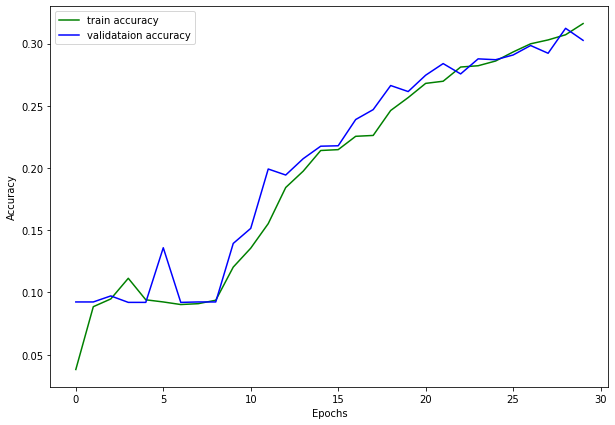

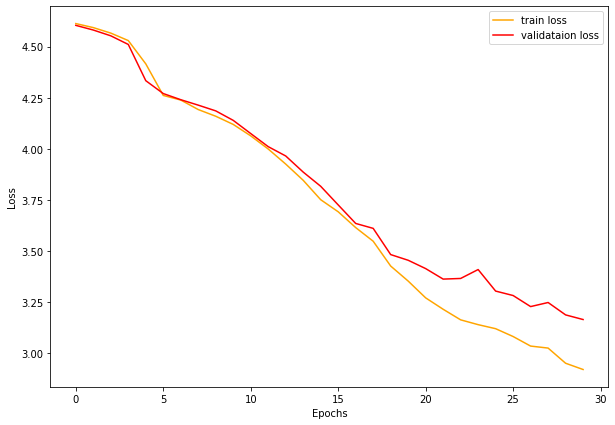


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]

Test Accuracy: 0.31144141030072586


In [ ]:
STEP_SIZE = 20
LR = 1e-2
WEIGHT_DECAY = 5e-5
GAMMA = 0.3
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet wd4")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-1")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.613750457763672
Step 10, Loss 4.602963924407959



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 4.6095, Train Acc: 0.05
Val Loss: 4.6012, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.576956272125244



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.5901, Train Acc: 0.09
Val Loss: 4.5782, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.553624153137207



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 4.5621, Train Acc: 0.09
Val Loss: 4.5486, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.5206780433654785



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.5202, Train Acc: 0.09
Val Loss: 4.4898, Val Acc: 0.09


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.214302062988281



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.3681, Train Acc: 0.09
Val Loss: 4.2971, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.169984817504883



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.2402, Train Acc: 0.09
Val Loss: 4.2553, Val Acc: 0.09


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.129799842834473



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 4.1947, Train Acc: 0.09
Val Loss: 4.2269, Val Acc: 0.14


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.131039619445801



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.1706, Train Acc: 0.11
Val Loss: 4.1933, Val Acc: 0.10


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.174973487854004



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 4.1330, Train Acc: 0.12
Val Loss: 4.1513, Val Acc: 0.13


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 4.003425598144531



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 4.0842, Train Acc: 0.13
Val Loss: 4.0965, Val Acc: 0.18


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 4.024718284606934
Step 120, Loss 4.109174728393555



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 4.0071, Train Acc: 0.17
Val Loss: 4.0044, Val Acc: 0.20


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 3.9534358978271484



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.9225, Train Acc: 0.19
Val Loss: 3.9051, Val Acc: 0.21


Starting epoch 13/30, LR = [0.01]
Step 140, Loss 3.8115692138671875



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.8196, Train Acc: 0.21
Val Loss: 3.8790, Val Acc: 0.21


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 3.6910457611083984



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 3.7414, Train Acc: 0.22
Val Loss: 3.7358, Val Acc: 0.22


Starting epoch 15/30, LR = [0.01]
Step 160, Loss 3.5460617542266846



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 3.6692, Train Acc: 0.22
Val Loss: 3.6806, Val Acc: 0.23


Starting epoch 16/30, LR = [0.01]
Step 170, Loss 3.6203458309173584



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 3.6112, Train Acc: 0.22
Val Loss: 3.6318, Val Acc: 0.24


Starting epoch 17/30, LR = [0.01]
Step 180, Loss 3.704490900039673



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.5224, Train Acc: 0.23
Val Loss: 3.6322, Val Acc: 0.25


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 3.548365592956543



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.4710, Train Acc: 0.24
Val Loss: 3.5221, Val Acc: 0.27


Starting epoch 19/30, LR = [0.01]
Step 200, Loss 3.4413115978240967



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 3.4180, Train Acc: 0.24
Val Loss: 3.5410, Val Acc: 0.27


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 3.0236988067626953



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 3.3294, Train Acc: 0.26
Val Loss: 3.4045, Val Acc: 0.28


Starting epoch 21/30, LR = [0.005]
Step 220, Loss 3.1099414825439453
Step 230, Loss 3.4013798236846924



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.2073, Train Acc: 0.27
Val Loss: 3.3639, Val Acc: 0.28


Starting epoch 22/30, LR = [0.005]
Step 240, Loss 3.124239921569824



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 3.1254, Train Acc: 0.29
Val Loss: 3.2668, Val Acc: 0.30


Starting epoch 23/30, LR = [0.005]
Step 250, Loss 2.921881675720215



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Train Loss: 3.0830, Train Acc: 0.29
Val Loss: 3.2890, Val Acc: 0.29


Starting epoch 24/30, LR = [0.005]


Step 260, Loss 3.1233367919921875



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.0048, Train Acc: 0.32
Val Loss: 3.2259, Val Acc: 0.31


Starting epoch 25/30, LR = [0.005]
Step 270, Loss 3.0817792415618896



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 2.9584, Train Acc: 0.31
Val Loss: 3.2182, Val Acc: 0.31


Starting epoch 26/30, LR = [0.005]
Step 280, Loss 2.896313190460205



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 2.9870, Train Acc: 0.31
Val Loss: 3.6243, Val Acc: 0.27


Starting epoch 27/30, LR = [0.005]


Step 290, Loss 3.1294167041778564



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 2.9517, Train Acc: 0.32
Val Loss: 3.1508, Val Acc: 0.32


Starting epoch 28/30, LR = [0.005]
Step 300, Loss 2.816957712173462



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 2.8244, Train Acc: 0.34
Val Loss: 3.1479, Val Acc: 0.33


Starting epoch 29/30, LR = [0.005]
Step 310, Loss 2.5263736248016357



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 2.7184, Train Acc: 0.35
Val Loss: 3.0731, Val Acc: 0.34


Starting epoch 30/30, LR = [0.005]
Step 320, Loss 2.812023162841797



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 2.6701, Train Acc: 0.37
Val Loss: 2.9530, Val Acc: 0.35


[(4.609499107707631, 0.04944674965421853), (4.590092572298917, 0.088865836791148), (4.5620667284185235, 0.08782849239280774), (4.520181179046631, 0.08990318118948824), (4.368063233115456, 0.08990318118948824), (4.240174987099388, 0.09266943291839558), (4.194669636813077, 0.09301521438450899), (4.170609149065885, 0.10753803596127248), (4.132971546866677, 0.11791147994467496), (4.084200273860585, 0.13243430152143845), (4.007098479704424, 0.17496542185338865), (3.922500415281816, 0.19432918395573998), (3.8195904168215664, 0.21023513139695713), (3.741385741667314, 0.21680497925311204), (3.669168862429532, 0.22372060857538037), (3.611191684549505, 0.21957123098201936), (3.522434624758634, 0.23340248962655602), (3.470978476784446, 0.24343015214384509), (3.418041532689875, 0.24031811894882435), (3.3293506665663286, 0.25622406639004147), (3.207267631183971, 0.27040110650069155), (3.1254173408855093, 0.28526970954356845), (3

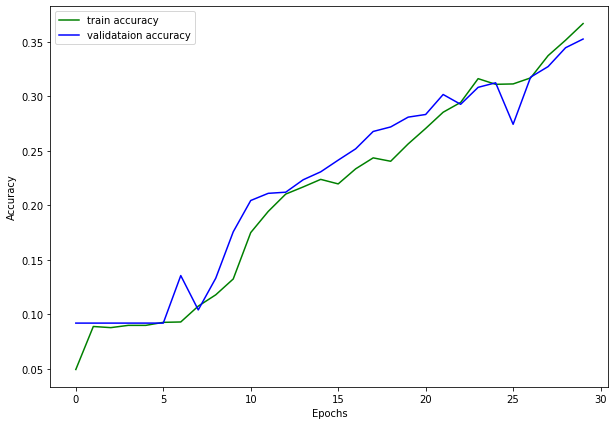

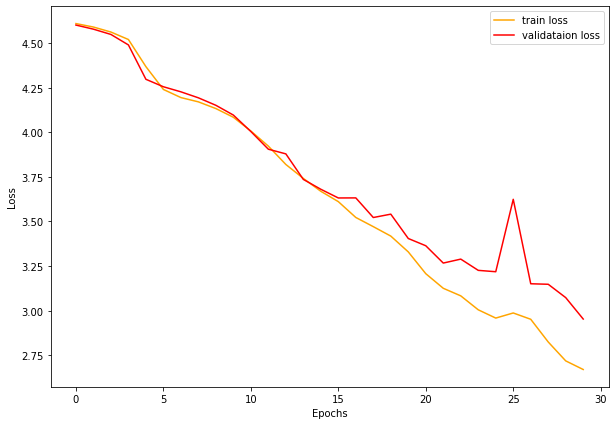


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]

Test Accuracy: 0.36571033529208435


In [ ]:
STEP_SIZE = 20
LR = 1e-2
WEIGHT_DECAY = 5e-5
GAMMA = 0.5
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet wd4")
print_acc_loss(tl,ta,vl,va,"alexnet LR 1e-1")
test(net,test_dataloader)

Starting epoch 1/50, LR = [0.01]
Step 0, Loss 4.613527774810791


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss 4.604912281036377


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]



Train Loss: 4.6099, Train Acc: 0.06
Val Loss: 4.6013, Val Acc: 0.12


Starting epoch 2/50, LR = [0.01]
Step 20, Loss 4.58336067199707


100%|██████████| 12/12 [00:07<00:00,  1.68it/s]



Train Loss: 4.5895, Train Acc: 0.10
Val Loss: 4.5759, Val Acc: 0.09


Starting epoch 3/50, LR = [0.01]
Step 30, Loss 4.552282333374023


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]



Train Loss: 4.5559, Train Acc: 0.09
Val Loss: 4.5348, Val Acc: 0.09


Starting epoch 4/50, LR = [0.01]
Step 40, Loss 4.423772811889648


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]



Train Loss: 4.4402, Train Acc: 0.09
Val Loss: 4.3450, Val Acc: 0.09


Starting epoch 5/50, LR = [0.01]
Step 50, Loss 4.32436466217041


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]



Train Loss: 4.2911, Train Acc: 0.09
Val Loss: 4.2967, Val Acc: 0.09


Starting epoch 6/50, LR = [0.01]
Step 60, Loss 4.2841105461120605


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]



Train Loss: 4.2313, Train Acc: 0.09
Val Loss: 4.2433, Val Acc: 0.09


Starting epoch 7/50, LR = [0.01]
Step 70, Loss 4.175116539001465


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]



Train Loss: 4.2025, Train Acc: 0.10
Val Loss: 4.2344, Val Acc: 0.14


Starting epoch 8/50, LR = [0.01]
Step 80, Loss 4.085348606109619


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]



Train Loss: 4.1582, Train Acc: 0.11
Val Loss: 4.1902, Val Acc: 0.14


Starting epoch 9/50, LR = [0.01]
Step 90, Loss 4.038297653198242


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]



Train Loss: 4.1229, Train Acc: 0.13
Val Loss: 4.1420, Val Acc: 0.15


Starting epoch 10/50, LR = [0.01]
Step 100, Loss 4.13338041305542


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]



Train Loss: 4.0708, Train Acc: 0.14
Val Loss: 4.0796, Val Acc: 0.16


Starting epoch 11/50, LR = [0.001]
Step 110, Loss 4.036531448364258


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss 4.148172378540039


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]



Train Loss: 4.0199, Train Acc: 0.15
Val Loss: 4.0615, Val Acc: 0.17


Starting epoch 12/50, LR = [0.001]
Step 130, Loss 3.9978392124176025


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 4.0033, Train Acc: 0.15
Val Loss: 4.0564, Val Acc: 0.18


Starting epoch 13/50, LR = [0.001]
Step 140, Loss 3.916468381881714


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 4.0018, Train Acc: 0.15
Val Loss: 4.0459, Val Acc: 0.18


Starting epoch 14/50, LR = [0.001]
Step 150, Loss 4.072349548339844


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]



Train Loss: 3.9968, Train Acc: 0.15
Val Loss: 4.0371, Val Acc: 0.19


Starting epoch 15/50, LR = [0.001]
Step 160, Loss 3.956603765487671


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]



Train Loss: 3.9799, Train Acc: 0.16
Val Loss: 4.0288, Val Acc: 0.19


Starting epoch 16/50, LR = [0.001]
Step 170, Loss 4.064093112945557


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.9695, Train Acc: 0.16
Val Loss: 4.0194, Val Acc: 0.20


Starting epoch 17/50, LR = [0.001]
Step 180, Loss 3.957268714904785


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.9705, Train Acc: 0.16
Val Loss: 4.0133, Val Acc: 0.20


Starting epoch 18/50, LR = [0.001]
Step 190, Loss 4.062797546386719


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.9632, Train Acc: 0.17
Val Loss: 3.9994, Val Acc: 0.20


Starting epoch 19/50, LR = [0.001]
Step 200, Loss 3.9054856300354004


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]



Train Loss: 3.9418, Train Acc: 0.17
Val Loss: 3.9928, Val Acc: 0.21


Starting epoch 20/50, LR = [0.001]
Step 210, Loss 3.859801769256592


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.9305, Train Acc: 0.18
Val Loss: 3.9805, Val Acc: 0.21


Starting epoch 21/50, LR = [0.0001]
Step 220, Loss 3.8444762229919434
Step 230, Loss 3.8135313987731934


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.9290, Train Acc: 0.18
Val Loss: 3.9795, Val Acc: 0.21


Starting epoch 22/50, LR = [0.0001]
Step 240, Loss 3.8990163803100586


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 3.9207, Train Acc: 0.19
Val Loss: 3.9779, Val Acc: 0.21


Starting epoch 23/50, LR = [0.0001]
Step 250, Loss 4.001888751983643


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]



Train Loss: 3.9096, Train Acc: 0.19
Val Loss: 3.9767, Val Acc: 0.21


Starting epoch 24/50, LR = [0.0001]
Step 260, Loss 3.817161798477173


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 3.9142, Train Acc: 0.18
Val Loss: 3.9750, Val Acc: 0.21


Starting epoch 25/50, LR = [0.0001]
Step 270, Loss 4.042959690093994


100%|██████████| 12/12 [00:07<00:00,  1.59it/s]



Train Loss: 3.9253, Train Acc: 0.19
Val Loss: 3.9743, Val Acc: 0.21


Starting epoch 26/50, LR = [0.0001]
Step 280, Loss 3.886894464492798


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 3.9172, Train Acc: 0.19
Val Loss: 3.9738, Val Acc: 0.21


Starting epoch 27/50, LR = [0.0001]
Step 290, Loss 3.9741408824920654


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]



Train Loss: 3.9102, Train Acc: 0.19
Val Loss: 3.9721, Val Acc: 0.21


Starting epoch 28/50, LR = [0.0001]
Step 300, Loss 4.031684398651123


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]



Train Loss: 3.9232, Train Acc: 0.18
Val Loss: 3.9711, Val Acc: 0.21


Starting epoch 29/50, LR = [0.0001]
Step 310, Loss 3.8094382286071777


100%|██████████| 12/12 [00:07<00:00,  1.59it/s]



Train Loss: 3.9091, Train Acc: 0.19
Val Loss: 3.9700, Val Acc: 0.21


Starting epoch 30/50, LR = [0.0001]
Step 320, Loss 3.8101205825805664


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]



Train Loss: 3.9154, Train Acc: 0.19
Val Loss: 3.9688, Val Acc: 0.21


Starting epoch 31/50, LR = [1e-05]
Step 330, Loss 4.061245441436768


  0%|          | 0/12 [00:00<?, ?it/s]

Step 340, Loss 3.8690547943115234


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]



Train Loss: 3.9102, Train Acc: 0.19
Val Loss: 3.9687, Val Acc: 0.21


Starting epoch 32/50, LR = [1e-05]
Step 350, Loss 3.9129505157470703


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]



Train Loss: 3.9148, Train Acc: 0.19
Val Loss: 3.9686, Val Acc: 0.21


Starting epoch 33/50, LR = [1e-05]
Step 360, Loss 3.942887783050537


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.9054, Train Acc: 0.19
Val Loss: 3.9684, Val Acc: 0.21


Starting epoch 34/50, LR = [1e-05]
Step 370, Loss 3.9981870651245117


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.9145, Train Acc: 0.19
Val Loss: 3.9683, Val Acc: 0.21


Starting epoch 35/50, LR = [1e-05]
Step 380, Loss 4.077387809753418


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]



Train Loss: 3.9185, Train Acc: 0.19
Val Loss: 3.9682, Val Acc: 0.21


Starting epoch 36/50, LR = [1e-05]
Step 390, Loss 3.7662782669067383


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 3.9159, Train Acc: 0.19
Val Loss: 3.9680, Val Acc: 0.21


Starting epoch 37/50, LR = [1e-05]
Step 400, Loss 3.9142110347747803


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.9141, Train Acc: 0.19
Val Loss: 3.9679, Val Acc: 0.21


Starting epoch 38/50, LR = [1e-05]
Step 410, Loss 3.9647531509399414


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.9073, Train Acc: 0.18
Val Loss: 3.9678, Val Acc: 0.21


Starting epoch 39/50, LR = [1e-05]
Step 420, Loss 3.7302634716033936


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]



Train Loss: 3.9175, Train Acc: 0.19
Val Loss: 3.9677, Val Acc: 0.21


Starting epoch 40/50, LR = [1e-05]
Step 430, Loss 3.9258792400360107


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.9087, Train Acc: 0.19
Val Loss: 3.9675, Val Acc: 0.21


Starting epoch 41/50, LR = [1.0000000000000002e-06]
Step 440, Loss 3.9650282859802246


  0%|          | 0/12 [00:00<?, ?it/s]

Step 450, Loss 4.0082502365112305


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 3.9154, Train Acc: 0.19
Val Loss: 3.9675, Val Acc: 0.21


Starting epoch 42/50, LR = [1.0000000000000002e-06]
Step 460, Loss 3.908257484436035


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]



Train Loss: 3.9066, Train Acc: 0.19
Val Loss: 3.9675, Val Acc: 0.21


Starting epoch 43/50, LR = [1.0000000000000002e-06]
Step 470, Loss 3.8243117332458496


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.9123, Train Acc: 0.19
Val Loss: 3.9675, Val Acc: 0.21


Starting epoch 44/50, LR = [1.0000000000000002e-06]
Step 480, Loss 3.8721907138824463


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]



Train Loss: 3.9118, Train Acc: 0.19
Val Loss: 3.9675, Val Acc: 0.21


Starting epoch 45/50, LR = [1.0000000000000002e-06]
Step 490, Loss 4.088067054748535


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 3.9181, Train Acc: 0.19
Val Loss: 3.9675, Val Acc: 0.21


Starting epoch 46/50, LR = [1.0000000000000002e-06]
Step 500, Loss 4.015997409820557


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]



Train Loss: 3.9072, Train Acc: 0.19
Val Loss: 3.9675, Val Acc: 0.21


Starting epoch 47/50, LR = [1.0000000000000002e-06]
Step 510, Loss 3.7224936485290527


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]



Train Loss: 3.9149, Train Acc: 0.19
Val Loss: 3.9674, Val Acc: 0.21


Starting epoch 48/50, LR = [1.0000000000000002e-06]
Step 520, Loss 4.0051374435424805


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]



Train Loss: 3.9156, Train Acc: 0.18
Val Loss: 3.9674, Val Acc: 0.21


Starting epoch 49/50, LR = [1.0000000000000002e-06]
Step 530, Loss 3.977882146835327


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 3.9238, Train Acc: 0.19
Val Loss: 3.9674, Val Acc: 0.21


Starting epoch 50/50, LR = [1.0000000000000002e-06]
Step 540, Loss 3.787508964538574


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]



Train Loss: 3.9269, Train Acc: 0.19
Val Loss: 3.9674, Val Acc: 0.21


[(4.6099327694286, 0.05774550484094053), (4.589537577195601, 0.09820193637621023), (4.55587218024514, 0.0912863070539419), (4.4402313232421875, 0.08921161825726141), (4.291068900715221, 0.08852005532503458), (4.231282190843062, 0.09232365145228216), (4.202450405467641, 0.09612724757952974), (4.158209280534224, 0.10684647302904564), (4.122939890081232, 0.12932226832641772), (4.070824839852073, 0.13934993084370678), (4.019853483546864, 0.14522821576763487), (4.003335280851885, 0.1504149377593361), (4.001781073483554, 0.14695712309820194), (3.9967967813665215, 0.1507607192254495), (3.9799043482000176, 0.15629322268326418), (3.969549049030651, 0.1628630705394191), (3.9705159664154053, 0.16217150760719226), (3.9632221568714487, 0.17081604426002767), (3.941795154051347, 0.16701244813278007), (3.930528228933161, 0.17911479944674966), (3.929009806026112, 0.18464730290456433), (3.9206947196613657, 0.18948824343015214), (3.90

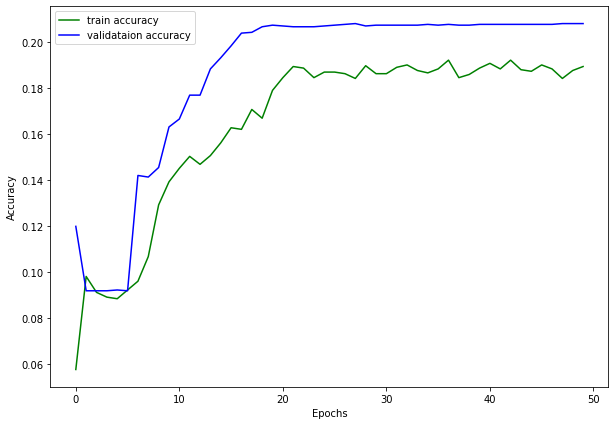

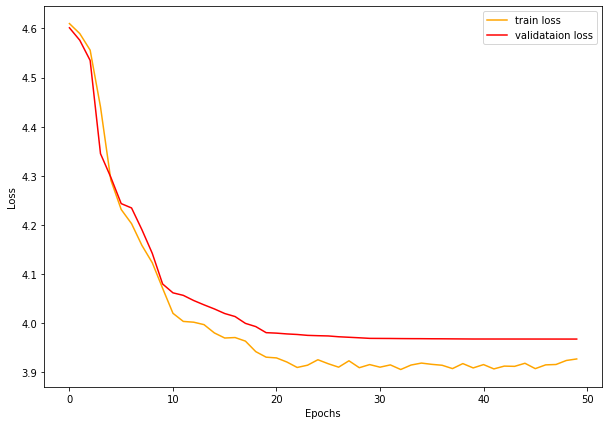

100%|██████████| 12/12 [00:07<00:00,  1.59it/s]

Test Accuracy: 0.2049775319737297


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet_hp_test") 
print_acc_loss(tl,ta,vl,va,"alexnet_hp_test")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.616091728210449


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss 4.6053009033203125


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 4.6123, Train Acc: 0.03
Val Loss: 4.6032, Val Acc: 0.09


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.581418514251709


100%|██████████| 12/12 [00:07<00:00,  1.63it/s]



Train Loss: 4.5917, Train Acc: 0.09
Val Loss: 4.5782, Val Acc: 0.09


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.543959140777588


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 4.5598, Train Acc: 0.09
Val Loss: 4.5395, Val Acc: 0.09


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.4282755851745605


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 4.4538, Train Acc: 0.09
Val Loss: 4.3096, Val Acc: 0.09


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.27964973449707


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 4.2657, Train Acc: 0.10
Val Loss: 4.2708, Val Acc: 0.09


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.19707727432251


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]



Train Loss: 4.2103, Train Acc: 0.09
Val Loss: 4.2348, Val Acc: 0.09


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.2158002853393555


100%|██████████| 12/12 [00:07<00:00,  1.59it/s]



Train Loss: 4.1732, Train Acc: 0.10
Val Loss: 4.2014, Val Acc: 0.15


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.169710159301758


100%|██████████| 12/12 [00:07<00:00,  1.63it/s]



Train Loss: 4.1530, Train Acc: 0.11
Val Loss: 4.1619, Val Acc: 0.14


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.143490314483643


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]



Train Loss: 4.1078, Train Acc: 0.13
Val Loss: 4.1091, Val Acc: 0.18


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 3.8724851608276367


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 4.0405, Train Acc: 0.16
Val Loss: 4.0209, Val Acc: 0.20


Starting epoch 11/30, LR = [0.001]
Step 110, Loss 4.051764488220215
Step 120, Loss 3.839794635772705


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Train Loss: 3.9803, Train Acc: 0.17
Val Loss: 4.0402, Val Acc: 0.20


Starting epoch 12/30, LR = [0.001]


Step 130, Loss 3.9518754482269287


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]



Train Loss: 3.9614, Train Acc: 0.18
Val Loss: 4.0020, Val Acc: 0.20


Starting epoch 13/30, LR = [0.001]
Step 140, Loss 3.8606505393981934


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.9541, Train Acc: 0.19
Val Loss: 3.9978, Val Acc: 0.20


Starting epoch 14/30, LR = [0.001]
Step 150, Loss 4.155269622802734


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.9534, Train Acc: 0.19
Val Loss: 3.9843, Val Acc: 0.20


Starting epoch 15/30, LR = [0.001]
Step 160, Loss 3.9550814628601074


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]



Train Loss: 3.9378, Train Acc: 0.19
Val Loss: 3.9677, Val Acc: 0.21


Starting epoch 16/30, LR = [0.001]
Step 170, Loss 3.9663126468658447


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 3.9239, Train Acc: 0.19
Val Loss: 3.9584, Val Acc: 0.20


Starting epoch 17/30, LR = [0.001]
Step 180, Loss 3.9130942821502686


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.9056, Train Acc: 0.19
Val Loss: 3.9389, Val Acc: 0.21


Starting epoch 18/30, LR = [0.001]
Step 190, Loss 3.8795180320739746


100%|██████████| 12/12 [00:07<00:00,  1.59it/s]



Train Loss: 3.8890, Train Acc: 0.20
Val Loss: 3.9198, Val Acc: 0.21


Starting epoch 19/30, LR = [0.001]
Step 200, Loss 3.86122465133667


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.8791, Train Acc: 0.20
Val Loss: 3.9075, Val Acc: 0.21


Starting epoch 20/30, LR = [0.001]
Step 210, Loss 3.942202091217041


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 3.8598, Train Acc: 0.20
Val Loss: 3.8884, Val Acc: 0.22


Starting epoch 21/30, LR = [0.0001]
Step 220, Loss 3.8105340003967285


  0%|          | 0/12 [00:00<?, ?it/s]

Step 230, Loss 3.6804752349853516


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 3.8546, Train Acc: 0.20
Val Loss: 3.8869, Val Acc: 0.22


Starting epoch 22/30, LR = [0.0001]
Step 240, Loss 3.9020299911499023


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]



Train Loss: 3.8473, Train Acc: 0.20
Val Loss: 3.8858, Val Acc: 0.22


Starting epoch 23/30, LR = [0.0001]
Step 250, Loss 3.9290497303009033


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 3.8443, Train Acc: 0.20
Val Loss: 3.8838, Val Acc: 0.22


Starting epoch 24/30, LR = [0.0001]
Step 260, Loss 3.9754321575164795


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]



Train Loss: 3.8370, Train Acc: 0.20
Val Loss: 3.8811, Val Acc: 0.22


Starting epoch 25/30, LR = [0.0001]
Step 270, Loss 3.751875400543213


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.8412, Train Acc: 0.20
Val Loss: 3.8790, Val Acc: 0.22


Starting epoch 26/30, LR = [0.0001]
Step 280, Loss 3.960400104522705


100%|██████████| 12/12 [00:07<00:00,  1.59it/s]



Train Loss: 3.8361, Train Acc: 0.21
Val Loss: 3.8775, Val Acc: 0.22


Starting epoch 27/30, LR = [0.0001]
Step 290, Loss 3.7741611003875732


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]



Train Loss: 3.8423, Train Acc: 0.20
Val Loss: 3.8765, Val Acc: 0.22


Starting epoch 28/30, LR = [0.0001]
Step 300, Loss 4.009143829345703


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 3.8410, Train Acc: 0.21
Val Loss: 3.8747, Val Acc: 0.22


Starting epoch 29/30, LR = [0.0001]
Step 310, Loss 3.7718403339385986


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]



Train Loss: 3.8324, Train Acc: 0.21
Val Loss: 3.8724, Val Acc: 0.22


Starting epoch 30/30, LR = [0.0001]
Step 320, Loss 3.887653350830078


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]



Train Loss: 3.8346, Train Acc: 0.20
Val Loss: 3.8701, Val Acc: 0.22


[(4.612336895682595, 0.03284923928077455), (4.5916830843145195, 0.08955739972337483), (4.559762434525923, 0.09163208852005532), (4.453780781139027, 0.08852005532503458), (4.265732331709429, 0.0975103734439834), (4.2103118896484375, 0.09024896265560166), (4.173217209902677, 0.10062240663900415), (4.152999184348366, 0.10753803596127248), (4.1077869805422695, 0.12621023513139695), (4.040483084591952, 0.15767634854771784), (3.980307839133523, 0.1739280774550484), (3.9613923593000933, 0.18499308437067774), (3.9540777423165063, 0.18706777316735823), (3.9533527114174585, 0.1884508990318119), (3.9377997571771797, 0.19017980636237897), (3.923928672617132, 0.18706777316735823), (3.9056482965295967, 0.19225449515905949), (3.8889518000862817, 0.19640387275242047), (3.879069848494096, 0.2033195020746888), (3.85983191836964, 0.20262793914246197), (3.854586796327071, 0.2033195020746888), (3.8473029786890205, 0.1970954356846473), (

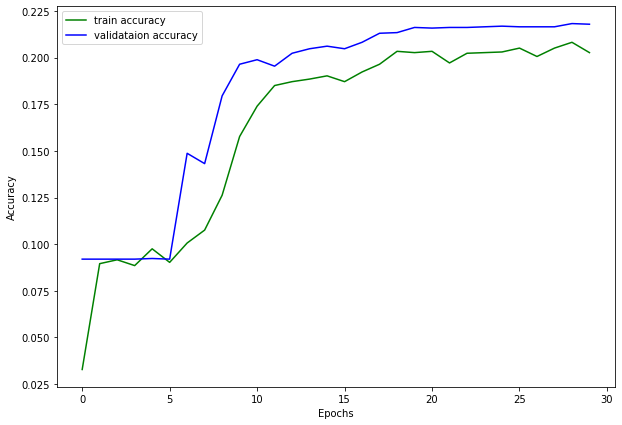

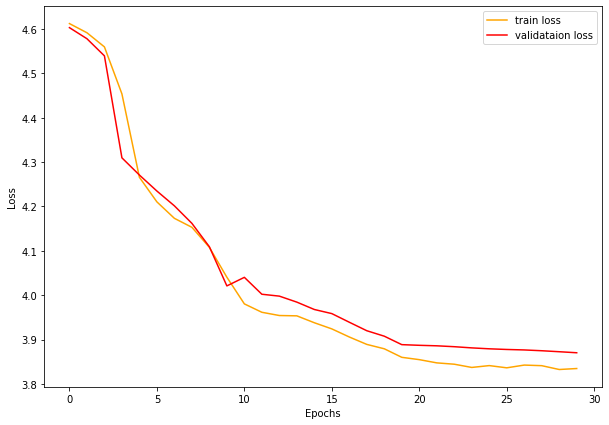

100%|██████████| 12/12 [00:07<00:00,  1.60it/s]

Test Accuracy: 0.2153473902523332


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

optimizer = optim.Adam(net.parameters(), lr=LR)
net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="alexnet_hp_test2")
print_acc_loss(tl,ta,vl,va,"alexnet_hp_test2")
test(net,test_dataloader)

*Transfer learning*

In [ ]:
BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=preprocess)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.90841817855835
Step 10, Loss 3.3557753562927246


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.1014, Train Acc: 0.16
Val Loss: 3.2435, Val Acc: 0.30


Starting epoch 2/30, LR = [0.001]
Step 20, Loss 2.726550817489624


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 2.8288, Train Acc: 0.37
Val Loss: 2.4790, Val Acc: 0.48


Starting epoch 3/30, LR = [0.001]
Step 30, Loss 1.754478931427002


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 2.0216, Train Acc: 0.54
Val Loss: 1.7774, Val Acc: 0.60


Starting epoch 4/30, LR = [0.001]
Step 40, Loss 1.1566855907440186


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 1.3116, Train Acc: 0.67
Val Loss: 1.2329, Val Acc: 0.70


Starting epoch 5/30, LR = [0.001]
Step 50, Loss 0.7300903797149658


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 0.7995, Train Acc: 0.78
Val Loss: 0.9114, Val Acc: 0.77


Starting epoch 6/30, LR = [0.001]
Step 60, Loss 0.43251150846481323


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 0.4996, Train Acc: 0.85
Val Loss: 0.8023, Val Acc: 0.79


Starting epoch 7/30, LR = [0.001]
Step 70, Loss 0.35762929916381836


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 0.3602, Train Acc: 0.88
Val Loss: 0.7423, Val Acc: 0.81


Starting epoch 8/30, LR = [0.001]
Step 80, Loss 0.26484715938568115


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 0.2508, Train Acc: 0.91
Val Loss: 0.7183, Val Acc: 0.81


Starting epoch 9/30, LR = [0.001]
Step 90, Loss 0.16495545208454132


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1809, Train Acc: 0.93
Val Loss: 0.7212, Val Acc: 0.81


Starting epoch 10/30, LR = [0.001]


Step 100, Loss 0.13268589973449707


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 0.1350, Train Acc: 0.94
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 11/30, LR = [0.001]
Step 110, Loss 0.0827455222606659
Step 120, Loss 0.13092578947544098


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1017, Train Acc: 0.95
Val Loss: 0.7290, Val Acc: 0.81


Starting epoch 12/30, LR = [0.001]


Step 130, Loss 0.08203569054603577


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0927, Train Acc: 0.95
Val Loss: 0.7340, Val Acc: 0.82


Starting epoch 13/30, LR = [0.001]


Step 140, Loss 0.12055964767932892


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0827, Train Acc: 0.95
Val Loss: 0.7700, Val Acc: 0.81


Starting epoch 14/30, LR = [0.001]


Step 150, Loss 0.13301941752433777


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0727, Train Acc: 0.95
Val Loss: 0.8085, Val Acc: 0.80


Starting epoch 15/30, LR = [0.001]


Step 160, Loss 0.09596359729766846


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0788, Train Acc: 0.96
Val Loss: 0.7859, Val Acc: 0.80


Early stopping!
Starting epoch 16/30, LR = [0.001]


Step 170, Loss 0.10617123544216156


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1042, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 17/30, LR = [0.001]


Step 180, Loss 0.10821110755205154


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1081, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 18/30, LR = [0.001]


Step 190, Loss 0.12236852943897247


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1020, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 19/30, LR = [0.001]


Step 200, Loss 0.15431630611419678


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1056, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 20/30, LR = [0.001]


Step 210, Loss 0.08174867928028107


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1002, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 21/30, LR = [0.0001]


Step 220, Loss 0.09048489481210709
Step 230, Loss 0.07227146625518799


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1022, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 22/30, LR = [0.0001]


Step 240, Loss 0.07484126091003418


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1120, Train Acc: 0.94
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 23/30, LR = [0.0001]


Step 250, Loss 0.08702707290649414


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1034, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 24/30, LR = [0.0001]


Step 260, Loss 0.07783377170562744


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1031, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 25/30, LR = [0.0001]


Step 270, Loss 0.08876865357160568


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0984, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 26/30, LR = [0.0001]


Step 280, Loss 0.09206157177686691


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0954, Train Acc: 0.96
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 27/30, LR = [0.0001]


Step 290, Loss 0.16311807930469513


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1015, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 28/30, LR = [0.0001]


Step 300, Loss 0.16798949241638184


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1046, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 29/30, LR = [0.0001]


Step 310, Loss 0.10430242121219635


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1031, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 30/30, LR = [0.0001]


Step 320, Loss 0.10036469995975494


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 0.0997, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


[(4.101367928765037, 0.15836791147994467), (2.8288139429959385, 0.36618257261410786), (2.0216328772631558, 0.5356154910096819), (1.3116493929516186, 0.6697786998616874), (0.7994942285797813, 0.7752420470262794), (0.49963533878326416, 0.8499308437067773), (0.36022414673458447, 0.8751728907330567), (0.25076374276117847, 0.9076763485477178), (0.18086750669912857, 0.9253112033195021), (0.13500359451228922, 0.9374135546334716), (0.10170386867089705, 0.950207468879668), (0.09268658811395819, 0.9457123098201936), (0.08274627070535313, 0.9519363762102351), (0.07274959337982265, 0.9526279391424619), (0.07883296500552785, 0.9550484094052559), (0.10420273853973909, 0.9498616874135546), (0.10813846100460399, 0.9477869986168741), (0.10200497914444316, 0.9484785615491009), (0.10558375783941963, 0.9491701244813278), (0.1002064895900813, 0.9474412171507607), (0.10217509554191069, 0.9488243430152143), (0.11203393543308432, 0.9446749

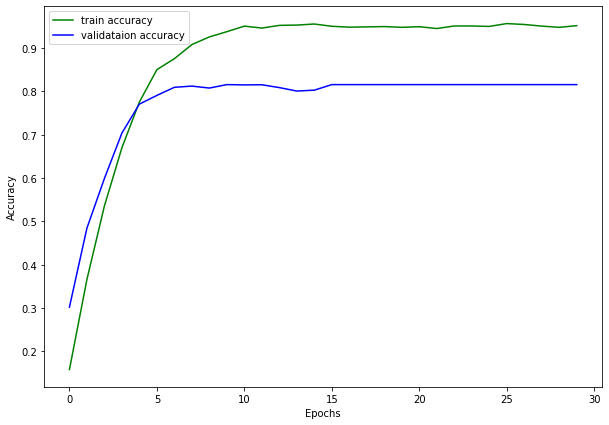

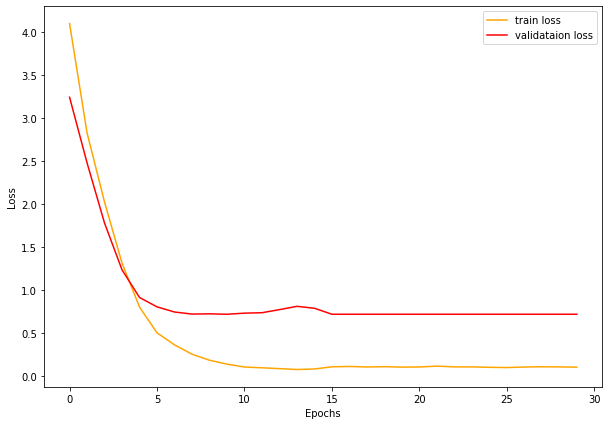

100%|██████████| 12/12 [00:09<00:00,  1.25it/s]

Test Accuracy: 0.8112685793294159


In [ ]:
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.1]
Step 0, Loss 4.888488292694092
Step 10, Loss nan


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: nan, Train Acc: 0.05
Val Loss: nan, Val Acc: 0.01


Starting epoch 2/30, LR = [0.1]


Step 20, Loss nan


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: nan, Train Acc: 0.01
Val Loss: nan, Val Acc: 0.01


Starting epoch 3/30, LR = [0.1]


Step 30, Loss nan


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: nan, Train Acc: 0.01
Val Loss: nan, Val Acc: 0.01


Starting epoch 4/30, LR = [0.1]


Step 40, Loss nan


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: nan, Train Acc: 0.01
Val Loss: nan, Val Acc: 0.01


Starting epoch 5/30, LR = [0.1]


Step 50, Loss nan


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: nan, Train Acc: 0.01
Val Loss: nan, Val Acc: 0.01


Early stopping!
Starting epoch 6/30, LR = [0.1]


Step 60, Loss 0.08642872422933578


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 0.0975, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 7/30, LR = [0.1]
Step 70, Loss 0.11999566853046417


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1031, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 8/30, LR = [0.1]


Step 80, Loss 0.097417451441288


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1020, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 9/30, LR = [0.1]


Step 90, Loss 0.09768974781036377


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1065, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 10/30, LR = [0.1]


Step 100, Loss 0.08589664846658707


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1019, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 11/30, LR = [0.1]


Step 110, Loss 0.12242823839187622
Step 120, Loss 0.09197147190570831


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.1082, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Early stopping!
Starting epoch 12/30, LR = [0.1]
Step 130, Loss 0.12178854644298553


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1112, Train Acc: 0.94
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 13/30, LR = [0.1]


Step 140, Loss 0.13689742982387543


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1073, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 14/30, LR = [0.1]


Step 150, Loss 0.09771940112113953


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1023, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 15/30, LR = [0.1]


Step 160, Loss 0.07133928686380386


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1075, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 16/30, LR = [0.1]


Step 170, Loss 0.10388820618391037


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1080, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 17/30, LR = [0.1]


Step 180, Loss 0.08385498076677322


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1080, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 18/30, LR = [0.1]


Step 190, Loss 0.09767881780862808


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1046, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 19/30, LR = [0.1]


Step 200, Loss 0.1176772266626358


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1045, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 20/30, LR = [0.1]


Step 210, Loss 0.09461967647075653


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1014, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 21/30, LR = [0.010000000000000002]


Step 220, Loss 0.10025166720151901
Step 230, Loss 0.08806396275758743


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1043, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 22/30, LR = [0.010000000000000002]


Step 240, Loss 0.11482354998588562


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1035, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 23/30, LR = [0.010000000000000002]


Step 250, Loss 0.11106476187705994


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1044, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 24/30, LR = [0.010000000000000002]


Step 260, Loss 0.08528725057840347


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 0.1032, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 25/30, LR = [0.010000000000000002]


Step 270, Loss 0.11112429201602936


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 0.1039, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 26/30, LR = [0.010000000000000002]


Step 280, Loss 0.08651840686798096


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 0.1024, Train Acc: 0.96
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 27/30, LR = [0.010000000000000002]


Step 290, Loss 0.08840960264205933


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1056, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 28/30, LR = [0.010000000000000002]


Step 300, Loss 0.1312730312347412


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1068, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 29/30, LR = [0.010000000000000002]


Step 310, Loss 0.10191993415355682


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1037, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


Starting epoch 30/30, LR = [0.010000000000000002]


Step 320, Loss 0.157345712184906


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 0.0995, Train Acc: 0.95
Val Loss: 0.7162, Val Acc: 0.82


[(nan, 0.052904564315352696), (nan, 0.006224066390041493), (nan, 0.005878284923928077), (nan, 0.005878284923928077), (nan, 0.006224066390041493), (0.09746238995682109, 0.9536652835408023), (0.10306132246147502, 0.9505532503457814), (0.10203437236222354, 0.9505532503457814), (0.10645816068757664, 0.9470954356846473), (0.10193149880929427, 0.9508990318118948), (0.10822269997813484, 0.9491701244813278), (0.11116887154904279, 0.9415629322268326), (0.10725621269507842, 0.9498616874135546), (0.1022648885846138, 0.9474412171507607), (0.10745216364210303, 0.9481327800829875), (0.10799883576956662, 0.9505532503457814), (0.10799299722368066, 0.9505532503457814), (0.10455123741518367, 0.9481327800829875), (0.10452635789459402, 0.9470954356846473), (0.10141974484378641, 0.9515905947441217), (0.1043323203921318, 0.9495159059474412), (0.1034643751653758, 0.950207468879668), (0.1044196445833553, 0.9488243430152143), (0.10320737348

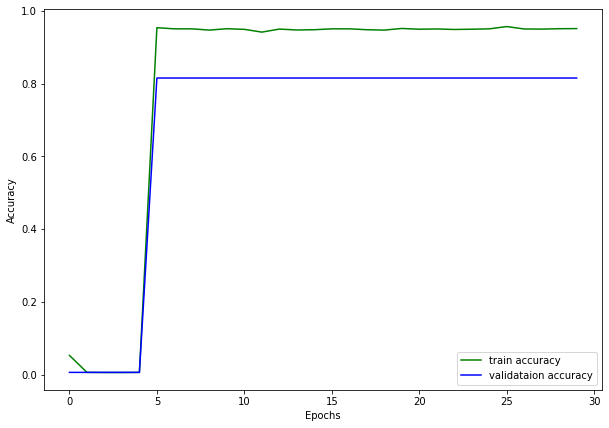

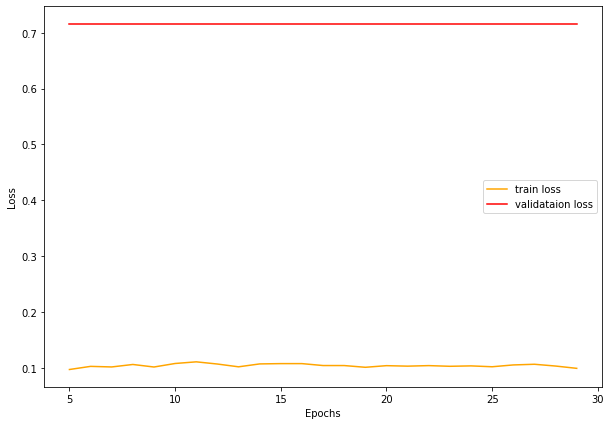

100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

Test Accuracy: 0.8112685793294159


In [ ]:
LR = 1e-1
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.825628280639648
Step 10, Loss 1.7672092914581299



100%|██████████| 12/12 [00:09<00:00,  1.22it/s]



Train Loss: 2.9791, Train Acc: 0.36
Val Loss: 1.5640, Val Acc: 0.63


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.7783993482589722



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 0.8297, Train Acc: 0.76
Val Loss: 0.8352, Val Acc: 0.78


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.2884191870689392



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 0.3510, Train Acc: 0.88
Val Loss: 0.8134, Val Acc: 0.80


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.2170790582895279



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 0.1959, Train Acc: 0.92
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 0.06616005301475525



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0905, Train Acc: 0.95
Val Loss: 0.8548, Val Acc: 0.80


Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.044519487768411636



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0436, Train Acc: 0.96
Val Loss: 0.9078, Val Acc: 0.82


Starting epoch 7/30, LR = [0.01]


Step 70, Loss 0.026549499481916428



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0453, Train Acc: 0.96
Val Loss: 0.8648, Val Acc: 0.82


Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.04011528193950653



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0378, Train Acc: 0.96
Val Loss: 0.8507, Val Acc: 0.83


Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.015503406524658203



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0228, Train Acc: 0.97
Val Loss: 0.8796, Val Acc: 0.83


Early stopping!
Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.0472714938223362



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0831, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.07771582901477814
Step 120, Loss 0.06083949655294418



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0911, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.06270669400691986



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0827, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.05361612141132355



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0826, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.08573122322559357



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0901, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.10942001640796661



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0797, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.12202131003141403



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0777, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.05738038569688797



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0775, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.06285172700881958



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0816, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.08048643916845322



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 0.0773, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.08846732974052429



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0780, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 0.09116099774837494
Step 230, Loss 0.0812784880399704



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0909, Train Acc: 0.94
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 22/30, LR = [0.001]


Step 240, Loss 0.08002939820289612



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0747, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 0.08809562027454376



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0856, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 0.022757479920983315



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0702, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 25/30, LR = [0.001]


Step 270, Loss 0.06713229417800903



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0872, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 26/30, LR = [0.001]


Step 280, Loss 0.08629430830478668



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0899, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 27/30, LR = [0.001]


Step 290, Loss 0.07542148232460022



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0757, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 28/30, LR = [0.001]


Step 300, Loss 0.05767392739653587



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0873, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 0.047818925231695175



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0814, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 0.07173579186201096



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 0.0806, Train Acc: 0.95
Val Loss: 0.7556, Val Acc: 0.82


[(2.979131676933982, 0.3578838174273859), (0.8297241655263033, 0.7589903181189488), (0.3510488407178359, 0.8789764868603043), (0.19591494514183563, 0.91701244813278), (0.09051991728219119, 0.9498616874135546), (0.04355792227116498, 0.9612724757952974), (0.04529629342935302, 0.9602351313969572), (0.03778714381835677, 0.9647302904564315), (0.02282727983864871, 0.9695712309820194), (0.08306216990405862, 0.9498616874135546), (0.09106746790083972, 0.9484785615491009), (0.08269695666703311, 0.9457123098201936), (0.08261199160055681, 0.9505532503457814), (0.09008301252668555, 0.9488243430152143), (0.07974564385685054, 0.9488243430152143), (0.07773892479864034, 0.9519363762102351), (0.07753272015940059, 0.950207468879668), (0.08155250041322275, 0.9505532503457814), (0.07728890871459787, 0.9529737206085753), (0.07796706225384366, 0.9519363762102351), (0.09094739197330041, 0.9432918395573997), (0.07472024688666518, 0.95193637

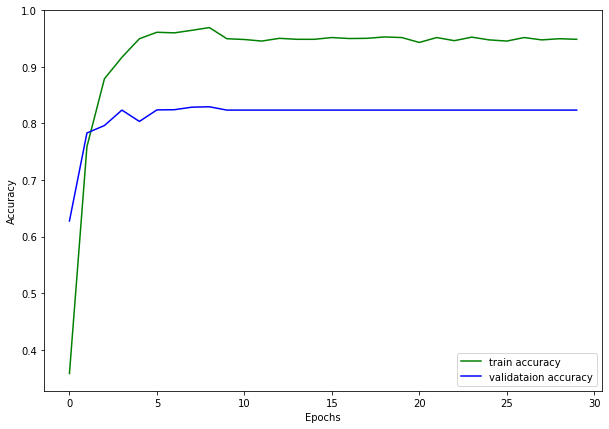

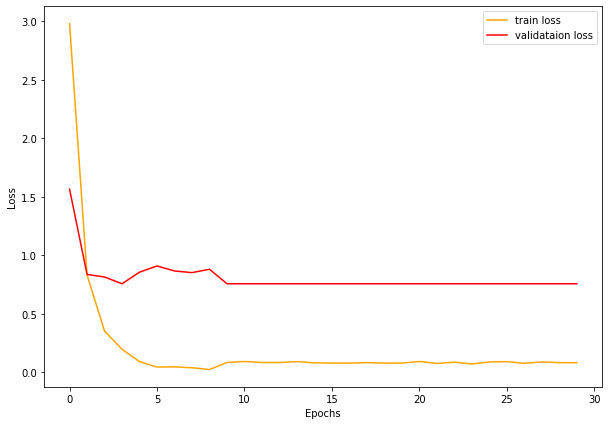


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

Test Accuracy: 0.8226754234358797


In [ ]:
LR = 1e-2
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.954712390899658
Step 10, Loss 3.414267063140869



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 4.1303, Train Acc: 0.15
Val Loss: 3.3356, Val Acc: 0.28


Starting epoch 2/30, LR = [0.001]
Step 20, Loss 2.697421073913574



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 2.8672, Train Acc: 0.36
Val Loss: 2.5169, Val Acc: 0.48


Starting epoch 3/30, LR = [0.001]
Step 30, Loss 1.876711368560791



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 2.0579, Train Acc: 0.54
Val Loss: 1.8058, Val Acc: 0.59


Starting epoch 4/30, LR = [0.001]
Step 40, Loss 1.1630173921585083



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 1.3237, Train Acc: 0.67
Val Loss: 1.2494, Val Acc: 0.71


Starting epoch 5/30, LR = [0.001]
Step 50, Loss 0.7476483583450317



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 0.7960, Train Acc: 0.78
Val Loss: 0.9466, Val Acc: 0.76


Starting epoch 6/30, LR = [0.001]
Step 60, Loss 0.48405247926712036



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]



Train Loss: 0.5021, Train Acc: 0.84
Val Loss: 0.8289, Val Acc: 0.79


Starting epoch 7/30, LR = [0.001]
Step 70, Loss 0.31915411353111267



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 0.3462, Train Acc: 0.88
Val Loss: 0.7775, Val Acc: 0.80


Starting epoch 8/30, LR = [0.001]
Step 80, Loss 0.23142191767692566



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]



Train Loss: 0.2503, Train Acc: 0.90
Val Loss: 0.7608, Val Acc: 0.80


Starting epoch 9/30, LR = [0.001]
Step 90, Loss 0.19219575822353363



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 0.1787, Train Acc: 0.92
Val Loss: 0.7544, Val Acc: 0.80


Starting epoch 10/30, LR = [0.001]
Step 100, Loss 0.11861245334148407



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 0.1352, Train Acc: 0.94
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 11/30, LR = [0.001]
Step 110, Loss 0.10741102695465088
Step 120, Loss 0.08896476030349731



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.1015, Train Acc: 0.95
Val Loss: 0.7671, Val Acc: 0.81


Starting epoch 12/30, LR = [0.001]


Step 130, Loss 0.09728163480758667



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0899, Train Acc: 0.95
Val Loss: 0.7591, Val Acc: 0.82


Starting epoch 13/30, LR = [0.001]


Step 140, Loss 0.05356675386428833



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0736, Train Acc: 0.96
Val Loss: 0.7571, Val Acc: 0.82


Starting epoch 14/30, LR = [0.001]


Step 150, Loss 0.03968450054526329



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0568, Train Acc: 0.96
Val Loss: 0.7695, Val Acc: 0.82


Starting epoch 15/30, LR = [0.001]


Step 160, Loss 0.0507294237613678



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0512, Train Acc: 0.96
Val Loss: 0.7873, Val Acc: 0.82


Early stopping!
Starting epoch 16/30, LR = [0.001]


Step 170, Loss 0.1341635137796402



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1144, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 17/30, LR = [0.001]


Step 180, Loss 0.08621595799922943



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1029, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 18/30, LR = [0.001]


Step 190, Loss 0.11146412789821625



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1111, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 19/30, LR = [0.001]


Step 200, Loss 0.07731042057275772



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1108, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 20/30, LR = [0.001]


Step 210, Loss 0.10200600326061249



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 0.1178, Train Acc: 0.94
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 21/30, LR = [0.0005]


Step 220, Loss 0.10111291706562042
Step 230, Loss 0.06554824113845825



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.1076, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 22/30, LR = [0.0005]


Step 240, Loss 0.1260547935962677



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1149, Train Acc: 0.94
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 23/30, LR = [0.0005]


Step 250, Loss 0.07047662138938904



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.1109, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 24/30, LR = [0.0005]


Step 260, Loss 0.15060417354106903



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1161, Train Acc: 0.94
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 25/30, LR = [0.0005]


Step 270, Loss 0.08483219146728516



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1073, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 26/30, LR = [0.0005]


Step 280, Loss 0.10405008494853973



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1180, Train Acc: 0.94
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 27/30, LR = [0.0005]


Step 290, Loss 0.08168783783912659



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1093, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 28/30, LR = [0.0005]


Step 300, Loss 0.10121625661849976



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1106, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 29/30, LR = [0.0005]


Step 310, Loss 0.11765867471694946



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1111, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


Starting epoch 30/30, LR = [0.0005]


Step 320, Loss 0.11877534538507462



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 0.1101, Train Acc: 0.95
Val Loss: 0.7512, Val Acc: 0.81


[(4.130342570218173, 0.15110650069156292), (2.867207873951305, 0.3606500691562932), (2.0579393993724477, 0.5401106500691563), (1.3237065401944248, 0.6659751037344398), (0.7960418029264971, 0.7766251728907331), (0.5020555095239119, 0.8354080221300139), (0.34617274728688324, 0.8796680497925311), (0.25030194087461993, 0.9007607192254495), (0.17866231230172244, 0.9225449515905948), (0.13516908477653156, 0.9387966804979253), (0.10149892487309196, 0.9481327800829875), (0.08985515209761533, 0.9505532503457814), (0.0736374668776989, 0.9557399723374828), (0.056775825267488304, 0.9602351313969572), (0.05121193402870135, 0.9623098201936376), (0.11440185863863338, 0.946058091286307), (0.10287919234145772, 0.9484785615491009), (0.1110678260976618, 0.9491701244813278), (0.1107885634357279, 0.9491701244813278), (0.1177782267332077, 0.941908713692946), (0.10759492963552475, 0.9464038727524204), (0.11494002355770631, 0.9439834024896

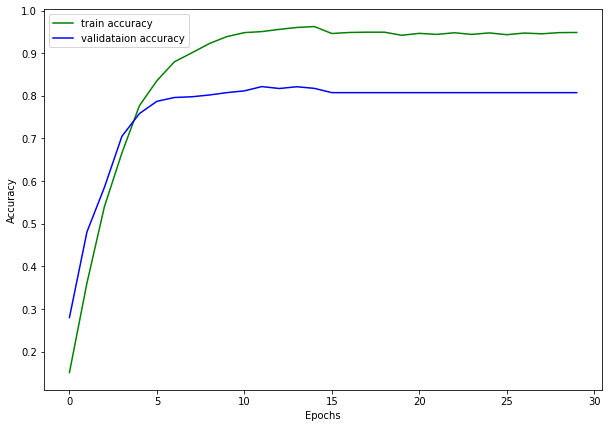

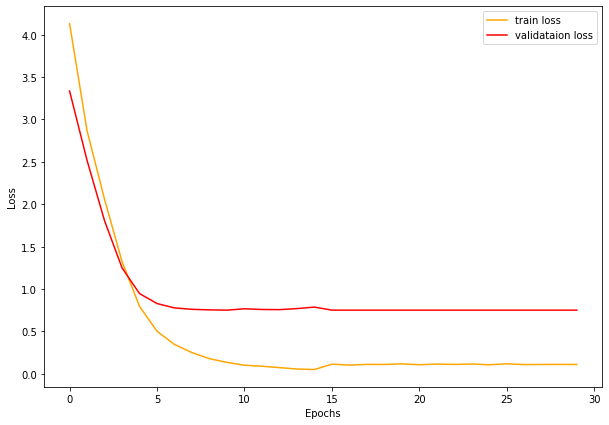


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

Test Accuracy: 0.8081576218458347


In [ ]:
LR = 1e-3
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.968827724456787
Step 10, Loss 2.115358352661133



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 3.0420, Train Acc: 0.35
Val Loss: 1.6589, Val Acc: 0.63


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.7103550434112549



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 0.9004, Train Acc: 0.74
Val Loss: 1.0629, Val Acc: 0.74


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.3629502058029175



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 0.4270, Train Acc: 0.85
Val Loss: 0.7457, Val Acc: 0.80


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.10904920101165771



100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Train Loss: 0.1672, Train Acc: 0.93
Val Loss: 0.7594, Val Acc: 0.81


Starting epoch 5/30, LR = [0.01]


Step 50, Loss 0.07732939720153809



100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Train Loss: 0.0809, Train Acc: 0.95
Val Loss: 0.8201, Val Acc: 0.82


Starting epoch 6/30, LR = [0.001]


Step 60, Loss 0.02271166443824768



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0386, Train Acc: 0.96
Val Loss: 0.7882, Val Acc: 0.83


Starting epoch 7/30, LR = [0.001]


Step 70, Loss 0.01848749816417694



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Train Loss: 0.0253, Train Acc: 0.97
Val Loss: 0.7529, Val Acc: 0.83


Starting epoch 8/30, LR = [0.001]


Step 80, Loss 0.021229337900877



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]



Train Loss: 0.0192, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 9/30, LR = [0.001]
Step 90, Loss 0.021172937005758286



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Train Loss: 0.0155, Train Acc: 0.97
Val Loss: 0.7416, Val Acc: 0.84


Starting epoch 10/30, LR = [0.001]


Step 100, Loss 0.010371331125497818



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0152, Train Acc: 0.97
Val Loss: 0.7480, Val Acc: 0.83


Starting epoch 11/30, LR = [0.0001]


Step 110, Loss 0.023492295295000076
Step 120, Loss 0.013902798295021057



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Train Loss: 0.0111, Train Acc: 0.97
Val Loss: 0.7487, Val Acc: 0.84


Starting epoch 12/30, LR = [0.0001]


Step 130, Loss 0.005907870829105377



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Train Loss: 0.0104, Train Acc: 0.97
Val Loss: 0.7487, Val Acc: 0.84


Starting epoch 13/30, LR = [0.0001]


Step 140, Loss 0.010758891701698303



100%|██████████| 12/12 [00:13<00:00,  1.11s/it]



Train Loss: 0.0106, Train Acc: 0.97
Val Loss: 0.7485, Val Acc: 0.84


Early stopping!
Starting epoch 14/30, LR = [0.0001]
Step 150, Loss 0.014026060700416565



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Train Loss: 0.0176, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 15/30, LR = [0.0001]


Step 160, Loss 0.015771087259054184



100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Train Loss: 0.0173, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 16/30, LR = [1e-05]


Step 170, Loss 0.02149280533194542



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0186, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 17/30, LR = [1e-05]


Step 180, Loss 0.010223198682069778



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Train Loss: 0.0147, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 18/30, LR = [1e-05]


Step 190, Loss 0.017328383401036263



100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Train Loss: 0.0194, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 19/30, LR = [1e-05]


Step 200, Loss 0.021037384867668152



100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


Train Loss: 0.0170, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 20/30, LR = [1e-05]


Step 210, Loss 0.014306925237178802



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0176, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 21/30, LR = [1.0000000000000002e-06]


Step 220, Loss 0.03620850667357445
Step 230, Loss 0.0076762475073337555



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0177, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 22/30, LR = [1.0000000000000002e-06]


Step 240, Loss 0.018288441002368927



100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Train Loss: 0.0174, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 23/30, LR = [1.0000000000000002e-06]


Step 250, Loss 0.021463308483362198



100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


Train Loss: 0.0173, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 24/30, LR = [1.0000000000000002e-06]


Step 260, Loss 0.013772722333669662



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0170, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 25/30, LR = [1.0000000000000002e-06]


Step 270, Loss 0.019614234566688538



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0174, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 26/30, LR = [1.0000000000000002e-07]


Step 280, Loss 0.01303870603442192



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Train Loss: 0.0156, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 27/30, LR = [1.0000000000000002e-07]


Step 290, Loss 0.01102731004357338



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Train Loss: 0.0136, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 28/30, LR = [1.0000000000000002e-07]


Step 300, Loss 0.01771543174982071



100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Train Loss: 0.0161, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 29/30, LR = [1.0000000000000002e-07]


Step 310, Loss 0.011806227266788483



100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


Train Loss: 0.0203, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


Starting epoch 30/30, LR = [1.0000000000000002e-07]


Step 320, Loss 0.018821440637111664



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 0.0168, Train Acc: 0.97
Val Loss: 0.7387, Val Acc: 0.84


[(3.0420299009843306, 0.3495850622406639), (0.9004419554363597, 0.7389349930843707), (0.4270422648299824, 0.851313969571231), (0.1672462218187072, 0.9253112033195021), (0.0808744423768737, 0.9484785615491009), (0.03859907744283026, 0.9633471645919779), (0.025271362201734024, 0.9671507607192255), (0.019157766957174648, 0.9685338865836791), (0.015515977008776232, 0.9706085753803596), (0.01521558856422251, 0.970954356846473), (0.011086270213127136, 0.9726832641770401), (0.010408902032808824, 0.9716459197786999), (0.010628437792712992, 0.9730290456431535), (0.017592187293551186, 0.9695712309820194), (0.017330766232176262, 0.970954356846473), (0.018637861040505497, 0.9681881051175657), (0.014667885885997252, 0.9713001383125864), (0.019358072937889534, 0.9706085753803596), (0.017016715454784306, 0.9702627939142462), (0.017619785768064587, 0.9688796680497925), (0.01772362230853601, 0.9702627939142462), (0.01737261224876750

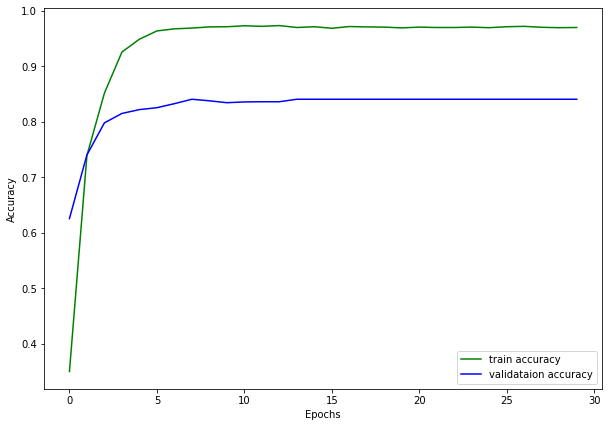

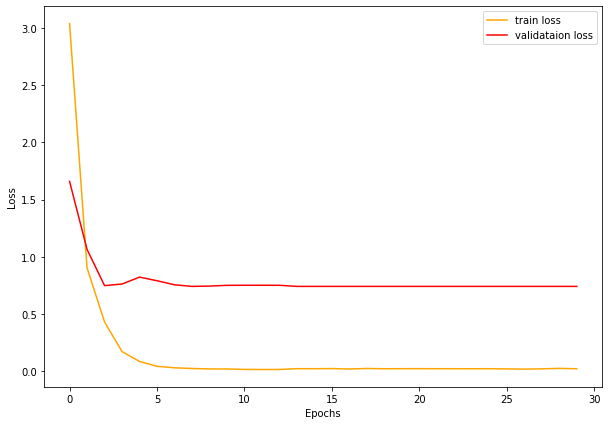


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]

Test Accuracy: 0.8399585205668856


In [ ]:
LR = 1e-2
STEP_SIZE = 5
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.829923152923584
Step 10, Loss 1.6309247016906738



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]



Train Loss: 2.9735, Train Acc: 0.35
Val Loss: 1.5707, Val Acc: 0.63


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.8401901125907898



100%|██████████| 12/12 [00:10<00:00,  1.16it/s]



Train Loss: 0.8641, Train Acc: 0.76
Val Loss: 0.9369, Val Acc: 0.76


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.34827834367752075



100%|██████████| 12/12 [00:13<00:00,  1.11s/it]



Train Loss: 0.4450, Train Acc: 0.85
Val Loss: 0.8175, Val Acc: 0.79


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.17793655395507812



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.2040, Train Acc: 0.92
Val Loss: 0.8208, Val Acc: 0.80


Starting epoch 5/30, LR = [0.01]


Step 50, Loss 0.054323870688676834



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.1134, Train Acc: 0.94
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 0.06836768984794617



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0583, Train Acc: 0.96
Val Loss: 0.8250, Val Acc: 0.82


Starting epoch 7/30, LR = [0.01]


Step 70, Loss 0.02996596321463585



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Train Loss: 0.0360, Train Acc: 0.96
Val Loss: 0.8714, Val Acc: 0.82


Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.032991062849760056



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Train Loss: 0.0342, Train Acc: 0.97
Val Loss: 0.9180, Val Acc: 0.82


Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.04951608553528786



100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Train Loss: 0.0300, Train Acc: 0.97
Val Loss: 0.8076, Val Acc: 0.83


Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.015483982861042023



100%|██████████| 12/12 [00:11<00:00,  1.03it/s]



Train Loss: 0.0133, Train Acc: 0.97
Val Loss: 0.8269, Val Acc: 0.83


Early stopping!
Starting epoch 11/30, LR = [0.01]
Step 110, Loss 0.048990968614816666
Step 120, Loss 0.046105653047561646



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0574, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.05840875580906868



100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Train Loss: 0.0585, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.09134086966514587



100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Train Loss: 0.0578, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.07202837616205215



100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Train Loss: 0.0627, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.044164396822452545



100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Train Loss: 0.0618, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 16/30, LR = [0.001]


Step 170, Loss 0.04742316156625748



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0652, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 17/30, LR = [0.001]


Step 180, Loss 0.07387688755989075



100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Train Loss: 0.0649, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 18/30, LR = [0.001]


Step 190, Loss 0.05682297796010971



100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Train Loss: 0.0566, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 19/30, LR = [0.001]


Step 200, Loss 0.06447093933820724



100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Train Loss: 0.0663, Train Acc: 0.95
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 20/30, LR = [0.001]


Step 210, Loss 0.09496892988681793



100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Train Loss: 0.0649, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 0.0724625438451767
Step 230, Loss 0.0660238042473793



100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Train Loss: 0.0636, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 22/30, LR = [0.001]


Step 240, Loss 0.04147499054670334



100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Train Loss: 0.0566, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 0.04814205691218376



100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Train Loss: 0.0581, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 0.07498151808977127



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 0.0569, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 25/30, LR = [0.001]


Step 270, Loss 0.03868502005934715



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0621, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 26/30, LR = [0.001]


Step 280, Loss 0.04208380728960037



100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Train Loss: 0.0531, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 27/30, LR = [0.001]


Step 290, Loss 0.08244214951992035



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0536, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 28/30, LR = [0.001]


Step 300, Loss 0.05514094606041908



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0587, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 0.0481223464012146



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0620, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 0.0462648831307888



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.0588, Train Acc: 0.96
Val Loss: 0.7698, Val Acc: 0.82


[(2.9735036438161675, 0.35477178423236516), (0.8641437563029203, 0.7572614107883817), (0.44497962160543963, 0.8464730290456431), (0.20397723398425363, 0.9163208852005532), (0.1134403297169642, 0.941908713692946), (0.05828528106212616, 0.9550484094052559), (0.03597886945036324, 0.9630013831258645), (0.03417322412133217, 0.965076071922545), (0.030005232176997444, 0.9671507607192255), (0.013282361017032103, 0.9716459197786999), (0.05744051391428167, 0.9571230982019364), (0.05852964622053233, 0.9581604426002767), (0.057783279567956924, 0.9602351313969572), (0.06265006011182611, 0.9564315352697096), (0.06183230673724955, 0.9553941908713693), (0.06518309664997188, 0.956777316735823), (0.06487020037390968, 0.9585062240663901), (0.05663406442512165, 0.960926694329184), (0.06629690256985751, 0.9547026279391425), (0.06487531181086194, 0.9553941908713693), (0.06361171433871443, 0.9571230982019364), (0.05661774426698685, 0.9591

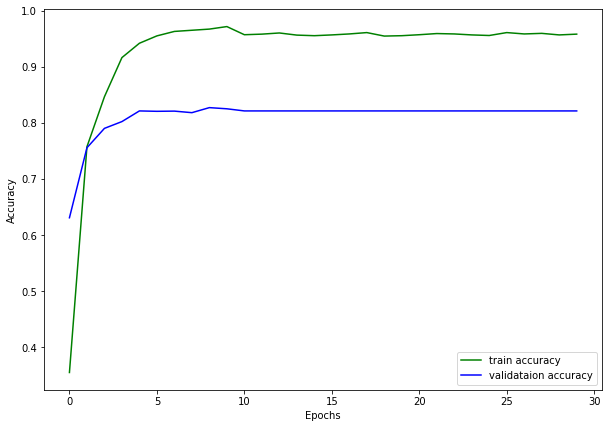

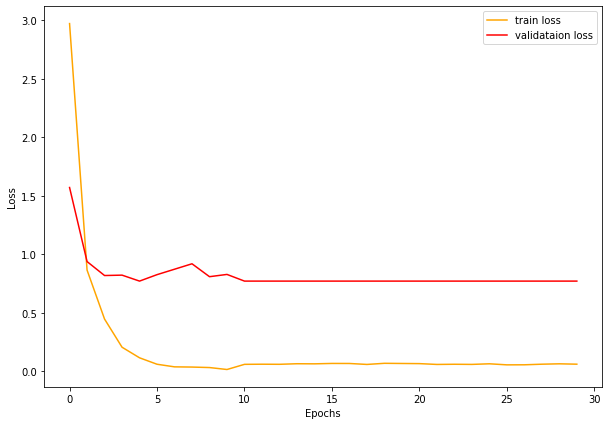


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

Test Accuracy: 0.82371240926374


In [ ]:
LR = 1e-2
STEP_SIZE = 15
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.965246200561523
Step 10, Loss 1.750428318977356



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 2.9782, Train Acc: 0.36
Val Loss: 1.5434, Val Acc: 0.63


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.6504120826721191



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.8912, Train Acc: 0.75
Val Loss: 0.8273, Val Acc: 0.79


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.22614160180091858



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.3144, Train Acc: 0.88
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.08181595802307129



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1280, Train Acc: 0.94
Val Loss: 0.8014, Val Acc: 0.82


Starting epoch 5/30, LR = [0.01]


Step 50, Loss 0.12843836843967438



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0962, Train Acc: 0.94
Val Loss: 0.8410, Val Acc: 0.81


Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.0479196198284626



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0637, Train Acc: 0.95
Val Loss: 0.8173, Val Acc: 0.82


Starting epoch 7/30, LR = [0.01]


Step 70, Loss 0.026054169982671738



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0435, Train Acc: 0.96
Val Loss: 0.8647, Val Acc: 0.81


Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.034117650240659714



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0413, Train Acc: 0.96
Val Loss: 0.9027, Val Acc: 0.80


Early stopping!
Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.21671873331069946



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1590, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.24522361159324646



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1691, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.1847187876701355
Step 120, Loss 0.1257064789533615



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1720, Train Acc: 0.92
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.16509303450584412



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1664, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.23644930124282837



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1632, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.11903972923755646



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1683, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.14661288261413574



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1702, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.12640665471553802



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1642, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.18743114173412323



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1680, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.28337031602859497



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1683, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.16399073600769043



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1725, Train Acc: 0.92
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.14295604825019836



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1562, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 0.17391864955425262
Step 230, Loss 0.1504862904548645



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1619, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 22/30, LR = [0.001]


Step 240, Loss 0.10839605331420898



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1614, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 0.17663690447807312



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1606, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 0.19604365527629852



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1675, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 25/30, LR = [0.001]


Step 270, Loss 0.2368815690279007



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1632, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 26/30, LR = [0.001]


Step 280, Loss 0.15374727547168732



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1775, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 27/30, LR = [0.001]


Step 290, Loss 0.17550045251846313



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1626, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 28/30, LR = [0.001]


Step 300, Loss 0.20067954063415527



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.1650, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 0.10699472576379776



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.1673, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 0.19917309284210205



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.1653, Train Acc: 0.93
Val Loss: 0.7349, Val Acc: 0.81


[(2.978232654658231, 0.3561549100968188), (0.8912132219834761, 0.7482710926694329), (0.3144186735153198, 0.8817427385892116), (0.12803581086072055, 0.9384508990318119), (0.09624750607393005, 0.9446749654218534), (0.06370449201627211, 0.9536652835408023), (0.04354837096550248, 0.9591977869986169), (0.04134209928187457, 0.9612724757952974), (0.15903581272472034, 0.9291147994467497), (0.1691207763823596, 0.926002766251729), (0.17204392769119956, 0.9228907330567082), (0.16644445942206818, 0.9291147994467497), (0.16320338574322787, 0.9284232365145229), (0.1682700298049233, 0.9294605809128631), (0.1701636084101417, 0.9266943291839558), (0.16423259404572574, 0.9263485477178424), (0.16795382445508783, 0.9273858921161826), (0.16829878769137643, 0.9270401106500692), (0.17245146496729416, 0.9225449515905948), (0.15619737925854596, 0.9298063623789765), (0.16187005625529724, 0.9304979253112033), (0.1614187495274977, 0.9298063623

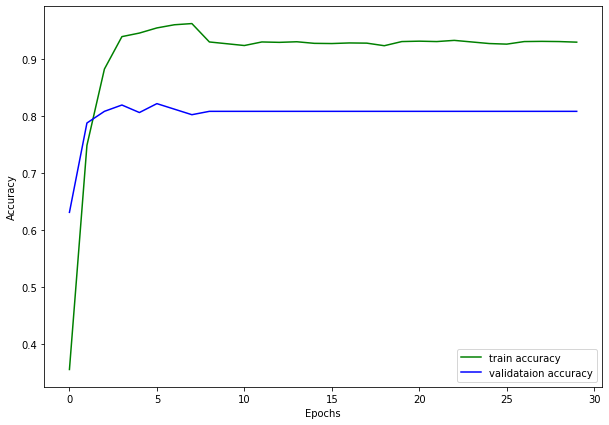

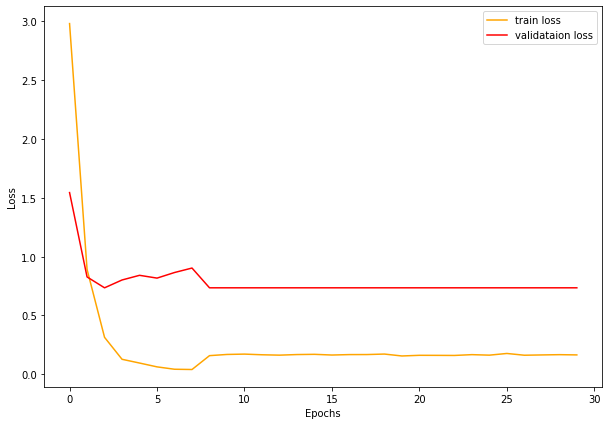


100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

Test Accuracy: 0.8081576218458347


In [ ]:
LR = 1e-2
STEP_SIZE = 20
WEIGHT_DECAY = 5e-4
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.8321943283081055
Step 10, Loss 1.7423243522644043



100%|██████████| 12/12 [00:09<00:00,  1.20it/s]



Train Loss: 3.0279, Train Acc: 0.34
Val Loss: 1.6719, Val Acc: 0.61


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.5712113976478577



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]



Train Loss: 0.9440, Train Acc: 0.74
Val Loss: 0.8691, Val Acc: 0.77


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.39537304639816284



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 0.3530, Train Acc: 0.87
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.14809508621692657



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1573, Train Acc: 0.93
Val Loss: 0.7972, Val Acc: 0.81


Starting epoch 5/30, LR = [0.01]


Step 50, Loss 0.07693807035684586



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Train Loss: 0.0822, Train Acc: 0.95
Val Loss: 0.8178, Val Acc: 0.81


Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.04711882025003433



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.0428, Train Acc: 0.96
Val Loss: 0.8409, Val Acc: 0.83


Starting epoch 7/30, LR = [0.01]


Step 70, Loss 0.03407323732972145



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0307, Train Acc: 0.97
Val Loss: 0.8369, Val Acc: 0.83


Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.011192545294761658



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0269, Train Acc: 0.97
Val Loss: 0.8432, Val Acc: 0.83


Early stopping!
Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.17063549160957336



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1596, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.12505978345870972



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1579, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.2110249400138855
Step 120, Loss 0.15996989607810974



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.1540, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.13349944353103638



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1660, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.173456072807312



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Train Loss: 0.1629, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.22584687173366547



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1668, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.13783471286296844



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Train Loss: 0.1601, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.21065549552440643



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1712, Train Acc: 0.92
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.18227209150791168



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1651, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.158782958984375



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1646, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.162628635764122



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1619, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.08603427559137344



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1663, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 0.19146768748760223
Step 230, Loss 0.153612419962883



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1706, Train Acc: 0.92
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 22/30, LR = [0.001]


Step 240, Loss 0.1928623765707016



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.1654, Train Acc: 0.92
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 0.2493995875120163



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1740, Train Acc: 0.92
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 0.12153472006320953



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.1628, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 25/30, LR = [0.001]


Step 270, Loss 0.18611492216587067



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.1601, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 26/30, LR = [0.001]


Step 280, Loss 0.16251888871192932



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.1584, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 27/30, LR = [0.001]


Step 290, Loss 0.11520853638648987



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1733, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 28/30, LR = [0.001]


Step 300, Loss 0.1097017228603363



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.1635, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 0.18136875331401825



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.1677, Train Acc: 0.93
Val Loss: 0.7547, Val Acc: 0.81


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 0.15398749709129333



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]



Train Loss: 0.1680, Train Acc: 0.92
Val Loss: 0.7547, Val Acc: 0.81


[(3.027872172268954, 0.34163208852005533), (0.9439712600274519, 0.7351313969571232), (0.35299343412572687, 0.8696403872752421), (0.15730691227045926, 0.9266943291839558), (0.08219099654392763, 0.950207468879668), (0.04279687120155855, 0.9612724757952974), (0.030697399919683285, 0.9657676348547718), (0.026935921304605225, 0.965076071922545), (0.15955394235524265, 0.9304979253112033), (0.1578998105092482, 0.9287690179806363), (0.15402039072730325, 0.9284232365145229), (0.16597194292328574, 0.9266943291839558), (0.16293364492329684, 0.926002766251729), (0.16683543134819379, 0.9273858921161826), (0.1601261103695089, 0.927731673582296), (0.17116714336655356, 0.9225449515905948), (0.16507566923444922, 0.9329183955739973), (0.1646087332205339, 0.9253112033195021), (0.16191158985549753, 0.9266943291839558), (0.1663096404888413, 0.927731673582296), (0.17059478841044687, 0.9239280774550485), (0.16541054302995856, 0.9249654218

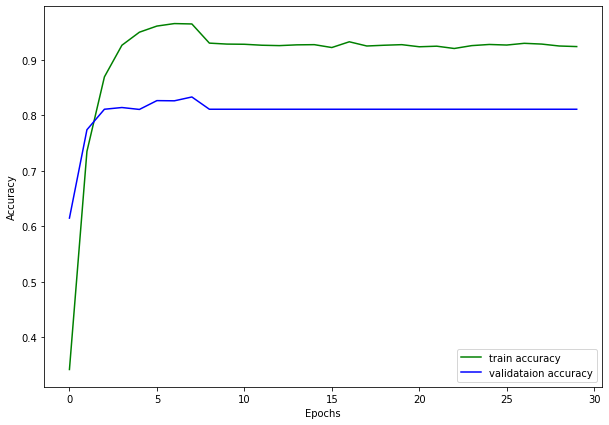

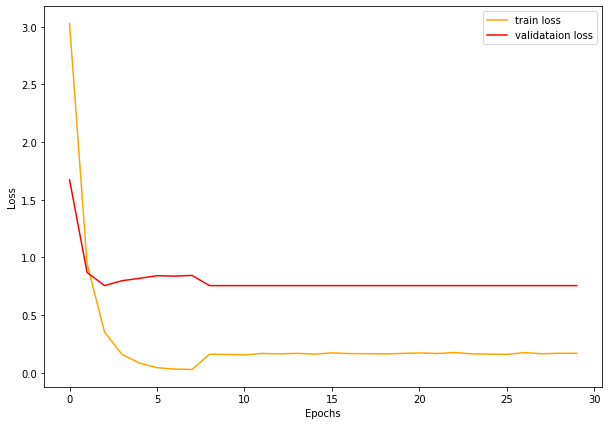


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

Test Accuracy: 0.808848945731075


In [ ]:
LR = 1e-2
STEP_SIZE = 20
WEIGHT_DECAY = 5e-6
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.874948024749756
Step 10, Loss 2.1969962120056152



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]



Train Loss: 3.0091, Train Acc: 0.35
Val Loss: 1.7866, Val Acc: 0.60


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.5325402617454529



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 0.9478, Train Acc: 0.73
Val Loss: 0.8268, Val Acc: 0.78


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.3750688433647156



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.3575, Train Acc: 0.87
Val Loss: 0.7855, Val Acc: 0.80


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.16711488366127014



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1955, Train Acc: 0.92
Val Loss: 0.8007, Val Acc: 0.80


Starting epoch 5/30, LR = [0.01]


Step 50, Loss 0.06916499137878418



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0953, Train Acc: 0.95
Val Loss: 0.8073, Val Acc: 0.82


Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.07607751339673996



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0800, Train Acc: 0.95
Val Loss: 0.8135, Val Acc: 0.82


Starting epoch 7/30, LR = [0.01]


Step 70, Loss 0.049416836351156235



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.0675, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 0.01989513263106346



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0307, Train Acc: 0.97
Val Loss: 0.7875, Val Acc: 0.83


Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.03330785408616066



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0176, Train Acc: 0.97
Val Loss: 0.8428, Val Acc: 0.84


Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.016967948526144028



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0162, Train Acc: 0.97
Val Loss: 0.9101, Val Acc: 0.82


Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.04679979383945465
Step 120, Loss 0.037415511906147



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0248, Train Acc: 0.97
Val Loss: 0.9020, Val Acc: 0.83


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.007914695888757706



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0248, Train Acc: 0.97
Val Loss: 0.8287, Val Acc: 0.84


Early stopping!
Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.032399073243141174



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0338, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.02635480836033821



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0355, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.032741595059633255



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.0367, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.024029769003391266



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0365, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.05140935257077217



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0361, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.030509497970342636



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0381, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.04042091220617294



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0364, Train Acc: 0.97
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.024372030049562454



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0351, Train Acc: 0.97
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 21/30, LR = [0.003]


Step 220, Loss 0.02894040197134018
Step 230, Loss 0.044903699308633804



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0401, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 22/30, LR = [0.003]


Step 240, Loss 0.07308641076087952



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0346, Train Acc: 0.97
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 23/30, LR = [0.003]


Step 250, Loss 0.033987101167440414



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.0340, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 24/30, LR = [0.003]


Step 260, Loss 0.053754791617393494



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0390, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 25/30, LR = [0.003]


Step 270, Loss 0.02223300188779831



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0340, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 26/30, LR = [0.003]


Step 280, Loss 0.046477437019348145



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.0363, Train Acc: 0.97
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 27/30, LR = [0.003]


Step 290, Loss 0.03389493376016617



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0346, Train Acc: 0.97
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 28/30, LR = [0.003]


Step 300, Loss 0.023713387548923492



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0329, Train Acc: 0.96
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 29/30, LR = [0.003]


Step 310, Loss 0.041756775230169296



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.0322, Train Acc: 0.97
Val Loss: 0.7493, Val Acc: 0.82


Starting epoch 30/30, LR = [0.003]


Step 320, Loss 0.023331940174102783



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.0316, Train Acc: 0.97
Val Loss: 0.7493, Val Acc: 0.82


[(3.0091174082322554, 0.3450899031811895), (0.9477941610596397, 0.7323651452282157), (0.3575096699324521, 0.8730982019363762), (0.19548889723691074, 0.9159751037344398), (0.09526318277825009, 0.9453665283540802), (0.07995059578256174, 0.9526279391424619), (0.06746633452447978, 0.9560857538035962), (0.03066181865605441, 0.9657676348547718), (0.017641023140061985, 0.9664591977869986), (0.01618511297486045, 0.9681881051175657), (0.024808596480976452, 0.9681881051175657), (0.024805344302545895, 0.966804979253112), (0.03383566710081967, 0.9647302904564315), (0.035510188645937225, 0.9643845089903181), (0.03665217503227971, 0.9636929460580913), (0.036513384262269195, 0.9640387275242047), (0.036110735752365807, 0.9630013831258645), (0.038138434290885925, 0.9636929460580913), (0.036413387818769974, 0.9661134163208852), (0.03510695645077662, 0.9671507607192255), (0.04013711112466725, 0.9633471645919779), (0.034616789357228714

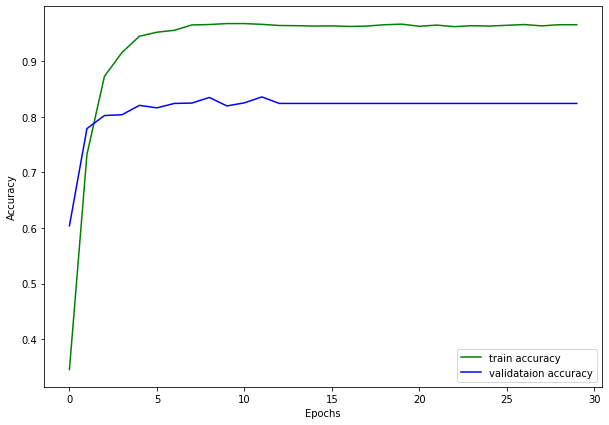

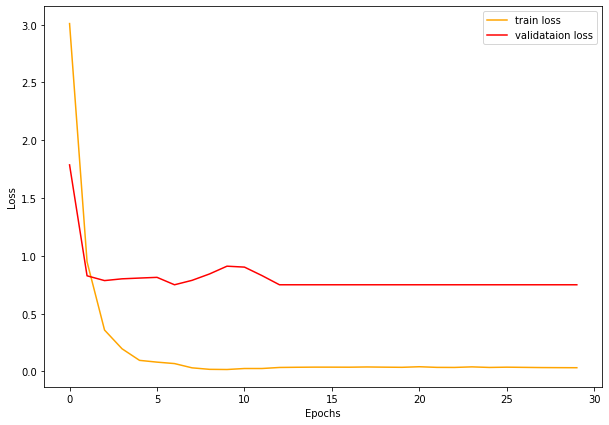


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

Test Accuracy: 0.8261320428620809


In [ ]:
LR = 1e-2
STEP_SIZE = 20
WEIGHT_DECAY = 5e-5
GAMMA = 0.3
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.969761848449707
Step 10, Loss 1.9606282711029053



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 3.0874, Train Acc: 0.33
Val Loss: 1.6890, Val Acc: 0.61


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.7931628227233887



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]



Train Loss: 0.9273, Train Acc: 0.74
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.3915352523326874



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.3678, Train Acc: 0.87
Val Loss: 0.9109, Val Acc: 0.77


Starting epoch 4/30, LR = [0.01]


Step 40, Loss 0.17132803797721863



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.2032, Train Acc: 0.92
Val Loss: 0.8439, Val Acc: 0.80


Starting epoch 5/30, LR = [0.01]


Step 50, Loss 0.13228876888751984



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.1010, Train Acc: 0.94
Val Loss: 0.8481, Val Acc: 0.81


Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.07067669928073883



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.0925, Train Acc: 0.95
Val Loss: 0.8730, Val Acc: 0.80


Starting epoch 7/30, LR = [0.01]


Step 70, Loss 0.04426850751042366



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]



Train Loss: 0.0626, Train Acc: 0.96
Val Loss: 0.8465, Val Acc: 0.81


Early stopping!
Starting epoch 8/30, LR = [0.01]
Step 80, Loss 0.4003470540046692



100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Train Loss: 0.4127, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.4438249468803406



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.4069, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.47325700521469116



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.3978, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.3081926703453064
Step 120, Loss 0.3975204527378082



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.4134, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.3961943984031677



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.4141, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.47669851779937744



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.4205, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.4049387574195862



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 0.4018, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.4072987139225006



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.4067, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.4499453604221344



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.4091, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.5400114059448242



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.4087, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.37614932656288147



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.4038, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.4293162524700165



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.4093, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.3811805248260498



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Train Loss: 0.4076, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 21/30, LR = [0.005]


Step 220, Loss 0.3840435743331909
Step 230, Loss 0.3996770679950714



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.4155, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 22/30, LR = [0.005]


Step 240, Loss 0.40062862634658813



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Train Loss: 0.4142, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 23/30, LR = [0.005]


Step 250, Loss 0.35885268449783325



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.4103, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 24/30, LR = [0.005]


Step 260, Loss 0.39414212107658386



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.4222, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 25/30, LR = [0.005]


Step 270, Loss 0.5125635862350464



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.4162, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 26/30, LR = [0.005]


Step 280, Loss 0.38396814465522766



100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Train Loss: 0.4065, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 27/30, LR = [0.005]


Step 290, Loss 0.4781974256038666



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.4196, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 28/30, LR = [0.005]


Step 300, Loss 0.5193276405334473



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Train Loss: 0.4206, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 29/30, LR = [0.005]


Step 310, Loss 0.4245414435863495



100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Train Loss: 0.4304, Train Acc: 0.85
Val Loss: 0.8380, Val Acc: 0.78


Starting epoch 30/30, LR = [0.005]


Step 320, Loss 0.4378971457481384



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]



Train Loss: 0.4036, Train Acc: 0.86
Val Loss: 0.8380, Val Acc: 0.78


[(3.0874421813271264, 0.330567081604426), (0.9273326234384016, 0.7406639004149378), (0.3678118098865856, 0.8672199170124482), (0.20320300216024573, 0.9166666666666666), (0.1009657084941864, 0.9422544951590595), (0.0924507315185937, 0.9498616874135546), (0.06257965381849896, 0.9571230982019364), (0.4126832674850117, 0.851313969571231), (0.4069172604517503, 0.8520055325034578), (0.39779746532440186, 0.8603042876901799), (0.41344072872942145, 0.853042876901798), (0.4140941934152083, 0.8485477178423236), (0.4204749492081729, 0.851313969571231), (0.40179004994305695, 0.8630705394190872), (0.4067152277989821, 0.8523513139695712), (0.40911224484443665, 0.8634163208852006), (0.4086970741098577, 0.8585753803596127), (0.4038189947605133, 0.8599585062240664), (0.40931113199754193, 0.8585753803596127), (0.40762235630642285, 0.857192254495159), (0.4154522825371135, 0.8506224066390041), (0.41418043591759424, 0.8537344398340249), 

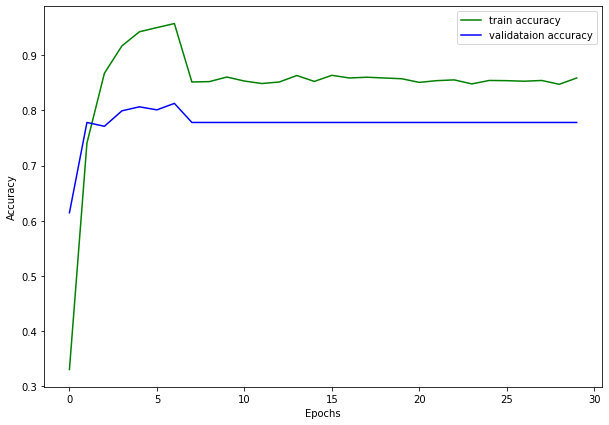

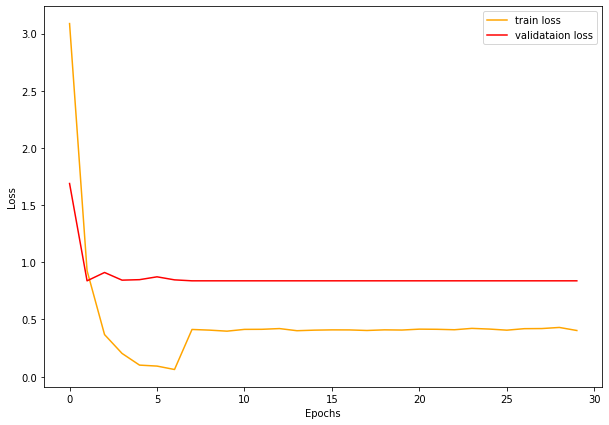


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

Test Accuracy: 0.7780850328378845


In [ ]:
LR = 1e-2
STEP_SIZE = 20
WEIGHT_DECAY = 5e-4
GAMMA = 0.5
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

Freeze layers


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/30, LR = [0.01]
Step 0, Loss 5.000411510467529


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss 1.8484700918197632


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 3.0460, Train Acc: 0.34
Val Loss: 1.6560, Val Acc: 0.63


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.7777653932571411


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 1.0509, Train Acc: 0.74
Val Loss: 0.9138, Val Acc: 0.78


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.4383006989955902


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]



Train Loss: 0.4624, Train Acc: 0.86
Val Loss: 0.6937, Val Acc: 0.82


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.22364988923072815


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 0.2686, Train Acc: 0.90
Val Loss: 0.6387, Val Acc: 0.83


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 0.16690632700920105


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Train Loss: 0.1743, Train Acc: 0.93
Val Loss: 0.6535, Val Acc: 0.83


Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.1295507252216339


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 0.1346, Train Acc: 0.94
Val Loss: 0.6202, Val Acc: 0.83


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 0.11083465814590454


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Train Loss: 0.1024, Train Acc: 0.95
Val Loss: 0.6340, Val Acc: 0.83


Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.06391802430152893


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Train Loss: 0.0721, Train Acc: 0.96
Val Loss: 0.6335, Val Acc: 0.83


Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.069244384765625


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 0.0586, Train Acc: 0.96
Val Loss: 0.6182, Val Acc: 0.84


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 0.05159926787018776


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]



Train Loss: 0.0628, Train Acc: 0.96
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 0.030395079404115677


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss 0.0388130284845829


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Train Loss: 0.0406, Train Acc: 0.97
Val Loss: 0.6096, Val Acc: 0.84


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.03294823318719864


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Train Loss: 0.0420, Train Acc: 0.96
Val Loss: 0.6125, Val Acc: 0.84


Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.03776882216334343


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Train Loss: 0.0427, Train Acc: 0.96
Val Loss: 0.6142, Val Acc: 0.84


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.041883982717990875


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Train Loss: 0.0459, Train Acc: 0.96
Val Loss: 0.6105, Val Acc: 0.84


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.03176979348063469


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Train Loss: 0.0415, Train Acc: 0.97
Val Loss: 0.6231, Val Acc: 0.85


Early stopping!
Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.045746516436338425


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Train Loss: 0.0461, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.04552677646279335


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Train Loss: 0.0424, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.039304040372371674


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Train Loss: 0.0425, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.04745977371931076


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Train Loss: 0.0433, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.0421006865799427


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Train Loss: 0.0416, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 0.02191304787993431


  0%|          | 0/12 [00:00<?, ?it/s]

Step 230, Loss 0.023466642946004868


100%|██████████| 12/12 [00:08<00:00,  1.33it/s]


Train Loss: 0.0379, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 22/30, LR = [0.001]


Step 240, Loss 0.03794188052415848


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Train Loss: 0.0415, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 0.051385413855314255


100%|██████████| 12/12 [00:08<00:00,  1.33it/s]


Train Loss: 0.0402, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 0.02829858660697937


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Train Loss: 0.0395, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 25/30, LR = [0.001]


Step 270, Loss 0.03472965583205223


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Train Loss: 0.0393, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 26/30, LR = [0.001]


Step 280, Loss 0.02884785272181034


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Train Loss: 0.0386, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 27/30, LR = [0.001]


Step 290, Loss 0.035170115530490875


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Train Loss: 0.0420, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 28/30, LR = [0.001]


Step 300, Loss 0.02444613166153431


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Train Loss: 0.0406, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 0.02679639309644699


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Train Loss: 0.0439, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 0.06362946331501007


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 0.0388, Train Acc: 0.97
Val Loss: 0.6052, Val Acc: 0.84


[(3.0460106567903, 0.34232365145228216), (1.0508692860603333, 0.73582295988935), (0.4623978490179235, 0.8599585062240664), (0.26858082142743195, 0.9049100968188105), (0.17432964660904623, 0.927731673582296), (0.13458643379536542, 0.9398340248962656), (0.10243422267111865, 0.9508990318118948), (0.07210722701116042, 0.9595435684647303), (0.05862793292511593, 0.9602351313969572), (0.06275833431969989, 0.9616182572614108), (0.04061231389641762, 0.9685338865836791), (0.04204354570670561, 0.9643845089903181), (0.042748138985850594, 0.9643845089903181), (0.04588210904462771, 0.9643845089903181), (0.04145617105744102, 0.9657676348547718), (0.04614309831099077, 0.9654218533886584), (0.04239737428724766, 0.9678423236514523), (0.04252574389631098, 0.9674965421853389), (0.043287551030516624, 0.9661134163208852), (0.041581285778771744, 0.9688796680497925), (0.037896447222341194, 0.9671507607192255), (0.041468208147720856, 0.9688

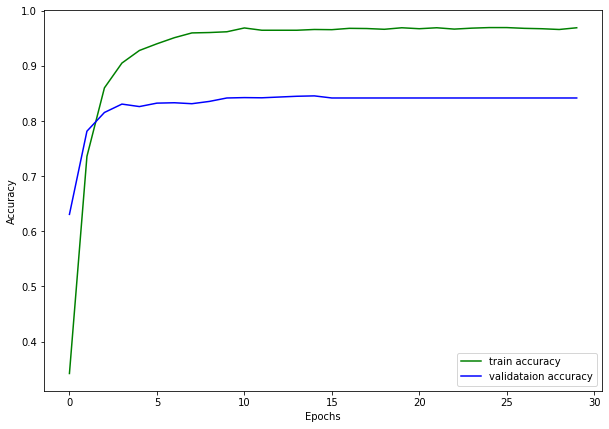

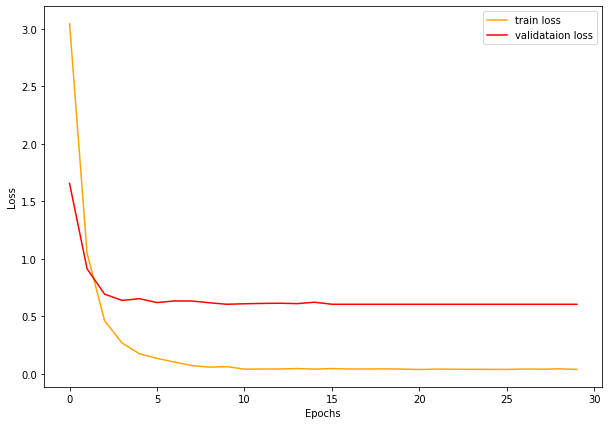

100%|██████████| 12/12 [00:08<00:00,  1.35it/s]

Test Accuracy: 0.8420324922226063


In [ ]:
LR = 1e-2
STEP_SIZE = 20
WEIGHT_DECAY = 5e-5
GAMMA = 0.1
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.classifier.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained freeze")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained freeze")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.7832818031311035


  0%|          | 0/12 [00:00<?, ?it/s]

Step 10, Loss 4.395424842834473


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 4.5722, Train Acc: 0.03
Val Loss: 4.3384, Val Acc: 0.15


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 3.9788475036621094


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]



Train Loss: 4.1356, Train Acc: 0.17
Val Loss: 3.8827, Val Acc: 0.24


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 3.4294188022613525


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 3.6831, Train Acc: 0.23
Val Loss: 3.5299, Val Acc: 0.26


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 3.387856960296631


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 3.4153, Train Acc: 0.26
Val Loss: 3.3138, Val Acc: 0.32


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 3.329468250274658


100%|██████████| 12/12 [00:08<00:00,  1.33it/s]



Train Loss: 3.2220, Train Acc: 0.29
Val Loss: 3.1681, Val Acc: 0.34


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 3.3226537704467773


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]



Train Loss: 3.0792, Train Acc: 0.32
Val Loss: 3.0732, Val Acc: 0.36


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 2.8634095191955566


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]



Train Loss: 2.9760, Train Acc: 0.34
Val Loss: 2.9836, Val Acc: 0.38


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 2.8936359882354736


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 2.8704, Train Acc: 0.37
Val Loss: 2.9003, Val Acc: 0.40


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 2.7155399322509766


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 2.7485, Train Acc: 0.39
Val Loss: 2.8051, Val Acc: 0.41


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 2.7306177616119385


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 2.6631, Train Acc: 0.40
Val Loss: 2.7532, Val Acc: 0.41


Starting epoch 11/30, LR = [0.01]
Step 110, Loss 2.3521556854248047


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss 2.379955768585205


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]



Train Loss: 2.5844, Train Acc: 0.41
Val Loss: 2.6966, Val Acc: 0.42


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 2.284147024154663


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 2.5226, Train Acc: 0.42
Val Loss: 2.6130, Val Acc: 0.44


Starting epoch 13/30, LR = [0.01]
Step 140, Loss 2.485473155975342


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]



Train Loss: 2.3915, Train Acc: 0.45
Val Loss: 2.5187, Val Acc: 0.46


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 2.3466908931732178


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



Train Loss: 2.2737, Train Acc: 0.47
Val Loss: 2.4283, Val Acc: 0.48


Starting epoch 15/30, LR = [0.01]
Step 160, Loss 2.3505477905273438


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 2.1769, Train Acc: 0.49
Val Loss: 2.3945, Val Acc: 0.48


Starting epoch 16/30, LR = [0.01]
Step 170, Loss 2.171551465988159


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 2.1366, Train Acc: 0.49
Val Loss: 2.3589, Val Acc: 0.49


Starting epoch 17/30, LR = [0.01]
Step 180, Loss 1.9270175695419312


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 2.0563, Train Acc: 0.52
Val Loss: 2.3049, Val Acc: 0.51


Starting epoch 18/30, LR = [0.01]
Step 190, Loss 1.9488478899002075


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]



Train Loss: 2.0122, Train Acc: 0.52
Val Loss: 2.2503, Val Acc: 0.51


Starting epoch 19/30, LR = [0.01]
Step 200, Loss 2.025925397872925


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



Train Loss: 1.9196, Train Acc: 0.53
Val Loss: 2.2502, Val Acc: 0.50


Starting epoch 20/30, LR = [0.01]
Step 210, Loss 1.8066860437393188


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 1.8472, Train Acc: 0.55
Val Loss: 2.2294, Val Acc: 0.52


Starting epoch 21/30, LR = [0.001]
Step 220, Loss 1.7231343984603882


  0%|          | 0/12 [00:00<?, ?it/s]

Step 230, Loss 1.750266194343567


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 1.7465, Train Acc: 0.57
Val Loss: 2.1246, Val Acc: 0.54


Starting epoch 22/30, LR = [0.001]
Step 240, Loss 1.5993373394012451


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]



Train Loss: 1.6518, Train Acc: 0.58
Val Loss: 2.0937, Val Acc: 0.55


Starting epoch 23/30, LR = [0.001]
Step 250, Loss 1.3724247217178345


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 1.5793, Train Acc: 0.61
Val Loss: 2.0715, Val Acc: 0.55


Starting epoch 24/30, LR = [0.001]
Step 260, Loss 1.6148507595062256


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 1.5769, Train Acc: 0.60
Val Loss: 2.0659, Val Acc: 0.56


Starting epoch 25/30, LR = [0.001]
Step 270, Loss 1.6031312942504883


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 1.5835, Train Acc: 0.60
Val Loss: 2.0586, Val Acc: 0.56


Starting epoch 26/30, LR = [0.001]
Step 280, Loss 1.758041501045227


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 1.5843, Train Acc: 0.60
Val Loss: 2.0522, Val Acc: 0.56


Starting epoch 27/30, LR = [0.001]
Step 290, Loss 1.4043618440628052


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]



Train Loss: 1.5663, Train Acc: 0.60
Val Loss: 2.0346, Val Acc: 0.56


Starting epoch 28/30, LR = [0.001]
Step 300, Loss 1.6973645687103271


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Train Loss: 1.5548, Train Acc: 0.61
Val Loss: 2.0398, Val Acc: 0.56


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 1.4781088829040527


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Train Loss: 1.5277, Train Acc: 0.62
Val Loss: 2.0433, Val Acc: 0.56


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 1.823101282119751


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]



Train Loss: 1.5268, Train Acc: 0.61
Val Loss: 2.0348, Val Acc: 0.56


[(4.572231292724609, 0.03319502074688797), (4.135606744072654, 0.17116182572614108), (3.6831357912583784, 0.23340248962655602), (3.4153111197731714, 0.26175656984785617), (3.221975478259, 0.29495159059474413), (3.0791947191411797, 0.32468879668049794), (2.9760324521498247, 0.34405255878284924), (2.8703642324967817, 0.37171507607192256), (2.748475594954057, 0.38658367911479946), (2.6631476228887383, 0.39868603042876904), (2.584421092813665, 0.4114799446749654), (2.5226274620402944, 0.4190871369294606), (2.3914814428849653, 0.4512448132780083), (2.2736775875091553, 0.4661134163208852), (2.1768870028582485, 0.49100968188105115), (2.1366077228025957, 0.49446749654218536), (2.056275248527527, 0.5155601659751037), (2.012150298465382, 0.5242047026279392), (1.919647682796825, 0.5328492392807745), (1.8471589088439941, 0.5525587828492393), (1.7465490102767944, 0.5736514522821576), (1.6517589634115046, 0.584716459197787), (1.5

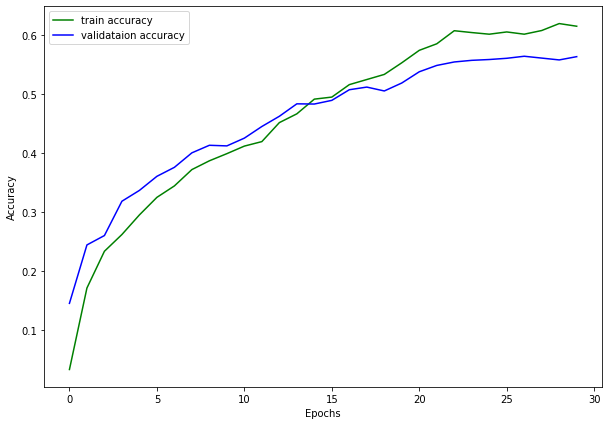

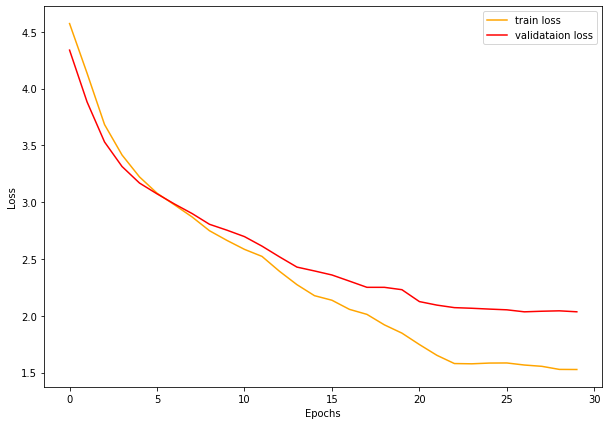

100%|██████████| 12/12 [00:08<00:00,  1.39it/s]

Test Accuracy: 0.5506394745938472


In [ ]:
LR = 1e-2
STEP_SIZE = 20
WEIGHT_DECAY = 5e-5
GAMMA = 0.1
net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.features.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained freeze")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained freeze")
test(net,test_dataloader)

Data augmentation

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.9431352615356445
Step 10, Loss 2.6745412349700928


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]



Train Loss: 3.4946, Train Acc: 0.28
Val Loss: 2.3105, Val Acc: 0.47


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 1.6160473823547363


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]



Train Loss: 1.9176, Train Acc: 0.53
Val Loss: 1.6616, Val Acc: 0.59


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 1.2399994134902954


100%|██████████| 12/12 [00:13<00:00,  1.15s/it]



Train Loss: 1.3423, Train Acc: 0.64
Val Loss: 1.4139, Val Acc: 0.64


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 1.0105122327804565


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]



Train Loss: 1.0823, Train Acc: 0.69
Val Loss: 1.2762, Val Acc: 0.66


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 0.8670604228973389


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]



Train Loss: 0.9026, Train Acc: 0.73
Val Loss: 1.2718, Val Acc: 0.67


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 0.7487038373947144


100%|██████████| 12/12 [00:14<00:00,  1.19s/it]



Train Loss: 0.8285, Train Acc: 0.75
Val Loss: 1.2219, Val Acc: 0.68


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 0.7337437868118286


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]



Train Loss: 0.7250, Train Acc: 0.78
Val Loss: 1.2150, Val Acc: 0.68


Starting epoch 8/30, LR = [0.01]
Step 80, Loss 0.7344661355018616


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Train Loss: 0.6466, Train Acc: 0.79
Val Loss: 1.2596, Val Acc: 0.68


Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.4851949214935303


100%|██████████| 12/12 [00:13<00:00,  1.17s/it]


Train Loss: 0.5567, Train Acc: 0.81
Val Loss: 1.2350, Val Acc: 0.68


Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.603929877281189


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Train Loss: 0.5713, Train Acc: 0.81
Val Loss: 1.2622, Val Acc: 0.68


Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.565974235534668
Step 120, Loss 0.6268573999404907


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Train Loss: 0.5388, Train Acc: 0.83
Val Loss: 1.2515, Val Acc: 0.69


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.5340925455093384


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Train Loss: 0.4738, Train Acc: 0.83
Val Loss: 1.2361, Val Acc: 0.69


Early stopping!
Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.570029616355896


100%|██████████| 12/12 [00:13<00:00,  1.14s/it]



Train Loss: 0.6350, Train Acc: 0.80
Val Loss: 1.1818, Val Acc: 0.69


Starting epoch 14/30, LR = [0.01]
Step 150, Loss 0.5547095537185669


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Train Loss: 0.6309, Train Acc: 0.79
Val Loss: 1.2385, Val Acc: 0.68


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.628821074962616


100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Train Loss: 0.6615, Train Acc: 0.79
Val Loss: 1.2094, Val Acc: 0.68


Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.7401872873306274


100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Train Loss: 0.6582, Train Acc: 0.79
Val Loss: 1.2252, Val Acc: 0.67


Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.6300533413887024


100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Train Loss: 0.6226, Train Acc: 0.80
Val Loss: 1.2104, Val Acc: 0.68


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.6288232803344727


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Train Loss: 0.6120, Train Acc: 0.80
Val Loss: 1.2023, Val Acc: 0.68


Early stopping!
Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.6635254621505737


100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Train Loss: 0.6511, Train Acc: 0.78
Val Loss: 1.1953, Val Acc: 0.68


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.5429147481918335


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Train Loss: 0.6288, Train Acc: 0.80
Val Loss: 1.1991, Val Acc: 0.68


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 0.7044377326965332
Step 230, Loss 0.6429494619369507


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]



Train Loss: 0.6540, Train Acc: 0.79
Val Loss: 1.1800, Val Acc: 0.69


Starting epoch 22/30, LR = [0.001]
Step 240, Loss 0.7478396892547607


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Train Loss: 0.6045, Train Acc: 0.80
Val Loss: 1.2153, Val Acc: 0.68


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 0.584810197353363


100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Train Loss: 0.6697, Train Acc: 0.79
Val Loss: 1.1933, Val Acc: 0.68


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 0.6759928464889526


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Train Loss: 0.6803, Train Acc: 0.78
Val Loss: 1.2237, Val Acc: 0.67


Starting epoch 25/30, LR = [0.001]


Step 270, Loss 0.6329346299171448


100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Train Loss: 0.6401, Train Acc: 0.80
Val Loss: 1.2311, Val Acc: 0.68


Starting epoch 26/30, LR = [0.001]


Step 280, Loss 0.6369004845619202


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Train Loss: 0.6185, Train Acc: 0.80
Val Loss: 1.2190, Val Acc: 0.69


Early stopping!
Starting epoch 27/30, LR = [0.001]


Step 290, Loss 0.6002498269081116


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Train Loss: 0.6111, Train Acc: 0.80
Val Loss: 1.1916, Val Acc: 0.69


Starting epoch 28/30, LR = [0.001]


Step 300, Loss 0.7081657648086548


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Train Loss: 0.6523, Train Acc: 0.79
Val Loss: 1.1831, Val Acc: 0.68


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 0.6194897294044495


100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Train Loss: 0.6465, Train Acc: 0.79
Val Loss: 1.1954, Val Acc: 0.69


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 0.6372001767158508


100%|██████████| 12/12 [00:13<00:00,  1.16s/it]



Train Loss: 0.6365, Train Acc: 0.80
Val Loss: 1.2148, Val Acc: 0.69


[(3.4946100278334185, 0.2821576763485477), (1.9176346388730137, 0.5321576763485477), (1.3423225988041272, 0.6386583679114799), (1.0822970433668657, 0.6891424619640387), (0.9026201692494479, 0.7299446749654218), (0.8284711837768555, 0.7493084370677732), (0.7250053069808267, 0.7766251728907331), (0.6466498916799371, 0.7911479944674965), (0.556706122376702, 0.8143153526970954), (0.5713167488574982, 0.8053250345781466), (0.5388055633414875, 0.826417704011065), (0.47378442504189233, 0.8343706777316736), (0.6350092454390093, 0.8011756569847857), (0.63093332268975, 0.7949515905947441), (0.6615117950872942, 0.7876901798063624), (0.6581988443027843, 0.7904564315352697), (0.622554749250412, 0.7991009681881052), (0.6119568402116949, 0.799792531120332), (0.6510923233899203, 0.783195020746888), (0.6288127465681597, 0.799792531120332), (0.6540240970524874, 0.7928769017980636), (0.6045277552171187, 0.8015214384508991), (0.66973336

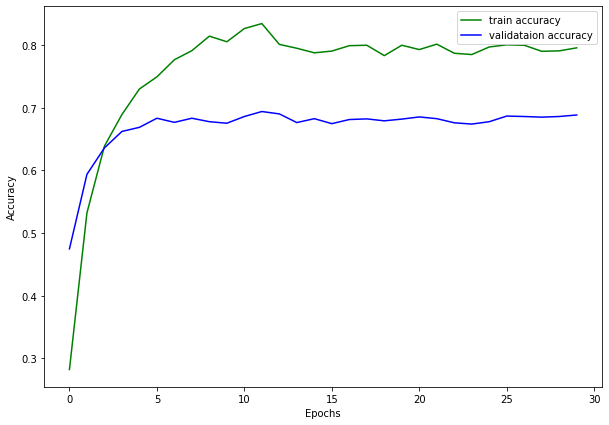

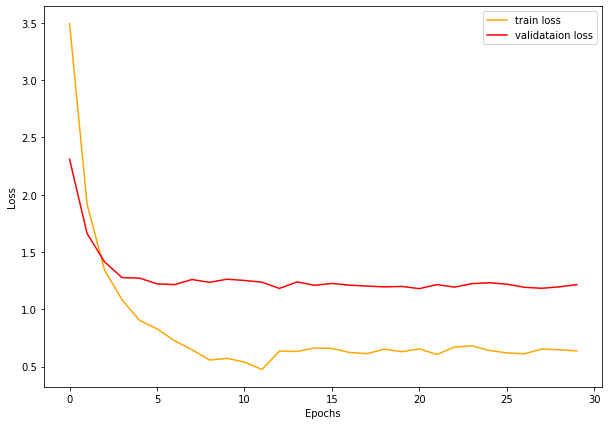

100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

Test Accuracy: 0.7628759073625994


In [ ]:
BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data_augmentation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(40),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=train_data_augmentation)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.classifier.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained freeze")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained freeze")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.8440117835998535
Step 10, Loss 2.4693989753723145


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]



Train Loss: 3.4040, Train Acc: 0.28
Val Loss: 2.2588, Val Acc: 0.49


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 1.6448543071746826


100%|██████████| 12/12 [00:17<00:00,  1.47s/it]



Train Loss: 1.7615, Train Acc: 0.55
Val Loss: 1.5995, Val Acc: 0.61


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.983349084854126


100%|██████████| 12/12 [00:17<00:00,  1.47s/it]



Train Loss: 1.1862, Train Acc: 0.66
Val Loss: 1.4876, Val Acc: 0.64


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.9830400347709656


100%|██████████| 12/12 [00:17<00:00,  1.48s/it]



Train Loss: 0.9941, Train Acc: 0.71
Val Loss: 1.3706, Val Acc: 0.66


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 0.7082672715187073


100%|██████████| 12/12 [00:17<00:00,  1.47s/it]



Train Loss: 0.8063, Train Acc: 0.75
Val Loss: 1.3512, Val Acc: 0.67


Starting epoch 6/30, LR = [0.01]
Step 60, Loss 0.6935608983039856


100%|██████████| 12/12 [00:18<00:00,  1.50s/it]



Train Loss: 0.6870, Train Acc: 0.79
Val Loss: 1.3163, Val Acc: 0.67


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 0.5231488347053528


100%|██████████| 12/12 [00:18<00:00,  1.50s/it]


Train Loss: 0.6125, Train Acc: 0.79
Val Loss: 1.3170, Val Acc: 0.68


Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.46367764472961426


100%|██████████| 12/12 [00:18<00:00,  1.50s/it]


Train Loss: 0.5525, Train Acc: 0.81
Val Loss: 1.3311, Val Acc: 0.67


Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.42093220353126526


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


Train Loss: 0.5055, Train Acc: 0.82
Val Loss: 1.3236, Val Acc: 0.68


Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.5070751905441284


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


Train Loss: 0.4481, Train Acc: 0.84
Val Loss: 1.3494, Val Acc: 0.67


Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.3488771915435791
Step 120, Loss 0.4262515902519226


100%|██████████| 12/12 [00:18<00:00,  1.51s/it]



Train Loss: 0.4043, Train Acc: 0.85
Val Loss: 1.2859, Val Acc: 0.69


Starting epoch 12/30, LR = [0.01]
Step 130, Loss 0.5389561653137207


100%|██████████| 12/12 [00:18<00:00,  1.51s/it]


Train Loss: 0.3920, Train Acc: 0.86
Val Loss: 1.3348, Val Acc: 0.68


Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.34976425766944885


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


Train Loss: 0.3669, Train Acc: 0.86
Val Loss: 1.3261, Val Acc: 0.68


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.4326537251472473


100%|██████████| 12/12 [00:18<00:00,  1.51s/it]


Train Loss: 0.3374, Train Acc: 0.87
Val Loss: 1.3938, Val Acc: 0.67


Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.23593296110630035


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Train Loss: 0.2884, Train Acc: 0.89
Val Loss: 1.3778, Val Acc: 0.69


Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.28922349214553833


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


Train Loss: 0.2758, Train Acc: 0.89
Val Loss: 1.3953, Val Acc: 0.70


Early stopping!
Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.26831018924713135


100%|██████████| 12/12 [00:18<00:00,  1.51s/it]


Train Loss: 0.3379, Train Acc: 0.87
Val Loss: 1.3202, Val Acc: 0.69


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.31618812680244446


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Train Loss: 0.3428, Train Acc: 0.87
Val Loss: 1.3067, Val Acc: 0.69


Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.36879056692123413


100%|██████████| 12/12 [00:18<00:00,  1.55s/it]


Train Loss: 0.3489, Train Acc: 0.87
Val Loss: 1.3287, Val Acc: 0.68


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.366873174905777


100%|██████████| 12/12 [00:18<00:00,  1.51s/it]


Train Loss: 0.3599, Train Acc: 0.87
Val Loss: 1.3236, Val Acc: 0.69


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 0.3371323049068451
Step 230, Loss 0.3481047749519348


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


Train Loss: 0.3646, Train Acc: 0.87
Val Loss: 1.2926, Val Acc: 0.69


Starting epoch 22/30, LR = [0.001]


Step 240, Loss 0.37781253457069397


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Train Loss: 0.3434, Train Acc: 0.87
Val Loss: 1.2884, Val Acc: 0.69


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 0.38713759183883667


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


Train Loss: 0.3640, Train Acc: 0.87
Val Loss: 1.3115, Val Acc: 0.69


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 0.3506019115447998


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Train Loss: 0.3558, Train Acc: 0.87
Val Loss: 1.3052, Val Acc: 0.69


Starting epoch 25/30, LR = [0.001]


Step 270, Loss 0.28442442417144775


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Train Loss: 0.3584, Train Acc: 0.87
Val Loss: 1.3227, Val Acc: 0.69


Starting epoch 26/30, LR = [0.001]


Step 280, Loss 0.35741743445396423


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Train Loss: 0.3525, Train Acc: 0.87
Val Loss: 1.3028, Val Acc: 0.69


Starting epoch 27/30, LR = [0.001]


Step 290, Loss 0.3358827829360962


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Train Loss: 0.3630, Train Acc: 0.87
Val Loss: 1.2981, Val Acc: 0.69


Starting epoch 28/30, LR = [0.001]


Step 300, Loss 0.41094037890434265


100%|██████████| 12/12 [00:18<00:00,  1.54s/it]


Train Loss: 0.3400, Train Acc: 0.88
Val Loss: 1.2951, Val Acc: 0.69


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 0.44333213567733765


100%|██████████| 12/12 [00:18<00:00,  1.54s/it]


Train Loss: 0.3387, Train Acc: 0.88
Val Loss: 1.3052, Val Acc: 0.69


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 0.3123719096183777


100%|██████████| 12/12 [00:18<00:00,  1.52s/it]



Train Loss: 0.3471, Train Acc: 0.87
Val Loss: 1.2769, Val Acc: 0.69


[(3.40403151512146, 0.2842323651452282), (1.761450399052013, 0.5542876901798064), (1.1861986788836392, 0.6632088520055325), (0.9940722367980264, 0.7074688796680498), (0.8062637990171259, 0.7513831258644537), (0.687009952285073, 0.7869986168741355), (0.6125071753155101, 0.7942600276625172), (0.5524846098639749, 0.8115491009681881), (0.5054792111570184, 0.8233056708160442), (0.4480782069943168, 0.8412863070539419), (0.4043104756962169, 0.853042876901798), (0.3919706778092818, 0.857192254495159), (0.36689499562436884, 0.8613416320885201), (0.33740056644786487, 0.8734439834024896), (0.2884196530688893, 0.892807745504841), (0.2757674482735721, 0.8876210235131397), (0.3379117494279688, 0.8689488243430152), (0.3428047001361847, 0.873789764868603), (0.3488883457400582, 0.8689488243430152), (0.359862820668654, 0.8654910096818811), (0.36459677056832746, 0.867911479944675), (0.34336561235514557, 0.8724066390041494), (0.3639501

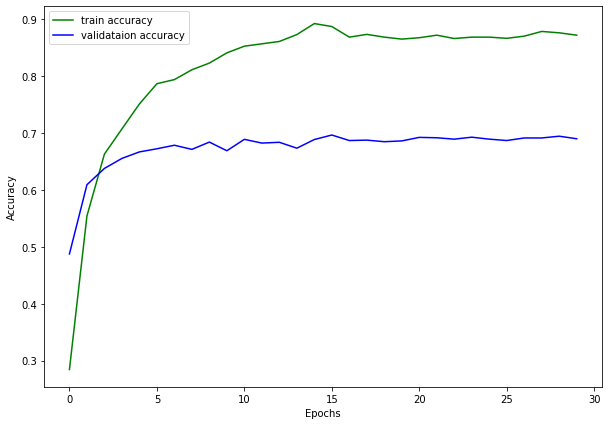

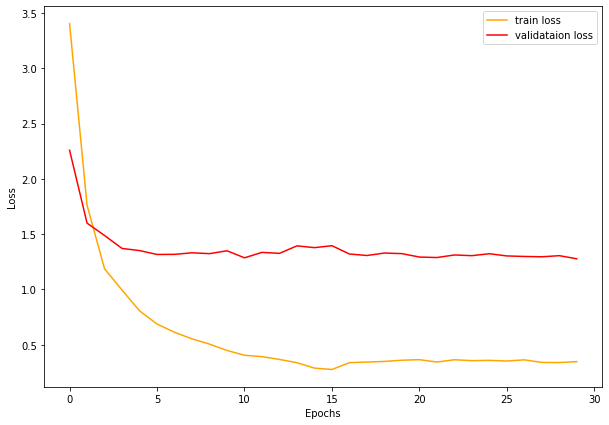

100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

Test Accuracy: 0.7507777393708953


In [ ]:
BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_data_augmentation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(80),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=train_data_augmentation)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.classifier.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained freeze")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained freeze")
test(net,test_dataloader)

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 5.008835792541504
Step 10, Loss 1.8932137489318848


100%|██████████| 12/12 [00:13<00:00,  1.11s/it]



Train Loss: 3.0753, Train Acc: 0.34
Val Loss: 1.7118, Val Acc: 0.60


Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.710029125213623


100%|██████████| 12/12 [00:13<00:00,  1.13s/it]



Train Loss: 1.0667, Train Acc: 0.73
Val Loss: 1.0054, Val Acc: 0.75


Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.456095814704895


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]



Train Loss: 0.4772, Train Acc: 0.85
Val Loss: 0.8390, Val Acc: 0.78


Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.25600460171699524


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]



Train Loss: 0.2671, Train Acc: 0.90
Val Loss: 0.7919, Val Acc: 0.79


Starting epoch 5/30, LR = [0.01]
Step 50, Loss 0.16697441041469574


100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Train Loss: 0.1680, Train Acc: 0.93
Val Loss: 0.7971, Val Acc: 0.79


Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.11154952645301819


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]



Train Loss: 0.1087, Train Acc: 0.95
Val Loss: 0.7759, Val Acc: 0.81


Starting epoch 7/30, LR = [0.01]
Step 70, Loss 0.05887853726744652


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Train Loss: 0.0768, Train Acc: 0.96
Val Loss: 0.7840, Val Acc: 0.81


Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.059883229434490204


100%|██████████| 12/12 [00:12<00:00,  1.07s/it]



Train Loss: 0.0540, Train Acc: 0.97
Val Loss: 0.7732, Val Acc: 0.81


Starting epoch 9/30, LR = [0.01]
Step 90, Loss 0.04329727217555046


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]



Train Loss: 0.0521, Train Acc: 0.96
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 10/30, LR = [0.01]
Step 100, Loss 0.05306243896484375


100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Train Loss: 0.0433, Train Acc: 0.97
Val Loss: 0.7848, Val Acc: 0.81


Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.040436357259750366
Step 120, Loss 0.024360068142414093


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Train Loss: 0.0345, Train Acc: 0.97
Val Loss: 0.7867, Val Acc: 0.81


Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.022449128329753876


100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Train Loss: 0.0262, Train Acc: 0.97
Val Loss: 0.7844, Val Acc: 0.81


Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.025070201605558395


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Train Loss: 0.0243, Train Acc: 0.97
Val Loss: 0.7847, Val Acc: 0.82


Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.02771095186471939


100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Train Loss: 0.0258, Train Acc: 0.97
Val Loss: 0.8021, Val Acc: 0.81


Early stopping!
Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.03112694062292576


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Train Loss: 0.0412, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.028502970933914185


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Train Loss: 0.0405, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.040737830102443695


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Train Loss: 0.0418, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.03638044744729996


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Train Loss: 0.0408, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.03563319891691208


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Train Loss: 0.0432, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.03740864619612694


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Train Loss: 0.0419, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 21/30, LR = [0.001]


Step 220, Loss 0.03870835155248642
Step 230, Loss 0.02868781052529812


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Train Loss: 0.0369, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 22/30, LR = [0.001]


Step 240, Loss 0.04329356178641319


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Train Loss: 0.0394, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 23/30, LR = [0.001]


Step 250, Loss 0.04670003056526184


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Train Loss: 0.0373, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 24/30, LR = [0.001]


Step 260, Loss 0.04793934524059296


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Train Loss: 0.0385, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 25/30, LR = [0.001]


Step 270, Loss 0.027908343821763992


100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Train Loss: 0.0409, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 26/30, LR = [0.001]


Step 280, Loss 0.026839103549718857


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Train Loss: 0.0400, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 27/30, LR = [0.001]


Step 290, Loss 0.030160024762153625


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Train Loss: 0.0397, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 28/30, LR = [0.001]


Step 300, Loss 0.041814666241407394


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Train Loss: 0.0370, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 29/30, LR = [0.001]


Step 310, Loss 0.04178867116570473


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Train Loss: 0.0370, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


Starting epoch 30/30, LR = [0.001]


Step 320, Loss 0.04475793614983559


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]



Train Loss: 0.0399, Train Acc: 0.97
Val Loss: 0.7673, Val Acc: 0.81


[(3.0752517743544145, 0.33990318118948826), (1.066653229973533, 0.7340940525587828), (0.4771715185858987, 0.8492392807745505), (0.2671498182145032, 0.9017980636237898), (0.16799855367703873, 0.9325726141078838), (0.1087297648191452, 0.9529737206085753), (0.07675165378234604, 0.9598893499308437), (0.05402495915239507, 0.9657676348547718), (0.05213383212685585, 0.9626556016597511), (0.043283900754018265, 0.9657676348547718), (0.03452754477885636, 0.969225449515906), (0.026198463853109966, 0.9716459197786999), (0.024292654273184864, 0.9713001383125864), (0.025757481090047142, 0.9702627939142462), (0.04120509715920145, 0.9685338865836791), (0.04054927504198118, 0.9678423236514523), (0.04183339530771429, 0.9654218533886584), (0.040760079568082634, 0.9681881051175657), (0.043186539953405205, 0.9674965421853389), (0.04191832345995036, 0.966804979253112), (0.03688156587833708, 0.969225449515906), (0.03941708312115886, 0.968

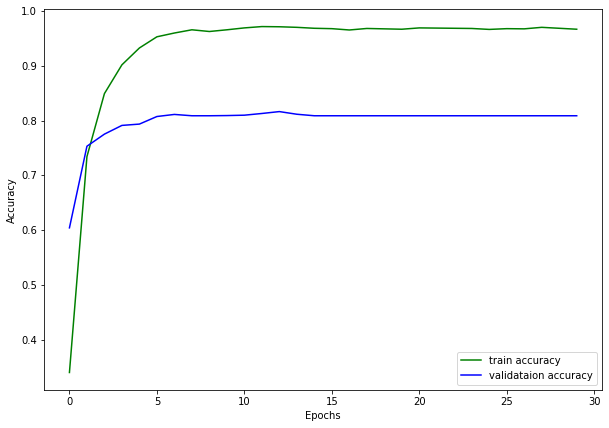

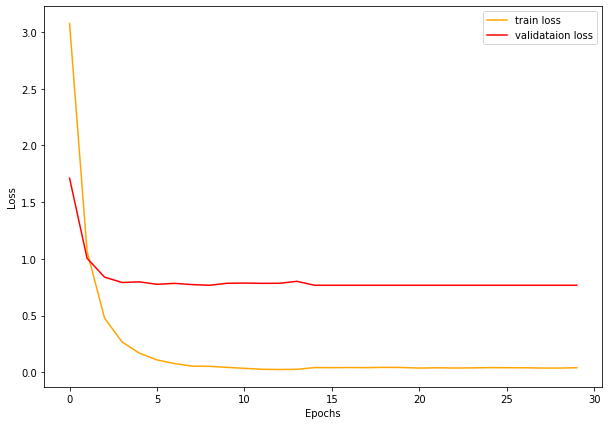

100%|██████████| 12/12 [00:08<00:00,  1.35it/s]

Test Accuracy: 0.8181818181818182


In [ ]:
BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_data_augmentation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=train_data_augmentation)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.classifier.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained freeze")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained freeze")
test(net,test_dataloader)

In [ ]:
from torchvision import models
dir(models)

def initialize_model(model_name,num_ftrs,num_classes,use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    use_linear = True

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        for name, child in model.named_children():
            for name2, params in child.named_parameters():
                params.requires_grad = True
        return model,224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        
    elif model_name == "vgg16":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        use_linear = False

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
        use_linear = False

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        
        

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)


    else:
        print("Invalid model name, exiting...")
        exit()
    
    if use_pretrained:
        for param in model_ft.classifier[6].parameters():
            param.requires_grad = True
    
    if use_linear:
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    return model_ft, input_size



Resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

100%|██████████| 181/181 [00:21<00:00,  8.25it/s]


Train Loss: 2.5456, Train Acc: 0.46
Val Loss: 2.0829, Val Acc: 0.56


Starting epoch 2/30, LR = [0.01]


Step 180, Loss 0.5608210563659668
Step 190, Loss 1.9784433841705322
Step 200, Loss 0.9901038408279419
Step 210, Loss 1.017153263092041
Step 220, Loss 1.0094257593154907
Step 230, Loss 2.498781442642212
Step 240, Loss 0.27510035037994385
Step 250, Loss 1.6446398496627808
Step 260, Loss 1.031453251838684
Step 270, Loss 1.5001966953277588
Step 280, Loss 0.6875768303871155
Step 290, Loss 1.1128647327423096
Step 300, Loss 1.9911550283432007
Step 310, Loss 1.1010396480560303
Step 320, Loss 1.2494480609893799
Step 330, Loss 1.3236563205718994
Step 340, Loss 0.6216899156570435
Step 350, Loss 0.7805902361869812


100%|██████████| 181/181 [00:21<00:00,  8.31it/s]


Train Loss: 1.3561, Train Acc: 0.66
Val Loss: 1.1299, Val Acc: 0.72


Starting epoch 3/30, LR = [0.01]


Step 360, Loss 0.7636977434158325
Step 370, Loss 0.9187480211257935
Step 380, Loss 1.1504302024841309
Step 390, Loss 0.6954023241996765
Step 400, Loss 0.27013441920280457
Step 410, Loss 1.336470365524292
Step 420, Loss 0.30445608496665955
Step 430, Loss 0.2365228533744812
Step 440, Loss 0.5835903286933899
Step 450, Loss 0.3270415961742401
Step 460, Loss 0.753735363483429
Step 470, Loss 0.22898685932159424
Step 480, Loss 1.4406074285507202
Step 490, Loss 0.5206427574157715
Step 500, Loss 0.6313085556030273
Step 510, Loss 0.5926530957221985
Step 520, Loss 0.4791784882545471
Step 530, Loss 0.8165459632873535


100%|██████████| 181/181 [00:21<00:00,  8.23it/s]


Train Loss: 0.6455, Train Acc: 0.82
Val Loss: 0.9729, Val Acc: 0.76


Starting epoch 4/30, LR = [0.01]


Step 540, Loss 0.3189171254634857
Step 550, Loss 0.08988863229751587
Step 560, Loss 0.35144728422164917
Step 570, Loss 0.26709502935409546
Step 580, Loss 0.4438585042953491
Step 590, Loss 0.22422659397125244
Step 600, Loss 0.26866886019706726
Step 610, Loss 0.20729929208755493
Step 620, Loss 0.3471600413322449
Step 630, Loss 0.14044404029846191
Step 640, Loss 0.12101370096206665
Step 650, Loss 0.4452137351036072
Step 660, Loss 0.6114698648452759
Step 670, Loss 0.09644284844398499
Step 680, Loss 0.21771129965782166
Step 690, Loss 0.5925907492637634
Step 700, Loss 0.6078662872314453
Step 710, Loss 0.6827152967453003


100%|██████████| 181/181 [00:21<00:00,  8.23it/s]


Train Loss: 0.3350, Train Acc: 0.90
Val Loss: 0.7862, Val Acc: 0.81


Starting epoch 5/30, LR = [0.01]


Step 720, Loss 0.055219411849975586
Step 730, Loss 0.2992256283760071
Step 740, Loss 0.21079915761947632
Step 750, Loss 0.4346223473548889
Step 760, Loss 0.21147212386131287
Step 770, Loss 0.1697249412536621
Step 780, Loss 0.3594713509082794
Step 790, Loss 0.2014119029045105
Step 800, Loss 0.21574586629867554
Step 810, Loss 0.05794206261634827
Step 820, Loss 0.69672030210495
Step 830, Loss 0.10714000463485718
Step 840, Loss 0.14139151573181152
Step 850, Loss 0.3375135660171509
Step 860, Loss 0.33953577280044556
Step 870, Loss 0.641275942325592
Step 880, Loss 0.06649428606033325
Step 890, Loss 0.10185891389846802


100%|██████████| 181/181 [00:21<00:00,  8.24it/s]


Train Loss: 0.2627, Train Acc: 0.92
Val Loss: 0.7846, Val Acc: 0.80


Starting epoch 6/30, LR = [0.01]


Step 900, Loss 0.041626036167144775
Step 910, Loss 0.03609347343444824
Step 920, Loss 0.02339571714401245
Step 930, Loss 0.07469388842582703
Step 940, Loss 0.2658092677593231
Step 950, Loss 0.14533886313438416
Step 960, Loss 0.16838952898979187
Step 970, Loss 0.12820029258728027
Step 980, Loss 0.19784915447235107
Step 990, Loss 0.01934373378753662
Step 1000, Loss 0.3634275197982788
Step 1010, Loss 0.15574708580970764
Step 1020, Loss 0.019799888134002686
Step 1030, Loss 0.12570473551750183
Step 1040, Loss 0.1217847466468811
Step 1050, Loss 0.02585965394973755
Step 1060, Loss 0.01526576280593872
Step 1070, Loss 0.09726306796073914


100%|██████████| 181/181 [00:21<00:00,  8.24it/s]


Train Loss: 0.1563, Train Acc: 0.95
Val Loss: 0.6404, Val Acc: 0.84


Starting epoch 7/30, LR = [0.01]


Step 1080, Loss 0.030554533004760742
Step 1090, Loss 0.06951069831848145
Step 1100, Loss 0.14760279655456543
Step 1110, Loss 0.013542473316192627
Step 1120, Loss 0.11771023273468018
Step 1130, Loss 0.009632408618927002
Step 1140, Loss 0.20806768536567688
Step 1150, Loss 0.08784791827201843
Step 1160, Loss 0.2179844081401825
Step 1170, Loss 0.026903212070465088
Step 1180, Loss 0.04307979345321655
Step 1190, Loss 0.08613359928131104
Step 1200, Loss 0.039628565311431885
Step 1210, Loss 0.22693544626235962
Step 1220, Loss 0.2954941391944885
Step 1230, Loss 0.020825862884521484
Step 1240, Loss 0.30828857421875
Step 1250, Loss 0.005849003791809082


100%|██████████| 181/181 [00:21<00:00,  8.31it/s]


Train Loss: 0.1048, Train Acc: 0.96
Val Loss: 0.6159, Val Acc: 0.84


Starting epoch 8/30, LR = [0.01]


Step 1260, Loss 0.09170398116111755
Step 1270, Loss 0.08740657567977905
Step 1280, Loss 0.09490227699279785
Step 1290, Loss 0.02646869421005249
Step 1300, Loss 0.012958228588104248
Step 1310, Loss 0.0331876277923584
Step 1320, Loss 0.06198924779891968
Step 1330, Loss 0.059320807456970215
Step 1340, Loss 0.021954119205474854
Step 1350, Loss 0.0030179619789123535
Step 1360, Loss 0.013144314289093018
Step 1370, Loss 0.01068127155303955
Step 1380, Loss 0.002934098243713379
Step 1390, Loss 0.02199268341064453
Step 1400, Loss 0.018017292022705078
Step 1410, Loss 0.055319517850875854
Step 1420, Loss 0.06672883033752441
Step 1430, Loss 0.022565245628356934


100%|██████████| 181/181 [00:21<00:00,  8.26it/s]


Train Loss: 0.0620, Train Acc: 0.98
Val Loss: 0.4851, Val Acc: 0.87


Starting epoch 9/30, LR = [0.01]


Step 1440, Loss 0.013031244277954102
Step 1450, Loss 0.024030864238739014
Step 1460, Loss 0.05465579032897949
Step 1470, Loss 0.008833825588226318
Step 1480, Loss 0.004864931106567383
Step 1490, Loss 0.0064084529876708984
Step 1500, Loss 0.02644580602645874
Step 1510, Loss 0.04286396503448486
Step 1520, Loss 0.003697633743286133
Step 1530, Loss 0.0018904805183410645
Step 1540, Loss 0.003335714340209961
Step 1550, Loss 0.0008901357650756836
Step 1560, Loss 0.004668176174163818
Step 1570, Loss 0.0103759765625
Step 1580, Loss 0.0171663761138916
Step 1590, Loss 0.039577364921569824
Step 1600, Loss 0.0030901432037353516
Step 1610, Loss 0.01851433515548706


100%|██████████| 181/181 [00:21<00:00,  8.27it/s]


Train Loss: 0.0226, Train Acc: 0.99
Val Loss: 0.5170, Val Acc: 0.87


Starting epoch 10/30, LR = [0.01]


Step 1620, Loss 0.16477185487747192
Step 1630, Loss 0.005679786205291748
Step 1640, Loss 0.002079606056213379
Step 1650, Loss 0.0017883777618408203
Step 1660, Loss 0.011078894138336182
Step 1670, Loss 0.4052507281303406
Step 1680, Loss 0.019891679286956787
Step 1690, Loss 0.015618383884429932
Step 1700, Loss 0.08703699707984924
Step 1710, Loss 0.006781280040740967
Step 1720, Loss 0.02057787775993347
Step 1730, Loss 0.02508753538131714
Step 1740, Loss 0.0008916854858398438
Step 1750, Loss 0.008008956909179688
Step 1760, Loss 0.012939512729644775
Step 1770, Loss 0.02395862340927124
Step 1780, Loss 0.003816545009613037
Step 1790, Loss 0.09450697898864746


100%|██████████| 181/181 [00:22<00:00,  8.18it/s]


Train Loss: 0.0239, Train Acc: 0.99
Val Loss: 0.4588, Val Acc: 0.88


Starting epoch 11/30, LR = [0.01]


Step 1800, Loss 0.08574157953262329
Step 1810, Loss 0.0013406872749328613
Step 1820, Loss 0.29450714588165283
Step 1830, Loss 0.009560763835906982
Step 1840, Loss 0.014495313167572021
Step 1850, Loss 0.014991700649261475
Step 1860, Loss 0.00307542085647583
Step 1870, Loss 0.005801081657409668
Step 1880, Loss 0.023784995079040527
Step 1890, Loss 0.00600278377532959
Step 1900, Loss 0.0015847086906433105
Step 1910, Loss 0.003565073013305664
Step 1920, Loss 0.055136263370513916
Step 1930, Loss 0.012093424797058105
Step 1940, Loss 0.004340827465057373
Step 1950, Loss 0.0027767419815063477
Step 1960, Loss 0.013534486293792725
Step 1970, Loss 0.000611722469329834


100%|██████████| 181/181 [00:22<00:00,  8.18it/s]


Train Loss: 0.0142, Train Acc: 0.99
Val Loss: 0.3903, Val Acc: 0.90


Starting epoch 12/30, LR = [0.01]


Step 1980, Loss 0.01039975881576538
Step 1990, Loss 0.0003211498260498047
Step 2000, Loss 0.0008972883224487305
Step 2010, Loss 0.005632221698760986
Step 2020, Loss 0.0008647441864013672
Step 2030, Loss 0.002240121364593506
Step 2040, Loss 0.003954887390136719
Step 2050, Loss 0.021499335765838623
Step 2060, Loss 0.005047976970672607
Step 2070, Loss 0.0022034049034118652
Step 2080, Loss 0.0024866461753845215
Step 2090, Loss 0.0005342960357666016
Step 2100, Loss 0.005373477935791016
Step 2110, Loss 0.008764326572418213
Step 2120, Loss 0.0014652013778686523
Step 2130, Loss 0.0017960667610168457
Step 2140, Loss 0.016694605350494385
Step 2150, Loss 0.003606736660003662


100%|██████████| 181/181 [00:22<00:00,  8.22it/s]


Train Loss: 0.0062, Train Acc: 0.99
Val Loss: 0.3882, Val Acc: 0.91


Starting epoch 13/30, LR = [0.01]


Step 2160, Loss 0.023336350917816162
Step 2170, Loss 0.0010033249855041504
Step 2180, Loss 0.005541443824768066
Step 2190, Loss 0.00864565372467041
Step 2200, Loss 0.001941382884979248
Step 2210, Loss 0.0059697628021240234
Step 2220, Loss 0.0006031394004821777
Step 2230, Loss 0.0007488131523132324
Step 2240, Loss 0.001360774040222168
Step 2250, Loss 0.011858522891998291
Step 2260, Loss 0.003857433795928955
Step 2270, Loss 0.0023654699325561523
Step 2280, Loss 0.02815854549407959
Step 2290, Loss 0.0015084147453308105
Step 2300, Loss 0.0033199191093444824
Step 2310, Loss 0.0010249614715576172
Step 2320, Loss 0.0015062689781188965
Step 2330, Loss 0.009259939193725586


100%|██████████| 181/181 [00:21<00:00,  8.25it/s]


Train Loss: 0.0050, Train Acc: 0.99
Val Loss: 0.3817, Val Acc: 0.91


Starting epoch 14/30, LR = [0.01]


Step 2340, Loss 0.0011065006256103516
Step 2350, Loss 0.0009614825248718262
Step 2360, Loss 0.0010377764701843262
Step 2370, Loss 0.00044602155685424805
Step 2380, Loss 0.003564178943634033
Step 2390, Loss 0.0014190673828125
Step 2400, Loss 0.0001582503318786621
Step 2410, Loss 0.0010623931884765625
Step 2420, Loss 0.0003267526626586914
Step 2430, Loss 0.0007587671279907227
Step 2440, Loss 0.0011757612228393555
Step 2450, Loss 0.000972747802734375
Step 2460, Loss 0.00017845630645751953
Step 2470, Loss 0.0021602511405944824
Step 2480, Loss 0.0010446906089782715
Step 2490, Loss 0.004437685012817383
Step 2500, Loss 0.004499197006225586
Step 2510, Loss 0.0012616515159606934


100%|██████████| 181/181 [00:22<00:00,  8.19it/s]


Train Loss: 0.0020, Train Acc: 1.00
Val Loss: 0.3555, Val Acc: 0.91


Starting epoch 15/30, LR = [0.01]


Step 2520, Loss 0.0005416274070739746
Step 2530, Loss 0.0013245344161987305
Step 2540, Loss 0.008178949356079102
Step 2550, Loss 0.0008379817008972168
Step 2560, Loss 0.00031691789627075195
Step 2570, Loss 9.548664093017578e-05
Step 2580, Loss 0.0002903938293457031
Step 2590, Loss 0.0006676912307739258
Step 2600, Loss 0.0011268258094787598
Step 2610, Loss 0.00047087669372558594
Step 2620, Loss 0.0012110471725463867
Step 2630, Loss 0.0007513165473937988
Step 2640, Loss 0.00026917457580566406
Step 2650, Loss 0.002241849899291992
Step 2660, Loss 0.0007766485214233398
Step 2670, Loss 0.0006672143936157227
Step 2680, Loss 0.00015020370483398438
Step 2690, Loss 0.0007429718971252441


100%|██████████| 181/181 [00:21<00:00,  8.25it/s]


Train Loss: 0.0020, Train Acc: 1.00
Val Loss: 0.3628, Val Acc: 0.91


Starting epoch 16/30, LR = [0.01]


Step 2700, Loss 0.000892937183380127
Step 2710, Loss 0.0006017684936523438
Step 2720, Loss 5.131959915161133e-05
Step 2730, Loss 0.0010418295860290527
Step 2740, Loss 0.0008962750434875488
Step 2750, Loss 0.0005677342414855957
Step 2760, Loss 0.0011731982231140137
Step 2770, Loss 0.00047844648361206055
Step 2780, Loss 0.0007941126823425293
Step 2790, Loss 0.00033032894134521484
Step 2800, Loss 0.0012645721435546875
Step 2810, Loss 0.0013682246208190918
Step 2820, Loss 0.0006331801414489746
Step 2830, Loss 0.00020903348922729492
Step 2840, Loss 0.0010032057762145996
Step 2850, Loss 9.393692016601562e-05
Step 2860, Loss 0.002462625503540039
Step 2870, Loss 0.0013692378997802734


100%|██████████| 181/181 [00:21<00:00,  8.25it/s]


Train Loss: 0.0016, Train Acc: 1.00
Val Loss: 0.3580, Val Acc: 0.91


Starting epoch 17/30, LR = [0.01]


Step 2880, Loss 0.00045245885848999023
Step 2890, Loss 0.001353919506072998
Step 2900, Loss 0.002249419689178467
Step 2910, Loss 0.0007203221321105957
Step 2920, Loss 0.00044614076614379883
Step 2930, Loss 0.004734635353088379
Step 2940, Loss 0.0012407302856445312
Step 2950, Loss 0.00032073259353637695
Step 2960, Loss 0.0021933913230895996
Step 2970, Loss 0.0001556873321533203
Step 2980, Loss 0.0004176497459411621
Step 2990, Loss 0.001744389533996582
Step 3000, Loss 6.848573684692383e-05
Step 3010, Loss 0.0001430511474609375
Step 3020, Loss 0.0003110170364379883
Step 3030, Loss 0.0012384653091430664
Step 3040, Loss 0.00031828880310058594
Step 3050, Loss 0.0008458495140075684


100%|██████████| 181/181 [00:21<00:00,  8.24it/s]


Train Loss: 0.0015, Train Acc: 1.00
Val Loss: 0.3515, Val Acc: 0.92


Starting epoch 18/30, LR = [0.01]


Step 3060, Loss 0.00036597251892089844
Step 3070, Loss 0.0030333995819091797
Step 3080, Loss 0.00027298927307128906
Step 3090, Loss 0.0002504587173461914
Step 3100, Loss 0.00032633543014526367
Step 3110, Loss 0.0004839897155761719
Step 3120, Loss 0.0005390644073486328
Step 3130, Loss 0.00284498929977417
Step 3140, Loss 0.0011827349662780762
Step 3150, Loss 0.0002493858337402344
Step 3160, Loss 0.0017885565757751465
Step 3170, Loss 0.011626899242401123
Step 3180, Loss 0.0002034306526184082
Step 3190, Loss 0.0008628368377685547
Step 3200, Loss 0.0004285573959350586
Step 3210, Loss 0.0005792975425720215
Step 3220, Loss 0.004799544811248779
Step 3230, Loss 0.0019857287406921387


100%|██████████| 181/181 [00:21<00:00,  8.23it/s]


Train Loss: 0.0018, Train Acc: 1.00
Val Loss: 0.3419, Val Acc: 0.92


Starting epoch 19/30, LR = [0.01]


Step 3240, Loss 0.000691831111907959
Step 3250, Loss 0.0006123781204223633
Step 3260, Loss 0.0014034509658813477
Step 3270, Loss 0.0011867284774780273
Step 3280, Loss 0.0008899569511413574
Step 3290, Loss 0.00026679039001464844
Step 3300, Loss 0.0014764666557312012
Step 3310, Loss 0.00022852420806884766
Step 3320, Loss 0.00041162967681884766
Step 3330, Loss 0.00010955333709716797
Step 3340, Loss 0.00021338462829589844
Step 3350, Loss 0.0008826255798339844
Step 3360, Loss 0.0006951689720153809
Step 3370, Loss 0.00026726722717285156
Step 3380, Loss 0.0003637075424194336
Step 3390, Loss 0.0005374550819396973
Step 3400, Loss 0.00021499395370483398
Step 3410, Loss 0.00012767314910888672


100%|██████████| 181/181 [00:22<00:00,  8.14it/s]


Train Loss: 0.0012, Train Acc: 1.00
Val Loss: 0.3453, Val Acc: 0.91


Starting epoch 20/30, LR = [0.01]


Step 3420, Loss 0.004939138889312744
Step 3430, Loss 0.0011637210845947266
Step 3440, Loss 0.0005949139595031738
Step 3450, Loss 4.9591064453125e-05
Step 3460, Loss 0.0020049214363098145
Step 3470, Loss 0.0002948641777038574
Step 3480, Loss 0.0002085566520690918
Step 3490, Loss 0.0005575418472290039
Step 3500, Loss 0.0010748505592346191
Step 3510, Loss 0.001368105411529541
Step 3520, Loss 0.0004895925521850586
Step 3530, Loss 0.001128852367401123
Step 3540, Loss 0.0001900792121887207
Step 3550, Loss 0.00014835596084594727
Step 3560, Loss 0.00016987323760986328
Step 3570, Loss 0.00131988525390625
Step 3580, Loss 0.0009080767631530762
Step 3590, Loss 0.00018525123596191406


100%|██████████| 181/181 [00:21<00:00,  8.25it/s]


Train Loss: 0.0010, Train Acc: 1.00
Val Loss: 0.3456, Val Acc: 0.91


Starting epoch 21/30, LR = [0.001]


Step 3600, Loss 0.001641690731048584
Step 3610, Loss 0.0010846853256225586
Step 3620, Loss 0.0001659393310546875
Step 3630, Loss 0.00015354156494140625
Step 3640, Loss 0.0003001093864440918
Step 3650, Loss 0.0016190409660339355
Step 3660, Loss 0.002082645893096924
Step 3670, Loss 0.0002180337905883789
Step 3680, Loss 0.00018334388732910156
Step 3690, Loss 0.0010600090026855469
Step 3700, Loss 0.0010395050048828125
Step 3710, Loss 0.0021321773529052734
Step 3720, Loss 0.00022339820861816406
Step 3730, Loss 0.0002155303955078125
Step 3740, Loss 0.00036388635635375977
Step 3750, Loss 0.0003447532653808594
Step 3760, Loss 0.0007060766220092773
Step 3770, Loss 0.0009248256683349609


100%|██████████| 181/181 [00:22<00:00,  8.21it/s]


Train Loss: 0.0009, Train Acc: 1.00
Val Loss: 0.3418, Val Acc: 0.91


Starting epoch 22/30, LR = [0.001]


Step 3780, Loss 0.00020009279251098633
Step 3790, Loss 0.0005041956901550293
Step 3800, Loss 0.0014349818229675293
Step 3810, Loss 0.0014249086380004883
Step 3820, Loss 0.000418245792388916
Step 3830, Loss 0.00022268295288085938
Step 3840, Loss 0.00030410289764404297
Step 3850, Loss 4.279613494873047e-05
Step 3860, Loss 0.00022858381271362305
Step 3870, Loss 0.0012304186820983887
Step 3880, Loss 0.0028852224349975586
Step 3890, Loss 0.0001913905143737793
Step 3900, Loss 0.000406801700592041
Step 3910, Loss 0.00041049718856811523
Step 3920, Loss 0.00018393993377685547
Step 3930, Loss 0.0003509521484375
Step 3940, Loss 0.0005158782005310059
Step 3950, Loss 0.0006904006004333496


100%|██████████| 181/181 [00:22<00:00,  8.18it/s]


Train Loss: 0.0008, Train Acc: 1.00
Val Loss: 0.3423, Val Acc: 0.91


Starting epoch 23/30, LR = [0.001]


Step 3960, Loss 0.00013005733489990234
Step 3970, Loss 0.00028079748153686523
Step 3980, Loss 0.00012230873107910156
Step 3990, Loss 0.00013947486877441406
Step 4000, Loss 0.00010901689529418945
Step 4010, Loss 0.0014547109603881836
Step 4020, Loss 0.00122833251953125
Step 4030, Loss 0.0005654096603393555
Step 4040, Loss 0.0012308359146118164
Step 4050, Loss 0.00016391277313232422
Step 4060, Loss 0.0001513361930847168
Step 4070, Loss 0.000569760799407959
Step 4080, Loss 0.00012218952178955078
Step 4090, Loss 0.00017523765563964844
Step 4100, Loss 0.0008265376091003418
Step 4110, Loss 0.0024986863136291504
Step 4120, Loss 0.000317990779876709
Step 4130, Loss 0.005414903163909912


100%|██████████| 181/181 [00:21<00:00,  8.26it/s]


Train Loss: 0.0008, Train Acc: 1.00
Val Loss: 0.3429, Val Acc: 0.91


Starting epoch 24/30, LR = [0.001]


Step 4140, Loss 0.00020879507064819336
Step 4150, Loss 0.0008756518363952637
Step 4160, Loss 0.0009836554527282715
Step 4170, Loss 0.00014889240264892578
Step 4180, Loss 0.0004999637603759766
Step 4190, Loss 0.00034308433532714844
Step 4200, Loss 0.0002391338348388672
Step 4210, Loss 0.0006934404373168945
Step 4220, Loss 0.0011362433433532715
Step 4230, Loss 0.00016224384307861328
Step 4240, Loss 0.0001754164695739746
Step 4250, Loss 0.00015395879745483398
Step 4260, Loss 0.00018864870071411133
Step 4270, Loss 0.00045949220657348633
Step 4280, Loss 0.00016355514526367188
Step 4290, Loss 0.0003832578659057617
Step 4300, Loss 0.0005060434341430664
Step 4310, Loss 6.878376007080078e-05


100%|██████████| 181/181 [00:21<00:00,  8.29it/s]


Train Loss: 0.0008, Train Acc: 1.00
Val Loss: 0.3374, Val Acc: 0.92


Starting epoch 25/30, LR = [0.001]


Step 4320, Loss 0.0005145072937011719
Step 4330, Loss 0.0001716017723083496
Step 4340, Loss 0.00895226001739502
Step 4350, Loss 0.00037032365798950195
Step 4360, Loss 0.0007621645927429199
Step 4370, Loss 0.0009009838104248047
Step 4380, Loss 0.0009467601776123047
Step 4390, Loss 0.0014069676399230957
Step 4400, Loss 0.00012105703353881836
Step 4410, Loss 0.0006581544876098633
Step 4420, Loss 0.0004894137382507324
Step 4430, Loss 0.00011199712753295898
Step 4440, Loss 0.0003401041030883789
Step 4450, Loss 0.00033336877822875977
Step 4460, Loss 0.00010716915130615234
Step 4470, Loss 0.0002720355987548828
Step 4480, Loss 0.00026214122772216797
Step 4490, Loss 0.00015616416931152344


100%|██████████| 181/181 [00:21<00:00,  8.32it/s]


Train Loss: 0.0009, Train Acc: 1.00
Val Loss: 0.3394, Val Acc: 0.91


Starting epoch 26/30, LR = [0.001]


Step 4500, Loss 0.0006122589111328125
Step 4510, Loss 0.0019800662994384766
Step 4520, Loss 0.00015240907669067383
Step 4530, Loss 2.5987625122070312e-05
Step 4540, Loss 0.00035321712493896484
Step 4550, Loss 0.00011026859283447266
Step 4560, Loss 0.00047153234481811523
Step 4570, Loss 0.0005574822425842285
Step 4580, Loss 0.0015928149223327637
Step 4590, Loss 0.00015789270401000977
Step 4600, Loss 0.004396617412567139
Step 4610, Loss 0.00923854112625122
Step 4620, Loss 0.00020003318786621094
Step 4630, Loss 0.00018286705017089844
Step 4640, Loss 0.001040816307067871
Step 4650, Loss 0.00042313337326049805
Step 4660, Loss 8.0108642578125e-05
Step 4670, Loss 0.0015279650688171387


100%|██████████| 181/181 [00:21<00:00,  8.24it/s]


Train Loss: 0.0023, Train Acc: 1.00
Val Loss: 0.3428, Val Acc: 0.91


Starting epoch 27/30, LR = [0.001]


Step 4680, Loss 0.000385284423828125
Step 4690, Loss 0.0003361701965332031
Step 4700, Loss 0.000457763671875
Step 4710, Loss 0.00031769275665283203
Step 4720, Loss 0.0003713369369506836
Step 4730, Loss 0.0007656216621398926
Step 4740, Loss 8.887052536010742e-05
Step 4750, Loss 0.0011979341506958008
Step 4760, Loss 0.0001639723777770996
Step 4770, Loss 0.0019712448120117188
Step 4780, Loss 0.002586185932159424
Step 4790, Loss 0.0007528066635131836
Step 4800, Loss 0.0001043081283569336
Step 4810, Loss 0.001226961612701416
Step 4820, Loss 0.001635730266571045
Step 4830, Loss 0.0006604194641113281
Step 4840, Loss 0.0009155869483947754
Step 4850, Loss 0.0001780390739440918


100%|██████████| 181/181 [00:22<00:00,  8.21it/s]


Train Loss: 0.0016, Train Acc: 1.00
Val Loss: 0.3402, Val Acc: 0.91


Starting epoch 28/30, LR = [0.001]


Step 4860, Loss 0.0003352165222167969
Step 4870, Loss 0.0002745985984802246
Step 4880, Loss 0.0013350844383239746
Step 4890, Loss 0.0003744363784790039
Step 4900, Loss 0.0003617405891418457
Step 4910, Loss 0.00011551380157470703
Step 4920, Loss 0.000615239143371582
Step 4930, Loss 0.0005090832710266113
Step 4940, Loss 0.0007236003875732422
Step 4950, Loss 0.0001601576805114746
Step 4960, Loss 0.0015639662742614746
Step 4970, Loss 0.0006022453308105469
Step 4980, Loss 0.0007075667381286621
Step 4990, Loss 0.0006533265113830566
Step 5000, Loss 0.001513361930847168
Step 5010, Loss 0.000678718090057373
Step 5020, Loss 0.006668746471405029
Step 5030, Loss 7.224082946777344e-05


100%|██████████| 181/181 [00:21<00:00,  8.25it/s]


Train Loss: 0.0012, Train Acc: 1.00
Val Loss: 0.3356, Val Acc: 0.91


Starting epoch 29/30, LR = [0.001]


Step 5040, Loss 0.0008167624473571777
Step 5050, Loss 0.000213623046875
Step 5060, Loss 0.00010758638381958008
Step 5070, Loss 0.0001952052116394043
Step 5080, Loss 0.0002484321594238281
Step 5090, Loss 0.0005081295967102051
Step 5100, Loss 0.00031363964080810547
Step 5110, Loss 8.654594421386719e-05
Step 5120, Loss 0.0008088946342468262
Step 5130, Loss 0.0001240372657775879
Step 5140, Loss 0.00058746337890625
Step 5150, Loss 0.0002532005310058594
Step 5160, Loss 0.000948488712310791
Step 5170, Loss 0.0005400776863098145
Step 5180, Loss 0.0009680390357971191
Step 5190, Loss 0.00047713518142700195
Step 5200, Loss 0.0002688169479370117
Step 5210, Loss 0.0004729032516479492


100%|██████████| 181/181 [00:22<00:00,  8.23it/s]


Train Loss: 0.0010, Train Acc: 1.00
Val Loss: 0.3425, Val Acc: 0.91


Starting epoch 30/30, LR = [0.001]


Step 5220, Loss 0.0001055002212524414
Step 5230, Loss 0.0007296204566955566
Step 5240, Loss 0.00012558698654174805
Step 5250, Loss 0.00015336275100708008
Step 5260, Loss 0.0006099939346313477
Step 5270, Loss 0.0008143186569213867
Step 5280, Loss 0.0008986592292785645
Step 5290, Loss 0.00020188093185424805
Step 5300, Loss 0.0005878806114196777
Step 5310, Loss 0.0013135671615600586
Step 5320, Loss 0.00017833709716796875
Step 5330, Loss 0.0007742643356323242
Step 5340, Loss 0.0006048083305358887
Step 5350, Loss 0.0031487345695495605
Step 5360, Loss 0.00010859966278076172
Step 5370, Loss 0.0006248950958251953
Step 5380, Loss 0.0036722421646118164
Step 5390, Loss 0.0033857226371765137


100%|██████████| 181/181 [00:21<00:00,  8.28it/s]



Train Loss: 0.0011, Train Acc: 1.00
Val Loss: 0.3401, Val Acc: 0.92


[(2.545638436079025, 0.45954356846473027), (1.3560785505506727, 0.6594052558782849), (0.6454930396543609, 0.822268326417704), (0.3349873352381918, 0.9004149377593361), (0.2627499043941498, 0.9208160442600276), (0.1563249584701326, 0.9547026279391425), (0.10484548674689399, 0.9633471645919779), (0.061951015227370794, 0.9782157676348547), (0.022559487819671632, 0.9906639004149378), (0.023864417605929906, 0.9903181189488244), (0.014175844192504884, 0.9930843706777317), (0.006194180912441677, 0.9948132780082988), (0.005018283757898543, 0.9948132780082988), (0.002015089823140038, 0.995850622406639), (0.0020285011993514167, 0.995850622406639), (0.0015953504376941257, 0.995850622406639), (0.0015176104174719916, 0.995850622406639), (0.0017725724312994216, 0.995850622406639), (0.001151292688316769, 0.995850622406639), (0.0009831690125995211, 0.995850622406639), (0.000897677739461263, 0.995850622406639), (0.000814548134803772

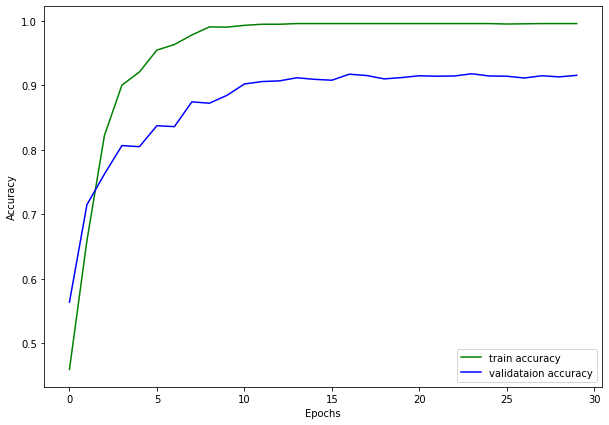

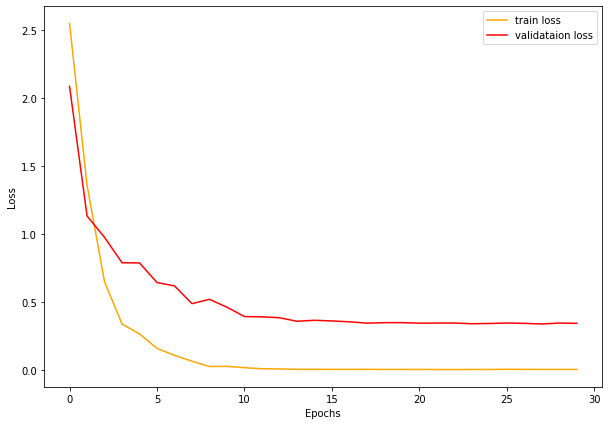

100%|██████████| 181/181 [00:21<00:00,  8.29it/s]

Test Accuracy: 0.9090909090909091


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 16   # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 10


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=preprocess)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net, input_size = initialize_model("resnet50",4096,NUM_CLASSES,use_pretrained=True)

print(net)

parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="alexnet_transfer_learning")
print_acc_loss(tl,ta,vl,va,"alexnet_transfer_learning")
test(net,test_dataloader)


VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

100%|██████████| 362/362 [00:55<00:00,  6.57it/s]



Train Loss: 3.9859, Train Acc: 0.24
Val Loss: 2.9188, Val Acc: 0.37


Starting epoch 2/30, LR = [0.001]
Step 370, Loss 2.227135181427002
Step 380, Loss 3.6373238563537598
Step 390, Loss 3.776360273361206
Step 400, Loss 2.254831552505493
Step 410, Loss 2.0923471450805664
Step 420, Loss 3.080889940261841
Step 430, Loss 1.376617670059204
Step 440, Loss 2.540794849395752
Step 450, Loss 2.829803943634033
Step 460, Loss 2.845144271850586
Step 470, Loss 2.7987730503082275
Step 480, Loss 2.8410112857818604
Step 490, Loss 2.58772349357605
Step 500, Loss 3.4818639755249023
Step 510, Loss 2.736072540283203
Step 520, Loss 2.5411534309387207
Step 530, Loss 3.814361095428467
Step 540, Loss 1.2106868028640747
Step 550, Loss 1.9262772798538208
Step 560, Loss 3.363445281982422
Step 570, Loss 3.415090560913086
Step 580, Loss 3.4738285541534424
Step 590, Loss 1.7209692001342773
Step 600, Loss 1.7910115718841553
Step 610, Loss 3.039685010910034
Step 620, Loss 2.1228857040405273
Step 630, Loss 2.070649862

100%|██████████| 362/362 [00:54<00:00,  6.58it/s]



Train Loss: 2.5339, Train Acc: 0.43
Val Loss: 1.9083, Val Acc: 0.55


Starting epoch 3/30, LR = [0.001]
Step 730, Loss 1.7021595239639282
Step 740, Loss 1.7994436025619507
Step 750, Loss 2.568180561065674
Step 760, Loss 1.980771541595459
Step 770, Loss 1.4462864398956299
Step 780, Loss 1.1518948078155518
Step 790, Loss 2.2973074913024902
Step 800, Loss 1.9751732349395752
Step 810, Loss 1.411559820175171
Step 820, Loss 0.2405989170074463
Step 830, Loss 1.6240826845169067
Step 840, Loss 0.9723169803619385
Step 850, Loss 1.1901589632034302
Step 860, Loss 1.8540011644363403
Step 870, Loss 1.8622360229492188
Step 880, Loss 0.30768871307373047
Step 890, Loss 2.7382543087005615
Step 900, Loss 1.0948923826217651
Step 910, Loss 1.147171974182129
Step 920, Loss 1.2232040166854858
Step 930, Loss 1.4823887348175049
Step 940, Loss 0.4623218774795532
Step 950, Loss 1.062143325805664
Step 960, Loss 1.4639424085617065
Step 970, Loss 1.9473876953125
Step 980, Loss 2.9891960620880127
Step 990, Loss 1.7

100%|██████████| 362/362 [00:55<00:00,  6.52it/s]



Train Loss: 1.5776, Train Acc: 0.61
Val Loss: 1.5784, Val Acc: 0.62


Starting epoch 4/30, LR = [0.001]
Step 1090, Loss 1.9126121997833252
Step 1100, Loss 0.7369388341903687
Step 1110, Loss 0.8887187242507935
Step 1120, Loss 0.9538133144378662
Step 1130, Loss 1.023557424545288
Step 1140, Loss 0.6050877571105957
Step 1150, Loss 0.8497214317321777
Step 1160, Loss 0.2901517152786255
Step 1170, Loss 0.6223617792129517
Step 1180, Loss 0.6252542734146118
Step 1190, Loss 0.8687341213226318
Step 1200, Loss 0.5665067434310913
Step 1210, Loss 0.5649313926696777
Step 1220, Loss 0.49052226543426514
Step 1230, Loss 0.6760424375534058
Step 1240, Loss 0.6786422729492188
Step 1250, Loss 0.6346241235733032
Step 1260, Loss 1.1208094358444214
Step 1270, Loss 0.552985429763794
Step 1280, Loss 0.7363342642784119
Step 1290, Loss 1.23550546169281
Step 1300, Loss 2.817392110824585
Step 1310, Loss 0.19678258895874023
Step 1320, Loss 0.781429648399353
Step 1330, Loss 0.24433505535125732
Step 1340, Loss 0.97178

100%|██████████| 362/362 [00:55<00:00,  6.55it/s]



Train Loss: 0.8680, Train Acc: 0.77
Val Loss: 1.2250, Val Acc: 0.70


Starting epoch 5/30, LR = [0.001]
Step 1450, Loss 0.8313976526260376
Step 1460, Loss 0.45343637466430664
Step 1470, Loss 1.1072635650634766
Step 1480, Loss 1.0537384748458862
Step 1490, Loss 0.2798408269882202
Step 1500, Loss 0.8944857120513916
Step 1510, Loss 0.9246765375137329
Step 1520, Loss 0.7927320003509521
Step 1530, Loss 0.23537158966064453
Step 1540, Loss 0.007651329040527344
Step 1550, Loss 0.9787577390670776
Step 1560, Loss 0.866610050201416
Step 1570, Loss 0.3432542085647583
Step 1580, Loss 0.2281942367553711
Step 1590, Loss 0.14312684535980225
Step 1600, Loss 0.1818615198135376
Step 1610, Loss 1.6425259113311768
Step 1620, Loss 1.5221666097640991
Step 1630, Loss 0.19118714332580566
Step 1640, Loss 0.4267061948776245
Step 1650, Loss 0.5561952590942383
Step 1660, Loss 0.08521759510040283
Step 1670, Loss 0.29771363735198975
Step 1680, Loss 0.20196568965911865
Step 1690, Loss 0.3415846824645996
Step 1700, L

100%|██████████| 362/362 [00:55<00:00,  6.53it/s]



Train Loss: 0.5842, Train Acc: 0.83
Val Loss: 1.2214, Val Acc: 0.70


Starting epoch 6/30, LR = [0.001]
Step 1810, Loss 0.6830973029136658
Step 1820, Loss 0.19268596172332764
Step 1830, Loss 0.39663052558898926
Step 1840, Loss 0.00013971328735351562
Step 1850, Loss 0.014829635620117188
Step 1860, Loss 0.001531839370727539
Step 1870, Loss 0.0980381965637207
Step 1880, Loss 0.21702277660369873
Step 1890, Loss 0.526079535484314
Step 1900, Loss 0.03925180435180664
Step 1910, Loss 0.09965658187866211
Step 1920, Loss 0.1813488006591797
Step 1930, Loss 0.06489825248718262
Step 1940, Loss 0.3298499584197998
Step 1950, Loss 0.14835166931152344
Step 1960, Loss 0.8149367570877075
Step 1970, Loss 0.8726785182952881
Step 1980, Loss 0.46306753158569336
Step 1990, Loss 2.025362730026245
Step 2000, Loss 0.46747875213623047
Step 2010, Loss 0.42074835300445557
Step 2020, Loss 0.08880460262298584
Step 2030, Loss 0.4137667417526245
Step 2040, Loss 0.5135020017623901
Step 2050, Loss 0.5259109735488892
Ste

100%|██████████| 362/362 [00:55<00:00,  6.55it/s]



Train Loss: 0.4403, Train Acc: 0.87
Val Loss: 0.9446, Val Acc: 0.78


Starting epoch 7/30, LR = [0.001]
Step 2170, Loss 0.06635487079620361
Step 2180, Loss 0.03078603744506836
Step 2190, Loss 0.5181692838668823
Step 2200, Loss 0.8965359926223755
Step 2210, Loss 0.33656084537506104
Step 2220, Loss 0.15266013145446777
Step 2230, Loss 0.08925342559814453
Step 2240, Loss 0.4901583194732666
Step 2250, Loss 0.07346796989440918
Step 2260, Loss 0.025224924087524414
Step 2270, Loss 0.034249305725097656
Step 2280, Loss 0.7481861114501953
Step 2290, Loss 0.670566201210022
Step 2300, Loss 0.00455164909362793
Step 2310, Loss 0.041960835456848145
Step 2320, Loss 0.15719401836395264
Step 2330, Loss 0.0430150032043457
Step 2340, Loss 0.37818455696105957
Step 2350, Loss 0.5580110549926758
Step 2360, Loss 0.12592029571533203
Step 2370, Loss 0.7333095073699951
Step 2380, Loss 0.2629190683364868
Step 2390, Loss 0.04138827323913574
Step 2400, Loss 0.8480236530303955
Step 2410, Loss 0.00635528564453125
Ste

100%|██████████| 362/362 [00:55<00:00,  6.57it/s]


Train Loss: 0.3188, Train Acc: 0.91
Val Loss: 0.9733, Val Acc: 0.77


Starting epoch 8/30, LR = [0.001]


Step 2530, Loss 0.6478750705718994
Step 2540, Loss 0.05318570137023926
Step 2550, Loss 0.2841165065765381
Step 2560, Loss 0.8525378704071045
Step 2570, Loss 0.0016276836395263672
Step 2580, Loss 0.017453432083129883
Step 2590, Loss 0.6553432941436768
Step 2600, Loss 0.041504502296447754
Step 2610, Loss 0.000213623046875
Step 2620, Loss 0.19953298568725586
Step 2630, Loss 0.013688802719116211
Step 2640, Loss 0.08037364482879639
Step 2650, Loss 0.08847391605377197
Step 2660, Loss 0.006121397018432617
Step 2670, Loss 0.10364091396331787
Step 2680, Loss 0.0014840364456176758
Step 2690, Loss 0.0015170574188232422
Step 2700, Loss 0.5672767162322998
Step 2710, Loss 0.028418540954589844
Step 2720, Loss 0.026520848274230957
Step 2730, Loss 0.2325727939605713
Step 2740, Loss 0.07779049873352051
Step 2750, Loss 0.004439830780029297
Step 2760, Loss 0.9048411250114441
Step 2770, Loss 0.37176477909088135
Step 2780, Loss 0.6513962745666504
Step 2790, Loss 0.6615965366363525
Step 2800, Loss 0.23257231

100%|██████████| 362/362 [00:55<00:00,  6.54it/s]



Train Loss: 0.1548, Train Acc: 0.96
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 9/30, LR = [0.001]
Step 2890, Loss 0.0015175342559814453
Step 2900, Loss 0.06331992149353027
Step 2910, Loss 0.003899097442626953
Step 2920, Loss 0.0018355846405029297
Step 2930, Loss 0.00030493736267089844
Step 2940, Loss 0.0004870891571044922
Step 2950, Loss 0.6145148277282715
Step 2960, Loss 0.0009217262268066406
Step 2970, Loss 0.0015707015991210938
Step 2980, Loss 0.466511607170105
Step 2990, Loss 0.3326423168182373
Step 3000, Loss 0.003326416015625
Step 3010, Loss 0.06244015693664551
Step 3020, Loss 0.06013226509094238
Step 3030, Loss 0.08325839042663574
Step 3040, Loss 0.1889880895614624
Step 3050, Loss 0.04888510704040527
Step 3060, Loss 0.6958237886428833
Step 3070, Loss 0.04896533489227295
Step 3080, Loss 0.047704458236694336
Step 3090, Loss 0.009085655212402344
Step 3100, Loss 0.5242379903793335
Step 3110, Loss 0.03443002700805664
Step 3120, Loss 0.24461579322814941
Step 3130, Loss 8.821487

100%|██████████| 362/362 [00:55<00:00,  6.53it/s]


Train Loss: 0.1485, Train Acc: 0.96
Val Loss: 0.9084, Val Acc: 0.80


Starting epoch 10/30, LR = [0.001]


Step 3250, Loss 0.09869182109832764
Step 3260, Loss 0.18603646755218506
Step 3270, Loss 0.021758556365966797
Step 3280, Loss 0.04284393787384033
Step 3290, Loss 0.002268552780151367
Step 3300, Loss 0.01877617835998535
Step 3310, Loss 0.0013668537139892578
Step 3320, Loss 0.0008060932159423828
Step 3330, Loss 0.012077808380126953
Step 3340, Loss 0.0018458366394042969
Step 3350, Loss 0.09929943084716797
Step 3360, Loss 0.0017545223236083984
Step 3370, Loss 0.001402139663696289
Step 3380, Loss 0.057892799377441406
Step 3390, Loss 0.003174304962158203
Step 3400, Loss 0.009900689125061035
Step 3410, Loss 0.0005328655242919922
Step 3420, Loss 0.02417278289794922
Step 3430, Loss 5.984306335449219e-05
Step 3440, Loss 0.0006651878356933594
Step 3450, Loss 0.05031728744506836
Step 3460, Loss 0.24216604232788086
Step 3470, Loss 0.02682948112487793
Step 3480, Loss 0.010575532913208008
Step 3490, Loss 0.049651384353637695
Step 3500, Loss 0.0029532909393310547
Step 3510, Loss 0.004391908645629883
St

100%|██████████| 362/362 [00:55<00:00,  6.56it/s]


Train Loss: 0.1035, Train Acc: 0.97
Val Loss: 0.8268, Val Acc: 0.81


Starting epoch 11/30, LR = [0.001]


Step 3610, Loss 0.06650519371032715
Step 3620, Loss 0.0035867691040039062
Step 3630, Loss 0.08139264583587646
Step 3640, Loss 0.003882884979248047
Step 3650, Loss 0.6259090900421143
Step 3660, Loss 0.017726898193359375
Step 3670, Loss 0.0038526058197021484
Step 3680, Loss 0.0025049448013305664
Step 3690, Loss 0.002748727798461914
Step 3700, Loss 0.0007814168930053711
Step 3710, Loss 0.0
Step 3720, Loss 0.027804851531982422
Step 3730, Loss 0.005490422248840332
Step 3740, Loss 0.01066279411315918
Step 3750, Loss 0.0005826950073242188
Step 3760, Loss 0.003688812255859375
Step 3770, Loss 0.0074160099029541016
Step 3780, Loss 0.028354644775390625
Step 3790, Loss 0.022356271743774414
Step 3800, Loss 0.00016736984252929688
Step 3810, Loss 0.0010187625885009766
Step 3820, Loss 0.0004918575286865234
Step 3830, Loss 0.028646469116210938
Step 3840, Loss 0.0022830963134765625
Step 3850, Loss 0.0024071931838989258
Step 3860, Loss 0.021645307540893555
Step 3870, Loss 0.08413219451904297
Step 3880, L

100%|██████████| 362/362 [00:55<00:00,  6.57it/s]


Train Loss: 0.0513, Train Acc: 0.99
Val Loss: 0.7557, Val Acc: 0.84


Starting epoch 12/30, LR = [0.001]


Step 3980, Loss 0.0006504058837890625
Step 3990, Loss 0.0057375431060791016
Step 4000, Loss 0.0022673606872558594
Step 4010, Loss 0.0006985664367675781
Step 4020, Loss 2.9325485229492188e-05
Step 4030, Loss 0.001627206802368164
Step 4040, Loss 0.0008256435394287109
Step 4050, Loss 4.482269287109375e-05
Step 4060, Loss 0.0024764537811279297
Step 4070, Loss 0.0002734661102294922
Step 4080, Loss 0.08590865135192871
Step 4090, Loss 0.23625409603118896
Step 4100, Loss 0.0802258849143982
Step 4110, Loss 0.0169295072555542
Step 4120, Loss 0.0005362033843994141
Step 4130, Loss 0.0013990402221679688
Step 4140, Loss 0.0003933906555175781
Step 4150, Loss 0.23304247856140137
Step 4160, Loss 9.632110595703125e-05
Step 4170, Loss 0.0017246007919311523
Step 4180, Loss 5.841255187988281e-05
Step 4190, Loss 0.003256559371948242
Step 4200, Loss 0.004683494567871094
Step 4210, Loss 0.00042700767517089844
Step 4220, Loss 0.0008537769317626953
Step 4230, Loss 0.1328521966934204
Step 4240, Loss 0.0511236190

100%|██████████| 362/362 [00:55<00:00,  6.55it/s]


Train Loss: 0.0308, Train Acc: 0.99
Val Loss: 0.7932, Val Acc: 0.82


Starting epoch 13/30, LR = [0.001]


Step 4340, Loss 0.0007107257843017578
Step 4350, Loss 0.0001342296600341797
Step 4360, Loss 0.08332443237304688
Step 4370, Loss 0.004967451095581055
Step 4380, Loss 0.0001919269561767578
Step 4390, Loss 0.0013806819915771484
Step 4400, Loss 0.009547710418701172
Step 4410, Loss 0.001459360122680664
Step 4420, Loss 0.011838197708129883
Step 4430, Loss 0.010653018951416016
Step 4440, Loss 0.0038328170776367188
Step 4450, Loss 5.173683166503906e-05
Step 4460, Loss 0.00917816162109375
Step 4470, Loss 0.03633737564086914
Step 4480, Loss 0.00024056434631347656
Step 4490, Loss 7.3909759521484375e-06
Step 4500, Loss 1.7404556274414062e-05
Step 4510, Loss 0.00021529197692871094
Step 4520, Loss 0.00019931793212890625
Step 4530, Loss 2.384185791015625e-06
Step 4540, Loss 0.3632979393005371
Step 4550, Loss 0.0008676052093505859
Step 4560, Loss 6.580352783203125e-05
Step 4570, Loss 0.0003993511199951172
Step 4580, Loss 0.0012416839599609375
Step 4590, Loss 0.0051767826080322266
Step 4600, Loss 0.000

100%|██████████| 362/362 [00:55<00:00,  6.53it/s]



Train Loss: 0.0282, Train Acc: 0.99
Val Loss: 0.7594, Val Acc: 0.84


Early stopping!
Starting epoch 14/30, LR = [0.001]
Step 4700, Loss 0.19482862949371338
Step 4710, Loss 0.0031987428665161133
Step 4720, Loss 0.00106048583984375
Step 4730, Loss 0.00017571449279785156
Step 4740, Loss 0.0954749584197998
Step 4750, Loss 7.772445678710938e-05
Step 4760, Loss 0.00026345252990722656
Step 4770, Loss 0.0008509159088134766
Step 4780, Loss 0.2600592374801636
Step 4790, Loss 0.042745351791381836
Step 4800, Loss 2.1457672119140625e-06
Step 4810, Loss 0.13388943672180176
Step 4820, Loss 0.05744457244873047
Step 4830, Loss 0.01091146469116211
Step 4840, Loss 0.01671731472015381
Step 4850, Loss 0.019640564918518066
Step 4860, Loss 0.0023169517517089844
Step 4870, Loss 3.5762786865234375e-05
Step 4880, Loss 0.0015926361083984375
Step 4890, Loss 0.10744261741638184
Step 4900, Loss 0.0011429786682128906
Step 4910, Loss 0.06103384494781494
Step 4920, Loss 0.006102323532104492
Step 4930, Loss 0.0538525

100%|██████████| 362/362 [00:55<00:00,  6.52it/s]


Train Loss: 0.0404, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 15/30, LR = [0.001]


Step 5060, Loss 0.33798813819885254
Step 5070, Loss 0.0014646053314208984
Step 5080, Loss 0.04333782196044922
Step 5090, Loss 0.0014107227325439453
Step 5100, Loss 0.08939564228057861
Step 5110, Loss 0.0711212158203125
Step 5120, Loss 0.09269869327545166
Step 5130, Loss 0.0004954338073730469
Step 5140, Loss 0.5117590427398682
Step 5150, Loss 0.01580488681793213
Step 5160, Loss 0.684910774230957
Step 5170, Loss 0.06653130054473877
Step 5180, Loss 0.012490510940551758
Step 5190, Loss 0.0001609325408935547
Step 5200, Loss 0.281419038772583
Step 5210, Loss 0.0031360387802124023
Step 5220, Loss 0.0009243488311767578
Step 5230, Loss 0.1949329376220703
Step 5240, Loss 0.006809592247009277
Step 5250, Loss 0.024268388748168945
Step 5260, Loss 0.0008342266082763672
Step 5270, Loss 0.0004961490631103516
Step 5280, Loss 0.03447985649108887
Step 5290, Loss 0.6686168909072876
Step 5300, Loss 0.0016236305236816406
Step 5310, Loss 0.003238677978515625
Step 5320, Loss 0.0044078826904296875
Step 5330, L

100%|██████████| 362/362 [00:55<00:00,  6.55it/s]


Train Loss: 0.0488, Train Acc: 0.99
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 16/30, LR = [0.001]


Step 5420, Loss 0.0005328655242919922
Step 5430, Loss 2.5033950805664062e-05
Step 5440, Loss 0.0002086162567138672
Step 5450, Loss 0.00011515617370605469
Step 5460, Loss 0.0003151893615722656
Step 5470, Loss 0.09125351905822754
Step 5480, Loss 0.0011057853698730469
Step 5490, Loss 0.005327463150024414
Step 5500, Loss 0.03668546676635742
Step 5510, Loss 0.024493813514709473
Step 5520, Loss 0.05015122890472412
Step 5530, Loss 0.002742767333984375
Step 5540, Loss 0.18989849090576172
Step 5550, Loss 0.02580428123474121
Step 5560, Loss 0.0040503740310668945
Step 5570, Loss 1.9073486328125e-06
Step 5580, Loss 0.08550143241882324
Step 5590, Loss 0.0022017955780029297
Step 5600, Loss 0.0031774044036865234
Step 5610, Loss 0.019890189170837402
Step 5620, Loss 0.0793607234954834
Step 5630, Loss 0.0024993419647216797
Step 5640, Loss 0.0216522216796875
Step 5650, Loss 0.4653644561767578
Step 5660, Loss 0.0007839202880859375
Step 5670, Loss 0.00112152099609375
Step 5680, Loss 0.008441686630249023
St

100%|██████████| 362/362 [00:55<00:00,  6.55it/s]


Train Loss: 0.0445, Train Acc: 0.99
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 17/30, LR = [0.001]


Step 5780, Loss 0.002404928207397461
Step 5790, Loss 0.013520956039428711
Step 5800, Loss 0.0010497570037841797
Step 5810, Loss 0.0006875991821289062
Step 5820, Loss 0.018754124641418457
Step 5830, Loss 4.076957702636719e-05
Step 5840, Loss 0.0007495880126953125
Step 5850, Loss 0.0044403076171875
Step 5860, Loss 0.019137859344482422
Step 5870, Loss 0.011476278305053711
Step 5880, Loss 0.0028214454650878906
Step 5890, Loss 0.009731531143188477
Step 5900, Loss 0.005707979202270508
Step 5910, Loss 0.00567936897277832
Step 5920, Loss 1.5497207641601562e-05
Step 5930, Loss 0.0006906986236572266
Step 5940, Loss 0.00032401084899902344
Step 5950, Loss 0.0014493465423583984
Step 5960, Loss 0.0037131309509277344
Step 5970, Loss 0.00829935073852539
Step 5980, Loss 0.0005753040313720703
Step 5990, Loss 0.19527626037597656
Step 6000, Loss 0.05618095397949219
Step 6010, Loss 0.0008478164672851562
Step 6020, Loss 0.028562307357788086
Step 6030, Loss 0.0007317066192626953
Step 6040, Loss 0.00308382511

100%|██████████| 362/362 [00:55<00:00,  6.52it/s]


Train Loss: 0.0459, Train Acc: 0.99
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 18/30, LR = [0.001]


Step 6140, Loss 0.0010304450988769531
Step 6150, Loss 0.03967928886413574
Step 6160, Loss 0.0024750232696533203
Step 6170, Loss 0.00046515464782714844
Step 6180, Loss 0.12397003173828125
Step 6190, Loss 0.05239677429199219
Step 6200, Loss 0.07597613334655762
Step 6210, Loss 0.0007314682006835938
Step 6220, Loss 0.03155684471130371
Step 6230, Loss 0.07167172431945801
Step 6240, Loss 0.022608518600463867
Step 6250, Loss 0.00026035308837890625
Step 6260, Loss 0.001363992691040039
Step 6270, Loss 0.12392807006835938
Step 6280, Loss 0.279571533203125
Step 6290, Loss 0.007516145706176758
Step 6300, Loss 0.00849604606628418
Step 6310, Loss 0.01720297336578369
Step 6320, Loss 0.005150794982910156
Step 6330, Loss 0.002362489700317383
Step 6340, Loss 0.02476048469543457
Step 6350, Loss 0.0019011497497558594
Step 6360, Loss 0.0004725456237792969
Step 6370, Loss 0.0023086071014404297
Step 6380, Loss 0.017628788948059082
Step 6390, Loss 0.000835418701171875
Step 6400, Loss 0.14055490493774414
Step 

100%|██████████| 362/362 [00:55<00:00,  6.55it/s]


Train Loss: 0.0442, Train Acc: 0.99
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 19/30, LR = [0.001]


Step 6500, Loss 0.003712892532348633
Step 6510, Loss 0.0005078315734863281
Step 6520, Loss 0.009156465530395508
Step 6530, Loss 0.00279998779296875
Step 6540, Loss 0.0020377635955810547
Step 6550, Loss 0.11731326580047607
Step 6560, Loss 0.0016357898712158203
Step 6570, Loss 0.0022194385528564453
Step 6580, Loss 0.02625107765197754
Step 6590, Loss 0.062062621116638184
Step 6600, Loss 0.005326509475708008
Step 6610, Loss 0.0004923343658447266
Step 6620, Loss 0.00022649765014648438
Step 6630, Loss 0.004151821136474609
Step 6640, Loss 0.007895946502685547
Step 6650, Loss 0.05079543590545654
Step 6660, Loss 0.012626886367797852
Step 6670, Loss 0.0004487037658691406
Step 6680, Loss 0.09167397022247314
Step 6690, Loss 0.4729257822036743
Step 6700, Loss 0.016430974006652832
Step 6710, Loss 9.5367431640625e-07
Step 6720, Loss 0.011799216270446777
Step 6730, Loss 0.000293731689453125
Step 6740, Loss 0.24254095554351807
Step 6750, Loss 0.07984256744384766
Step 6760, Loss 0.012152433395385742
Ste

100%|██████████| 362/362 [00:55<00:00,  6.56it/s]


Train Loss: 0.0465, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 20/30, LR = [0.001]


Step 6860, Loss 0.02458977699279785
Step 6870, Loss 0.0005588531494140625
Step 6880, Loss 0.0010712146759033203
Step 6890, Loss 0.07947313785552979
Step 6900, Loss 0.28613269329071045
Step 6910, Loss 2.7418136596679688e-05
Step 6920, Loss 0.03518319129943848
Step 6930, Loss 0.0021820068359375
Step 6940, Loss 0.14104795455932617
Step 6950, Loss 0.011423826217651367
Step 6960, Loss 0.06992912292480469
Step 6970, Loss 1.2874603271484375e-05
Step 6980, Loss 0.0007250308990478516
Step 6990, Loss 0.0024406909942626953
Step 7000, Loss 0.008486270904541016
Step 7010, Loss 0.002189159393310547
Step 7020, Loss 0.009147882461547852
Step 7030, Loss 0.0006771087646484375
Step 7040, Loss 0.007261037826538086
Step 7050, Loss 2.2411346435546875e-05
Step 7060, Loss 0.008418560028076172
Step 7070, Loss 0.0022521018981933594
Step 7080, Loss 0.10981035232543945
Step 7090, Loss 0.010882377624511719
Step 7100, Loss 0.2617776393890381
Step 7110, Loss 0.0033652782440185547
Step 7120, Loss 0.007035493850708008

100%|██████████| 362/362 [00:55<00:00,  6.55it/s]


Train Loss: 0.0544, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 21/30, LR = [0.0001]


Step 7220, Loss 0.0026335716247558594
Step 7230, Loss 0.0013248920440673828
Step 7240, Loss 0.08773207664489746
Step 7250, Loss 0.0005919933319091797
Step 7260, Loss 0.0029060840606689453
Step 7270, Loss 0.15240967273712158
Step 7280, Loss 0.0041582584381103516
Step 7290, Loss 0.003149747848510742
Step 7300, Loss 0.034032344818115234
Step 7310, Loss 0.0006198883056640625
Step 7320, Loss 0.04365396499633789
Step 7330, Loss 0.06131553649902344
Step 7340, Loss 0.2864009141921997
Step 7350, Loss 0.006995677947998047
Step 7360, Loss 0.006252169609069824
Step 7370, Loss 0.09055840969085693
Step 7380, Loss 0.02487027645111084
Step 7390, Loss 5.030632019042969e-05
Step 7400, Loss 0.003081083297729492
Step 7410, Loss 0.19523859024047852
Step 7420, Loss 0.08049345016479492
Step 7430, Loss 0.10015106201171875
Step 7440, Loss 0.0020569562911987305
Step 7450, Loss 0.06952142715454102
Step 7460, Loss 0.03554582595825195
Step 7470, Loss 0.0014617443084716797
Step 7480, Loss 0.2720557451248169
Step 74

100%|██████████| 362/362 [00:55<00:00,  6.54it/s]


Train Loss: 0.0438, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 22/30, LR = [0.0001]


Step 7590, Loss 0.006248950958251953
Step 7600, Loss 0.010440707206726074
Step 7610, Loss 0.08957350254058838
Step 7620, Loss 0.04083847999572754
Step 7630, Loss 0.008069515228271484
Step 7640, Loss 0.0012958049774169922
Step 7650, Loss 3.147125244140625e-05
Step 7660, Loss 0.0032148361206054688
Step 7670, Loss 0.08493173122406006
Step 7680, Loss 0.07454562187194824
Step 7690, Loss 0.009578227996826172
Step 7700, Loss 0.0048105716705322266
Step 7710, Loss 0.0028922557830810547
Step 7720, Loss 8.58306884765625e-05
Step 7730, Loss 0.016907215118408203
Step 7740, Loss 0.007550954818725586
Step 7750, Loss 0.00191497802734375
Step 7760, Loss 0.0025267601013183594
Step 7770, Loss 0.004225015640258789
Step 7780, Loss 0.0003521442413330078
Step 7790, Loss 0.0004215240478515625
Step 7800, Loss 0.3159346580505371
Step 7810, Loss 0.2490311861038208
Step 7820, Loss 0.0007426738739013672
Step 7830, Loss 0.017196178436279297
Step 7840, Loss 0.11965036392211914
Step 7850, Loss 4.124641418457031e-05
S

100%|██████████| 362/362 [00:55<00:00,  6.57it/s]


Train Loss: 0.0507, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 23/30, LR = [0.0001]


Step 7950, Loss 0.31828629970550537
Step 7960, Loss 0.26419734954833984
Step 7970, Loss 0.019641876220703125
Step 7980, Loss 0.002216339111328125
Step 7990, Loss 0.0034384727478027344
Step 8000, Loss 0.037078261375427246
Step 8010, Loss 0.01959848403930664
Step 8020, Loss 0.04799675941467285
Step 8030, Loss 0.021042585372924805
Step 8040, Loss 0.0009520053863525391
Step 8050, Loss 0.021627306938171387
Step 8060, Loss 0.002747058868408203
Step 8070, Loss 0.23156166076660156
Step 8080, Loss 0.0061779022216796875
Step 8090, Loss 0.01565718650817871
Step 8100, Loss 0.001816868782043457
Step 8110, Loss 0.32589054107666016
Step 8120, Loss 0.03617429733276367
Step 8130, Loss 0.13823413848876953
Step 8140, Loss 0.001260519027709961
Step 8150, Loss 0.00916147232055664
Step 8160, Loss 0.11185479164123535
Step 8170, Loss 0.1989762783050537
Step 8180, Loss 0.04184222221374512
Step 8190, Loss 0.03480839729309082
Step 8200, Loss 0.0005457401275634766
Step 8210, Loss 0.09766316413879395
Step 8220, Lo

100%|██████████| 362/362 [00:55<00:00,  6.52it/s]


Train Loss: 0.0414, Train Acc: 0.99
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 24/30, LR = [0.0001]


Step 8310, Loss 0.002580881118774414
Step 8320, Loss 0.013963460922241211
Step 8330, Loss 0.06689059734344482
Step 8340, Loss 0.2770758867263794
Step 8350, Loss 0.05651974678039551
Step 8360, Loss 0.00017786026000976562
Step 8370, Loss 0.11322379112243652
Step 8380, Loss 0.29738759994506836
Step 8390, Loss 0.002719402313232422
Step 8400, Loss 0.013480305671691895
Step 8410, Loss 0.004134416580200195
Step 8420, Loss 0.0010924339294433594
Step 8430, Loss 0.0024116039276123047
Step 8440, Loss 0.0035495758056640625
Step 8450, Loss 0.022125959396362305
Step 8460, Loss 0.43506884574890137
Step 8470, Loss 0.0038809776306152344
Step 8480, Loss 9.059906005859375e-06
Step 8490, Loss 0.0012509822845458984
Step 8500, Loss 0.0007617473602294922
Step 8510, Loss 0.021325111389160156
Step 8520, Loss 0.09913039207458496
Step 8530, Loss 0.007205009460449219
Step 8540, Loss 0.012189626693725586
Step 8550, Loss 0.09394657611846924
Step 8560, Loss 0.0004878044128417969
Step 8570, Loss 0.009221315383911133


100%|██████████| 362/362 [00:55<00:00,  6.53it/s]


Train Loss: 0.0419, Train Acc: 0.99
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 25/30, LR = [0.0001]


Step 8670, Loss 0.0017931461334228516
Step 8680, Loss 0.003993868827819824
Step 8690, Loss 0.00033283233642578125
Step 8700, Loss 0.08040821552276611
Step 8710, Loss 0.012155532836914062
Step 8720, Loss 0.5622109174728394
Step 8730, Loss 4.315376281738281e-05
Step 8740, Loss 0.12165451049804688
Step 8750, Loss 0.018579721450805664
Step 8760, Loss 0.05556011199951172
Step 8770, Loss 0.1166452169418335
Step 8780, Loss 0.06347441673278809
Step 8790, Loss 0.030657052993774414
Step 8800, Loss 0.02009749412536621
Step 8810, Loss 0.4401869773864746
Step 8820, Loss 0.03807508945465088
Step 8830, Loss 0.001749277114868164
Step 8840, Loss 0.0033791065216064453
Step 8850, Loss 0.0031290054321289062
Step 8860, Loss 0.0028808116912841797
Step 8870, Loss 0.06730508804321289
Step 8880, Loss 0.06080055236816406
Step 8890, Loss 0.0011420249938964844
Step 8900, Loss 0.0004680156707763672
Step 8910, Loss 0.052428483963012695
Step 8920, Loss 0.1587364673614502
Step 8930, Loss 0.00037860870361328125
Step 8

100%|██████████| 362/362 [00:55<00:00,  6.52it/s]


Train Loss: 0.0434, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 26/30, LR = [0.0001]


Step 9030, Loss 0.0006926059722900391
Step 9040, Loss 0.2501908540725708
Step 9050, Loss 0.055480241775512695
Step 9060, Loss 8.130073547363281e-05
Step 9070, Loss 0.022082090377807617
Step 9080, Loss 0.09423995018005371
Step 9090, Loss 0.8148434162139893
Step 9100, Loss 0.21243822574615479
Step 9110, Loss 0.0013885498046875
Step 9120, Loss 0.0011355876922607422
Step 9130, Loss 0.10621941089630127
Step 9140, Loss 0.00436711311340332
Step 9150, Loss 0.0004367828369140625
Step 9160, Loss 0.001089334487915039
Step 9170, Loss 0.0018489360809326172
Step 9180, Loss 0.0426485538482666
Step 9190, Loss 0.0022153854370117188
Step 9200, Loss 0.0004360675811767578
Step 9210, Loss 0.0001742839813232422
Step 9220, Loss 0.00045871734619140625
Step 9230, Loss 0.0005078315734863281
Step 9240, Loss 0.03512120246887207
Step 9250, Loss 0.0024518966674804688
Step 9260, Loss 0.0011594295501708984
Step 9270, Loss 0.009361505508422852
Step 9280, Loss 0.07070338726043701
Step 9290, Loss 0.14833474159240723
Ste

100%|██████████| 362/362 [00:55<00:00,  6.56it/s]


Train Loss: 0.0428, Train Acc: 0.99
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 27/30, LR = [0.0001]


Step 9390, Loss 0.0003390312194824219
Step 9400, Loss 0.00020933151245117188
Step 9410, Loss 0.03250765800476074
Step 9420, Loss 0.017998337745666504
Step 9430, Loss 0.024191617965698242
Step 9440, Loss 0.1207730770111084
Step 9450, Loss 0.0010776519775390625
Step 9460, Loss 0.0004439353942871094
Step 9470, Loss 4.76837158203125e-06
Step 9480, Loss 0.03747057914733887
Step 9490, Loss 0.7003316879272461
Step 9500, Loss 0.00787353515625
Step 9510, Loss 0.002904653549194336
Step 9520, Loss 0.1036980152130127
Step 9530, Loss 0.03854537010192871
Step 9540, Loss 0.11435961723327637
Step 9550, Loss 0.10697400569915771
Step 9560, Loss 0.00013184547424316406
Step 9570, Loss 0.1669294834136963
Step 9580, Loss 0.001247406005859375
Step 9590, Loss 0.04665553569793701
Step 9600, Loss 0.009167790412902832
Step 9610, Loss 0.0004324913024902344
Step 9620, Loss 0.0038909912109375
Step 9630, Loss 0.005167126655578613
Step 9640, Loss 0.0023980140686035156
Step 9650, Loss 0.295681357383728
Step 9660, Loss

100%|██████████| 362/362 [00:55<00:00,  6.53it/s]


Train Loss: 0.0464, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 28/30, LR = [0.0001]


Step 9750, Loss 0.0004229545593261719
Step 9760, Loss 0.00010037422180175781
Step 9770, Loss 0.0008418560028076172
Step 9780, Loss 6.67572021484375e-06
Step 9790, Loss 0.0001068115234375
Step 9800, Loss 0.0009796619415283203
Step 9810, Loss 0.22182226181030273
Step 9820, Loss 0.15368413925170898
Step 9830, Loss 0.00017952919006347656
Step 9840, Loss 0.0030333995819091797
Step 9850, Loss 0.0027196407318115234
Step 9860, Loss 0.006842136383056641
Step 9870, Loss 0.00044155120849609375
Step 9880, Loss 0.001298666000366211
Step 9890, Loss 0.006628274917602539
Step 9900, Loss 0.011244058609008789
Step 9910, Loss 0.01948714256286621
Step 9920, Loss 0.07792377471923828
Step 9930, Loss 0.008368492126464844
Step 9940, Loss 0.17706632614135742
Step 9950, Loss 0.29221880435943604
Step 9960, Loss 0.0027332305908203125
Step 9970, Loss 0.022487640380859375
Step 9980, Loss 0.028342723846435547
Step 9990, Loss 0.0038869380950927734
Step 10000, Loss 0.015611767768859863
Step 10010, Loss 0.0175137519836

100%|██████████| 362/362 [00:55<00:00,  6.55it/s]


Train Loss: 0.0433, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 29/30, LR = [0.0001]


Step 10110, Loss 0.045907020568847656
Step 10120, Loss 0.03509056568145752
Step 10130, Loss 0.01673269271850586
Step 10140, Loss 0.0017724037170410156
Step 10150, Loss 5.650520324707031e-05
Step 10160, Loss 0.0023419857025146484
Step 10170, Loss 0.005503416061401367
Step 10180, Loss 0.010087966918945312
Step 10190, Loss 0.0013463497161865234
Step 10200, Loss 0.026195526123046875
Step 10210, Loss 0.010608911514282227
Step 10220, Loss 0.0021538734436035156
Step 10230, Loss 0.00055694580078125
Step 10240, Loss 0.004103422164916992
Step 10250, Loss 0.0023005008697509766
Step 10260, Loss 0.0057713985443115234
Step 10270, Loss 0.07176351547241211
Step 10280, Loss 0.02493727207183838
Step 10290, Loss 0.016694307327270508
Step 10300, Loss 2.7179718017578125e-05
Step 10310, Loss 0.11011862754821777
Step 10320, Loss 0.0020682811737060547
Step 10330, Loss 0.00400543212890625
Step 10340, Loss 0.031475067138671875
Step 10350, Loss 0.0015575885772705078
Step 10360, Loss 0.010174751281738281
Step 103

100%|██████████| 362/362 [00:55<00:00,  6.54it/s]


Train Loss: 0.0430, Train Acc: 0.99
Val Loss: 0.6676, Val Acc: 0.84


Starting epoch 30/30, LR = [0.0001]


Step 10470, Loss 0.5176059007644653
Step 10480, Loss 0.014985084533691406
Step 10490, Loss 0.0001068115234375
Step 10500, Loss 0.03009939193725586
Step 10510, Loss 0.0030813217163085938
Step 10520, Loss 0.003293275833129883
Step 10530, Loss 0.00444483757019043
Step 10540, Loss 0.0007054805755615234
Step 10550, Loss 0.0022902488708496094
Step 10560, Loss 0.0015761852264404297
Step 10570, Loss 0.002172708511352539
Step 10580, Loss 0.27278947830200195
Step 10590, Loss 0.0049822330474853516
Step 10600, Loss 0.030086159706115723
Step 10610, Loss 0.0024187564849853516
Step 10620, Loss 0.00010323524475097656
Step 10630, Loss 0.004420161247253418
Step 10640, Loss 0.0018587112426757812
Step 10650, Loss 0.001117706298828125
Step 10660, Loss 0.00897836685180664
Step 10670, Loss 0.0006568431854248047
Step 10680, Loss 0.6052451133728027
Step 10690, Loss 0.0188748836517334
Step 10700, Loss 0.009328365325927734
Step 10710, Loss 0.002245187759399414
Step 10720, Loss 0.45593345165252686
Step 10730, Los

100%|██████████| 362/362 [00:55<00:00,  6.51it/s]



Train Loss: 0.0498, Train Acc: 0.98
Val Loss: 0.6676, Val Acc: 0.84


[(3.9858868808957677, 0.23858921161825727), (2.533868685158336, 0.431881051175657), (1.577598761653636, 0.6106500691562933), (0.8680268043956598, 0.7735131396957123), (0.5841596085278942, 0.8343706777316736), (0.4403253009444789, 0.8710235131396957), (0.3188436908074693, 0.9083679114799447), (0.15483220264191772, 0.9571230982019364), (0.1484648722360669, 0.9581604426002767), (0.10347284256916628, 0.9744121715076072), (0.05132225527327477, 0.98582295988935), (0.0308465312062208, 0.9906639004149378), (0.028154187585508392, 0.9896265560165975), (0.040428956459763965, 0.9844398340248963), (0.04876177495866601, 0.9854771784232366), (0.04447010283324857, 0.9854771784232366), (0.045899821450505564, 0.9851313969571232), (0.04416730397295754, 0.9861687413554634), (0.04651004323668757, 0.9827109266943291), (0.05441394572112699, 0.9802904564315352), (0.04377250559112041, 0.9847856154910097), (0.050686370302765654, 0.9823651452

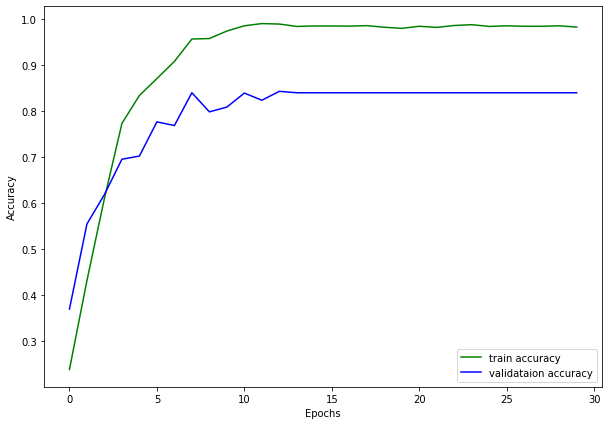

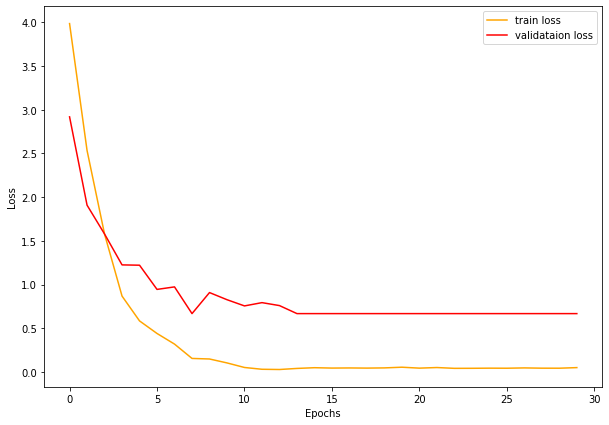

100%|██████████| 362/362 [00:55<00:00,  6.57it/s]

Test Accuracy: 0.8354649153128241


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 8     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 10


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=preprocess)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net, input_size = initialize_model("vgg16",4096,NUM_CLASSES,use_pretrained=True)

print(net)

parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="alexnet_transfer_learning")
print_acc_loss(tl,ta,vl,va,"alexnet_transfer_learning")
test(net,test_dataloader)


Further personal experiments, such as more epochs, dataset augmented.

Starting epoch 1/50, LR = [0.01]
Step 0, Loss 5.029275417327881
Step 10, Loss 2.1273245811462402


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]



Train Loss: 3.1346, Train Acc: 0.33
Val Loss: 1.7548, Val Acc: 0.59


Starting epoch 2/50, LR = [0.01]
Step 20, Loss 0.8961613178253174


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]



Train Loss: 1.1529, Train Acc: 0.69
Val Loss: 0.9154, Val Acc: 0.77


Starting epoch 3/50, LR = [0.01]
Step 30, Loss 0.5251633524894714


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]



Train Loss: 0.4534, Train Acc: 0.85
Val Loss: 0.8025, Val Acc: 0.79


Starting epoch 4/50, LR = [0.01]
Step 40, Loss 0.22534245252609253


100%|██████████| 12/12 [00:06<00:00,  1.73it/s]



Train Loss: 0.2429, Train Acc: 0.90
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 5/50, LR = [0.01]
Step 50, Loss 0.07611480355262756


100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Train Loss: 0.1205, Train Acc: 0.94
Val Loss: 0.7497, Val Acc: 0.83


Starting epoch 6/50, LR = [0.01]


Step 60, Loss 0.03900764882564545


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Train Loss: 0.0616, Train Acc: 0.96
Val Loss: 0.8181, Val Acc: 0.82


Starting epoch 7/50, LR = [0.01]


Step 70, Loss 0.026889028027653694


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Train Loss: 0.0495, Train Acc: 0.96
Val Loss: 0.8623, Val Acc: 0.82


Starting epoch 8/50, LR = [0.01]


Step 80, Loss 0.03333211690187454


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Train Loss: 0.0390, Train Acc: 0.96
Val Loss: 0.7781, Val Acc: 0.83


Starting epoch 9/50, LR = [0.01]


Step 90, Loss 0.024168096482753754


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Train Loss: 0.0382, Train Acc: 0.96
Val Loss: 0.8050, Val Acc: 0.83


Early stopping!
Starting epoch 10/50, LR = [0.01]


Step 100, Loss 0.12771624326705933


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Train Loss: 0.1365, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 11/50, LR = [0.01]


Step 110, Loss 0.1385234147310257
Step 120, Loss 0.10854560881853104


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Train Loss: 0.1441, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 12/50, LR = [0.01]


Step 130, Loss 0.18014852702617645


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Train Loss: 0.1424, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 13/50, LR = [0.01]


Step 140, Loss 0.1499328315258026


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Train Loss: 0.1455, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 14/50, LR = [0.01]


Step 150, Loss 0.1012912467122078


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Train Loss: 0.1376, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 15/50, LR = [0.01]


Step 160, Loss 0.10873549431562424


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Train Loss: 0.1427, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 16/50, LR = [0.001]


Step 170, Loss 0.0860353633761406


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Train Loss: 0.1391, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 17/50, LR = [0.001]


Step 180, Loss 0.15252751111984253


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1444, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 18/50, LR = [0.001]


Step 190, Loss 0.142836332321167


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1416, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 19/50, LR = [0.001]


Step 200, Loss 0.13262677192687988


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Train Loss: 0.1323, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 20/50, LR = [0.001]


Step 210, Loss 0.13313788175582886


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Train Loss: 0.1426, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 21/50, LR = [0.001]


Step 220, Loss 0.118415467441082
Step 230, Loss 0.14355286955833435


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1426, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 22/50, LR = [0.001]


Step 240, Loss 0.14611175656318665


100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Train Loss: 0.1447, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 23/50, LR = [0.001]


Step 250, Loss 0.10462869703769684


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1390, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 24/50, LR = [0.001]


Step 260, Loss 0.1388854831457138


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Train Loss: 0.1365, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 25/50, LR = [0.001]


Step 270, Loss 0.16180068254470825


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Train Loss: 0.1383, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 26/50, LR = [0.001]


Step 280, Loss 0.1462685614824295


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Train Loss: 0.1394, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 27/50, LR = [0.001]


Step 290, Loss 0.1820547729730606


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Train Loss: 0.1425, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 28/50, LR = [0.001]


Step 300, Loss 0.1466110348701477


100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Train Loss: 0.1419, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 29/50, LR = [0.001]


Step 310, Loss 0.09946797788143158


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Train Loss: 0.1353, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 30/50, LR = [0.001]


Step 320, Loss 0.1539974957704544


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Train Loss: 0.1382, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 31/50, LR = [0.0001]


Step 330, Loss 0.12568078935146332
Step 340, Loss 0.10775920003652573


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Train Loss: 0.1434, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 32/50, LR = [0.0001]


Step 350, Loss 0.14582255482673645


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Train Loss: 0.1425, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 33/50, LR = [0.0001]


Step 360, Loss 0.18929842114448547


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Train Loss: 0.1430, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 34/50, LR = [0.0001]


Step 370, Loss 0.09853598475456238


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Train Loss: 0.1436, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 35/50, LR = [0.0001]


Step 380, Loss 0.09663558751344681


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1449, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 36/50, LR = [0.0001]


Step 390, Loss 0.14693184196949005


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Train Loss: 0.1381, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 37/50, LR = [0.0001]


Step 400, Loss 0.1631450653076172


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1381, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 38/50, LR = [0.0001]


Step 410, Loss 0.09283393621444702


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1394, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 39/50, LR = [0.0001]


Step 420, Loss 0.13781026005744934


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1377, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 40/50, LR = [0.0001]


Step 430, Loss 0.14101791381835938


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1386, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 41/50, LR = [0.0001]


Step 440, Loss 0.2057960331439972
Step 450, Loss 0.1045592725276947


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Train Loss: 0.1443, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 42/50, LR = [0.0001]


Step 460, Loss 0.1687134951353073


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Train Loss: 0.1379, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 43/50, LR = [0.0001]


Step 470, Loss 0.10631391406059265


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1349, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 44/50, LR = [0.0001]


Step 480, Loss 0.1499016433954239


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Train Loss: 0.1414, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 45/50, LR = [0.0001]


Step 490, Loss 0.14292919635772705


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Train Loss: 0.1324, Train Acc: 0.94
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 46/50, LR = [1e-05]


Step 500, Loss 0.12339791655540466


100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Train Loss: 0.1356, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 47/50, LR = [1e-05]


Step 510, Loss 0.13337412476539612


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Train Loss: 0.1438, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 48/50, LR = [1e-05]


Step 520, Loss 0.17987707257270813


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1468, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 49/50, LR = [1e-05]


Step 530, Loss 0.12098748981952667


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Train Loss: 0.1404, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


Starting epoch 50/50, LR = [1e-05]


Step 540, Loss 0.17216147482395172


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]



Train Loss: 0.1383, Train Acc: 0.93
Val Loss: 0.7468, Val Acc: 0.82


[(3.1345961310646753, 0.32710926694329184), (1.1528959436850115, 0.6926002766251729), (0.45344390923326666, 0.8475103734439834), (0.2429244491187009, 0.9042185338865837), (0.12049739536913959, 0.9387966804979253), (0.06158651394600218, 0.9557399723374828), (0.04952889054336331, 0.9581604426002767), (0.038982717489654366, 0.9619640387275242), (0.0381810184229504, 0.9619640387275242), (0.13650460812178525, 0.9377593360995851), (0.14412528140978378, 0.9332641770401107), (0.1423561153086749, 0.9325726141078838), (0.14549164406277917, 0.9356846473029046), (0.13760871304707092, 0.9346473029045643), (0.14269389686259357, 0.926002766251729), (0.13905790854584088, 0.9346473029045643), (0.14435860108245502, 0.9343015214384509), (0.14162719317457892, 0.9329183955739973), (0.13229424438693307, 0.9381051175656985), (0.14264661412347446, 0.9311894882434302), (0.14262782511386005, 0.931881051175657), (0.1446944299069318, 0.9332641

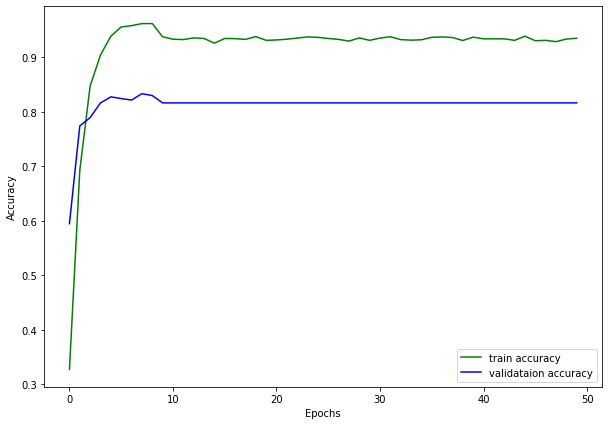

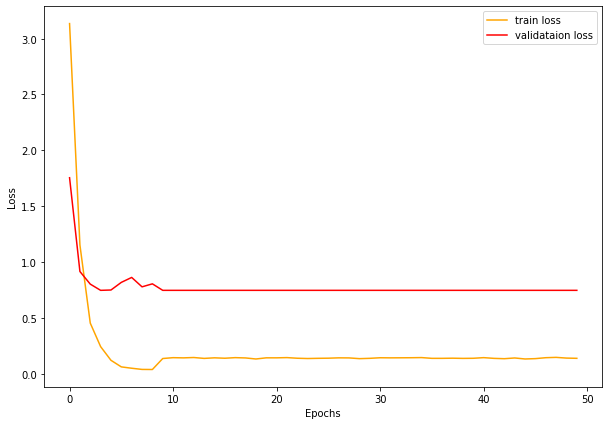

100%|██████████| 12/12 [00:06<00:00,  1.79it/s]

Test Accuracy: 0.8123055651572761


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 10
#default alexnet transformation on ImageNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=preprocess)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net = alexnet(pretrained = True) # Loading AlexNet model


net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="alexnet_transfer_learning")
print_acc_loss(tl,ta,vl,va,"alexnet_transfer_learning")
test(net,test_dataloader)

*Transfer learning + FC-layers freeze*

In [ ]:
NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 10

net = alexnet(pretrained = True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

net.classifier = nn.Sequential(
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=9216, out_features=4096, bias=True),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=4096, out_features=4096, bias=True),
  nn.ReLU(inplace=True),
  nn.Linear(in_features=4096, out_features=NUM_CLASSES, bias=True)
)

total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="./alexnet pretrained")
print_acc_loss(tl,ta,vl,va,"alexnet pretrained")
test(net,test_dataloader)

57,417,637 total parameters.
54,947,941 training parameters.
Starting epoch 1/50, LR = [0.01]
Step 0, Loss 4.691134452819824
Step 10, Loss 3.4295296669006348


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]



Train Loss: 4.0543, Train Acc: 0.18
Val Loss: 3.3142, Val Acc: 0.32


Starting epoch 2/50, LR = [0.01]
Step 20, Loss 2.788300037384033


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]



Train Loss: 2.9451, Train Acc: 0.36
Val Loss: 2.6105, Val Acc: 0.48


Starting epoch 3/50, LR = [0.01]
Step 30, Loss 1.987829566001892


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]



Train Loss: 2.1599, Train Acc: 0.56
Val Loss: 1.7926, Val Acc: 0.64


Starting epoch 4/50, LR = [0.01]
Step 40, Loss 1.29094398021698


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 1.3713, Train Acc: 0.68
Val Loss: 1.2142, Val Acc: 0.73


Starting epoch 5/50, LR = [0.01]
Step 50, Loss 0.9608995914459229


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]



Train Loss: 0.9055, Train Acc: 0.77
Val Loss: 0.9697, Val Acc: 0.75


Starting epoch 6/50, LR = [0.01]
Step 60, Loss 0.6582255363464355


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]



Train Loss: 0.5859, Train Acc: 0.84
Val Loss: 0.7773, Val Acc: 0.80


Starting epoch 7/50, LR = [0.01]
Step 70, Loss 0.3834505081176758


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Train Loss: 0.3532, Train Acc: 0.90
Val Loss: 0.7845, Val Acc: 0.81


Starting epoch 8/50, LR = [0.01]


Step 80, Loss 0.22133305668830872


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 0.2637, Train Acc: 0.92
Val Loss: 0.6864, Val Acc: 0.82


Starting epoch 9/50, LR = [0.01]
Step 90, Loss 0.22929617762565613


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 0.1683, Train Acc: 0.94
Val Loss: 0.6258, Val Acc: 0.83


Starting epoch 10/50, LR = [0.01]
Step 100, Loss 0.11756999790668488


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 0.1181, Train Acc: 0.95
Val Loss: 0.6050, Val Acc: 0.84


Starting epoch 11/50, LR = [0.01]
Step 110, Loss 0.09343954920768738
Step 120, Loss 0.06892837584018707


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 0.0996, Train Acc: 0.96
Val Loss: 0.5893, Val Acc: 0.85


Starting epoch 12/50, LR = [0.01]
Step 130, Loss 0.0922856330871582


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]



Train Loss: 0.0848, Train Acc: 0.96
Val Loss: 0.5689, Val Acc: 0.85


Starting epoch 13/50, LR = [0.01]
Step 140, Loss 0.06592711061239243


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Train Loss: 0.0633, Train Acc: 0.96
Val Loss: 0.5699, Val Acc: 0.85


Starting epoch 14/50, LR = [0.01]


Step 150, Loss 0.034290559589862823


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]



Train Loss: 0.0468, Train Acc: 0.97
Val Loss: 0.5396, Val Acc: 0.86


Starting epoch 15/50, LR = [0.01]
Step 160, Loss 0.06614716351032257


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Train Loss: 0.0428, Train Acc: 0.97
Val Loss: 0.5750, Val Acc: 0.85


Starting epoch 16/50, LR = [0.001]


Step 170, Loss 0.023638155311346054


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Train Loss: 0.0378, Train Acc: 0.97
Val Loss: 0.5553, Val Acc: 0.86


Starting epoch 17/50, LR = [0.001]


Step 180, Loss 0.06331925094127655


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Train Loss: 0.0299, Train Acc: 0.97
Val Loss: 0.5455, Val Acc: 0.86


Starting epoch 18/50, LR = [0.001]


Step 190, Loss 0.022839076817035675


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 0.0231, Train Acc: 0.97
Val Loss: 0.5335, Val Acc: 0.87


Starting epoch 19/50, LR = [0.001]
Step 200, Loss 0.022708149626851082


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 0.0256, Train Acc: 0.97
Val Loss: 0.5223, Val Acc: 0.87


Starting epoch 20/50, LR = [0.001]
Step 210, Loss 0.02014707401394844


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0227, Train Acc: 0.97
Val Loss: 0.5254, Val Acc: 0.87


Starting epoch 21/50, LR = [0.001]


Step 220, Loss 0.029102198779582977
Step 230, Loss 0.029501385986804962


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Train Loss: 0.0220, Train Acc: 0.97
Val Loss: 0.5302, Val Acc: 0.86


Starting epoch 22/50, LR = [0.001]


Step 240, Loss 0.02281189151108265


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Train Loss: 0.0222, Train Acc: 0.97
Val Loss: 0.5271, Val Acc: 0.86


Starting epoch 23/50, LR = [0.001]


Step 250, Loss 0.022645199671387672


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 0.0214, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 24/50, LR = [0.001]
Step 260, Loss 0.021178768947720528


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Train Loss: 0.0195, Train Acc: 0.97
Val Loss: 0.5213, Val Acc: 0.86


Starting epoch 25/50, LR = [0.001]


Step 270, Loss 0.018245074898004532


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 0.0198, Train Acc: 0.97
Val Loss: 0.5220, Val Acc: 0.86


Starting epoch 26/50, LR = [0.001]


Step 280, Loss 0.03684776648879051


100%|██████████| 12/12 [00:06<00:00,  1.90it/s]


Train Loss: 0.0263, Train Acc: 0.97
Val Loss: 0.5207, Val Acc: 0.86


Starting epoch 27/50, LR = [0.001]


Step 290, Loss 0.024334624409675598


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 0.0219, Train Acc: 0.97
Val Loss: 0.5220, Val Acc: 0.86


Starting epoch 28/50, LR = [0.001]


Step 300, Loss 0.01914224401116371


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]



Train Loss: 0.0173, Train Acc: 0.97
Val Loss: 0.5211, Val Acc: 0.86


Early stopping!
Starting epoch 29/50, LR = [0.001]
Step 310, Loss 0.04119006544351578


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 0.0226, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 30/50, LR = [0.001]


Step 320, Loss 0.017809906974434853


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Train Loss: 0.0223, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 31/50, LR = [0.0001]


Step 330, Loss 0.0200662761926651
Step 340, Loss 0.022188173606991768


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0204, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 32/50, LR = [0.0001]


Step 350, Loss 0.03275925666093826


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 0.0243, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 33/50, LR = [0.0001]


Step 360, Loss 0.017996473237872124


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 0.0194, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 34/50, LR = [0.0001]


Step 370, Loss 0.029397495090961456


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0242, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 35/50, LR = [0.0001]


Step 380, Loss 0.013087352737784386


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Train Loss: 0.0217, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 36/50, LR = [0.0001]


Step 390, Loss 0.02844073250889778


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Train Loss: 0.0229, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 37/50, LR = [0.0001]


Step 400, Loss 0.01852782443165779


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0238, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 38/50, LR = [0.0001]


Step 410, Loss 0.01196357049047947


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 0.0216, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 39/50, LR = [0.0001]


Step 420, Loss 0.019843146204948425


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0219, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 40/50, LR = [0.0001]


Step 430, Loss 0.013642435893416405


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0205, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 41/50, LR = [0.0001]


Step 440, Loss 0.021006207913160324
Step 450, Loss 0.02362356334924698


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0231, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 42/50, LR = [0.0001]


Step 460, Loss 0.023141473531723022


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 0.0230, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 43/50, LR = [0.0001]


Step 470, Loss 0.02022279053926468


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Train Loss: 0.0237, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 44/50, LR = [0.0001]


Step 480, Loss 0.0344184935092926


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0244, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 45/50, LR = [0.0001]


Step 490, Loss 0.028969498351216316


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Train Loss: 0.0226, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 46/50, LR = [1e-05]


Step 500, Loss 0.020336272194981575


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Train Loss: 0.0235, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 47/50, LR = [1e-05]


Step 510, Loss 0.017209608107805252


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 0.0228, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 48/50, LR = [1e-05]


Step 520, Loss 0.015630435198545456


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 0.0226, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 49/50, LR = [1e-05]


Step 530, Loss 0.03453023359179497


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Train Loss: 0.0206, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


Starting epoch 50/50, LR = [1e-05]


Step 540, Loss 0.020420590415596962


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 0.0218, Train Acc: 0.97
Val Loss: 0.5196, Val Acc: 0.86


[(4.054337003014305, 0.18153526970954356), (2.945144219831987, 0.3578838174273859), (2.159916650165211, 0.5636237897648686), (1.371344728903337, 0.6839557399723375), (0.9054987105456266, 0.7745504840940526), (0.5858865109356967, 0.8378284923928078), (0.3531670570373535, 0.896957123098202), (0.2636945450847799, 0.9180497925311203), (0.16827588054266843, 0.9398340248962656), (0.1181424544616179, 0.9529737206085753), (0.09957138110290874, 0.9585062240663901), (0.08475402200763876, 0.9595435684647303), (0.06330011988228018, 0.9633471645919779), (0.04676123556088318, 0.966804979253112), (0.042836467481472275, 0.966804979253112), (0.037816526876254516, 0.9657676348547718), (0.029949363151734524, 0.9706085753803596), (0.02310987680473111, 0.9716459197786999), (0.025594682009382683, 0.9716459197786999), (0.02271958084946329, 0.9723374827109267), (0.022039400921626526, 0.9723374827109267), (0.02221584963527593, 0.97164591977

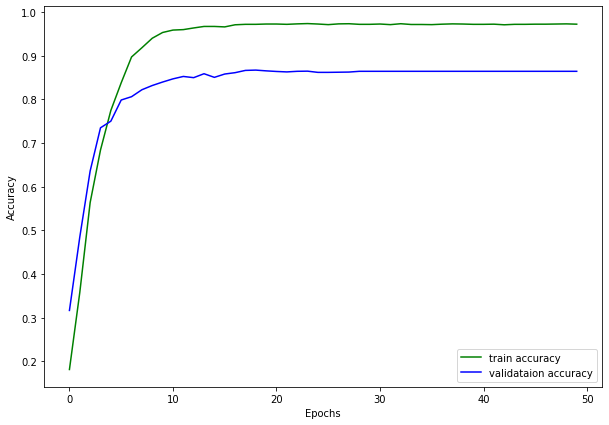

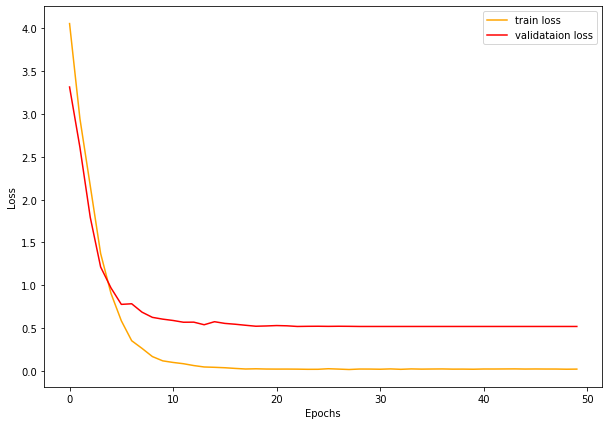

100%|██████████| 12/12 [00:06<00:00,  1.86it/s]

Test Accuracy: 0.8655375043207743


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 10
#default alexnet transformation on ImageNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=preprocess)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net = alexnet(pretrained = True) # Loading AlexNet model

# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

net.classifier = nn.Sequential(
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=9216, out_features=4096, bias=True),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=4096, out_features=4096, bias=True),
  nn.ReLU(inplace=True),
  nn.Linear(in_features=4096, out_features=NUM_CLASSES, bias=True)
)

total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

criterion = nn.CrossEntropyLoss() 
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="alexnet_tl_fc_freeze")
print_acc_loss(tl,ta,vl,va,"alexnet_tl_fc_freeze")
test(net,test_dataloader)

*Transfer learning + Conv-layers freeze*

57,417,637 total parameters.
2,469,696 training parameters.
Starting epoch 1/50, LR = [0.01]
Step 0, Loss 4.618309497833252
Step 10, Loss 4.594954013824463


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]



Train Loss: 4.6077, Train Acc: 0.02
Val Loss: 4.5950, Val Acc: 0.09


Starting epoch 2/50, LR = [0.01]
Step 20, Loss 4.536412239074707


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]



Train Loss: 4.5682, Train Acc: 0.09
Val Loss: 4.5084, Val Acc: 0.09


Starting epoch 3/50, LR = [0.01]
Step 30, Loss 4.428422451019287


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]



Train Loss: 4.4365, Train Acc: 0.09
Val Loss: 4.3782, Val Acc: 0.09


Starting epoch 4/50, LR = [0.01]
Step 40, Loss 4.384263515472412


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]



Train Loss: 4.3584, Train Acc: 0.09
Val Loss: 4.3269, Val Acc: 0.10


Starting epoch 5/50, LR = [0.01]
Step 50, Loss 4.364707946777344


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]



Train Loss: 4.3388, Train Acc: 0.09
Val Loss: 4.2986, Val Acc: 0.09


Starting epoch 6/50, LR = [0.01]
Step 60, Loss 4.288601875305176


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]



Train Loss: 4.3113, Train Acc: 0.10
Val Loss: 4.2726, Val Acc: 0.10


Starting epoch 7/50, LR = [0.01]
Step 70, Loss 4.282732009887695


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 4.2930, Train Acc: 0.09
Val Loss: 4.2542, Val Acc: 0.10


Starting epoch 8/50, LR = [0.01]
Step 80, Loss 4.3242411613464355


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]



Train Loss: 4.2423, Train Acc: 0.10
Val Loss: 4.2156, Val Acc: 0.12


Starting epoch 9/50, LR = [0.01]
Step 90, Loss 4.217874526977539


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]



Train Loss: 4.2087, Train Acc: 0.12
Val Loss: 4.1788, Val Acc: 0.17


Starting epoch 10/50, LR = [0.01]
Step 100, Loss 4.078721523284912


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]



Train Loss: 4.1668, Train Acc: 0.13
Val Loss: 4.1014, Val Acc: 0.16


Starting epoch 11/50, LR = [0.01]
Step 110, Loss 4.082610607147217
Step 120, Loss 4.132526874542236


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]



Train Loss: 4.0980, Train Acc: 0.16
Val Loss: 4.0503, Val Acc: 0.19


Starting epoch 12/50, LR = [0.01]
Step 130, Loss 4.012463569641113


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]



Train Loss: 4.0342, Train Acc: 0.18
Val Loss: 3.9609, Val Acc: 0.21


Starting epoch 13/50, LR = [0.01]
Step 140, Loss 3.966801166534424


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]



Train Loss: 3.9292, Train Acc: 0.20
Val Loss: 3.8769, Val Acc: 0.22


Starting epoch 14/50, LR = [0.01]
Step 150, Loss 4.051911354064941


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]



Train Loss: 3.9415, Train Acc: 0.19
Val Loss: 3.8402, Val Acc: 0.24


Starting epoch 15/50, LR = [0.01]
Step 160, Loss 3.981358528137207


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.8111, Train Acc: 0.22
Val Loss: 3.7649, Val Acc: 0.25


Starting epoch 16/50, LR = [0.001]
Step 170, Loss 3.742236614227295


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.7614, Train Acc: 0.22
Val Loss: 3.7386, Val Acc: 0.24


Starting epoch 17/50, LR = [0.001]
Step 180, Loss 3.4655303955078125


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]



Train Loss: 3.7608, Train Acc: 0.22
Val Loss: 3.7212, Val Acc: 0.24


Starting epoch 18/50, LR = [0.001]
Step 190, Loss 3.708822727203369


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]



Train Loss: 3.7175, Train Acc: 0.22
Val Loss: 3.7101, Val Acc: 0.24


Starting epoch 19/50, LR = [0.001]
Step 200, Loss 3.8050100803375244


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.7221, Train Acc: 0.23
Val Loss: 3.6998, Val Acc: 0.24


Starting epoch 20/50, LR = [0.001]
Step 210, Loss 3.803434371948242


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 3.7084, Train Acc: 0.23
Val Loss: 3.6913, Val Acc: 0.24


Starting epoch 21/50, LR = [0.001]
Step 220, Loss 3.5088794231414795
Step 230, Loss 3.8493425846099854


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]



Train Loss: 3.6960, Train Acc: 0.23
Val Loss: 3.6811, Val Acc: 0.25


Starting epoch 22/50, LR = [0.001]
Step 240, Loss 3.689948558807373


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 3.6757, Train Acc: 0.23
Val Loss: 3.6735, Val Acc: 0.25


Starting epoch 23/50, LR = [0.001]
Step 250, Loss 3.7113521099090576


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]



Train Loss: 3.7028, Train Acc: 0.23
Val Loss: 3.6650, Val Acc: 0.25


Starting epoch 24/50, LR = [0.001]
Step 260, Loss 3.7326252460479736


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]



Train Loss: 3.6749, Train Acc: 0.23
Val Loss: 3.6518, Val Acc: 0.25


Starting epoch 25/50, LR = [0.001]
Step 270, Loss 3.9232277870178223


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.6694, Train Acc: 0.23
Val Loss: 3.6470, Val Acc: 0.25


Starting epoch 26/50, LR = [0.001]
Step 280, Loss 3.6649138927459717


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.6602, Train Acc: 0.23
Val Loss: 3.6437, Val Acc: 0.26


Starting epoch 27/50, LR = [0.001]
Step 290, Loss 3.692732334136963


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]



Train Loss: 3.6592, Train Acc: 0.23
Val Loss: 3.6308, Val Acc: 0.26


Starting epoch 28/50, LR = [0.001]
Step 300, Loss 3.3879051208496094


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 3.6441, Train Acc: 0.23
Val Loss: 3.6255, Val Acc: 0.26


Starting epoch 29/50, LR = [0.001]
Step 310, Loss 3.6354620456695557


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Train Loss: 3.6439, Train Acc: 0.24
Val Loss: 3.6309, Val Acc: 0.27


Starting epoch 30/50, LR = [0.001]


Step 320, Loss 3.580803871154785


100%|██████████| 12/12 [00:06<00:00,  1.91it/s]



Train Loss: 3.6408, Train Acc: 0.24
Val Loss: 3.6155, Val Acc: 0.27


Starting epoch 31/50, LR = [0.0001]
Step 330, Loss 3.6784415245056152
Step 340, Loss 3.6820738315582275


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]



Train Loss: 3.6146, Train Acc: 0.24
Val Loss: 3.6128, Val Acc: 0.26


Starting epoch 32/50, LR = [0.0001]
Step 350, Loss 3.384129047393799


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]



Train Loss: 3.6271, Train Acc: 0.24
Val Loss: 3.6116, Val Acc: 0.26


Starting epoch 33/50, LR = [0.0001]
Step 360, Loss 3.5632288455963135


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.6137, Train Acc: 0.24
Val Loss: 3.6085, Val Acc: 0.26


Starting epoch 34/50, LR = [0.0001]
Step 370, Loss 3.4719972610473633


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.6236, Train Acc: 0.24
Val Loss: 3.6080, Val Acc: 0.26


Starting epoch 35/50, LR = [0.0001]
Step 380, Loss 3.6205575466156006


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 3.6147, Train Acc: 0.24
Val Loss: 3.6079, Val Acc: 0.26


Starting epoch 36/50, LR = [0.0001]
Step 390, Loss 3.598310708999634


100%|██████████| 12/12 [00:06<00:00,  1.92it/s]



Train Loss: 3.6225, Train Acc: 0.24
Val Loss: 3.6069, Val Acc: 0.26


Starting epoch 37/50, LR = [0.0001]
Step 400, Loss 3.677123546600342


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.6139, Train Acc: 0.24
Val Loss: 3.6058, Val Acc: 0.26


Starting epoch 38/50, LR = [0.0001]
Step 410, Loss 3.739222526550293


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]



Train Loss: 3.6232, Train Acc: 0.24
Val Loss: 3.6042, Val Acc: 0.26


Starting epoch 39/50, LR = [0.0001]
Step 420, Loss 3.6598336696624756


100%|██████████| 12/12 [00:06<00:00,  1.90it/s]


Train Loss: 3.6154, Train Acc: 0.24
Val Loss: 3.6050, Val Acc: 0.26


Starting epoch 40/50, LR = [0.0001]


Step 430, Loss 3.660348415374756


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.6380, Train Acc: 0.24
Val Loss: 3.6034, Val Acc: 0.26


Starting epoch 41/50, LR = [0.0001]
Step 440, Loss 3.3911232948303223
Step 450, Loss 3.6830332279205322


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]



Train Loss: 3.6144, Train Acc: 0.24
Val Loss: 3.6022, Val Acc: 0.26


Starting epoch 42/50, LR = [0.0001]
Step 460, Loss 3.538667678833008


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 3.6176, Train Acc: 0.24
Val Loss: 3.6027, Val Acc: 0.27


Starting epoch 43/50, LR = [0.0001]


Step 470, Loss 3.3907456398010254


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]



Train Loss: 3.6013, Train Acc: 0.25
Val Loss: 3.6013, Val Acc: 0.27


Starting epoch 44/50, LR = [0.0001]
Step 480, Loss 3.5788183212280273


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]



Train Loss: 3.6032, Train Acc: 0.24
Val Loss: 3.6005, Val Acc: 0.26


Starting epoch 45/50, LR = [0.0001]
Step 490, Loss 3.6330182552337646


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]



Train Loss: 3.6147, Train Acc: 0.25
Val Loss: 3.5989, Val Acc: 0.26


Starting epoch 46/50, LR = [1e-05]
Step 500, Loss 3.6137888431549072


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]



Train Loss: 3.6005, Train Acc: 0.25
Val Loss: 3.5988, Val Acc: 0.26


Starting epoch 47/50, LR = [1e-05]
Step 510, Loss 3.5490052700042725


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]



Train Loss: 3.6067, Train Acc: 0.24
Val Loss: 3.5987, Val Acc: 0.26


Starting epoch 48/50, LR = [1e-05]
Step 520, Loss 3.6358816623687744


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Train Loss: 3.6065, Train Acc: 0.24
Val Loss: 3.5987, Val Acc: 0.27


Starting epoch 49/50, LR = [1e-05]


Step 530, Loss 3.6471996307373047


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Train Loss: 3.6086, Train Acc: 0.24
Val Loss: 3.5988, Val Acc: 0.26


Starting epoch 50/50, LR = [1e-05]


Step 540, Loss 3.637737512588501


100%|██████████| 12/12 [00:06<00:00,  1.90it/s]



Train Loss: 3.6044, Train Acc: 0.25
Val Loss: 3.5986, Val Acc: 0.26


[(4.607695796272972, 0.02455048409405256), (4.568209518085826, 0.09024896265560166), (4.436452215368098, 0.09405255878284924), (4.358383698896929, 0.08955739972337483), (4.338832508433949, 0.09301521438450899), (4.311318267475475, 0.09820193637621023), (4.29304127259688, 0.09024896265560166), (4.242277492176402, 0.10477178423236515), (4.208666758103804, 0.11549100968188106), (4.166827115145597, 0.13485477178423236), (4.0979791121049365, 0.15560165975103735), (4.034191543405706, 0.177731673582296), (3.9291684194044634, 0.19605809128630705), (3.9415231184525923, 0.19052558782849238), (3.811073129827326, 0.21645919778699863), (3.761350566690618, 0.22372060857538037), (3.760756167498502, 0.21991701244813278), (3.717546593059193, 0.22475795297372061), (3.722128239544955, 0.229253112033195), (3.708449537103826, 0.22821576763485477), (3.6960390264337715, 0.23236514522821577), (3.67570744861256, 0.22752420470262794), (3.702

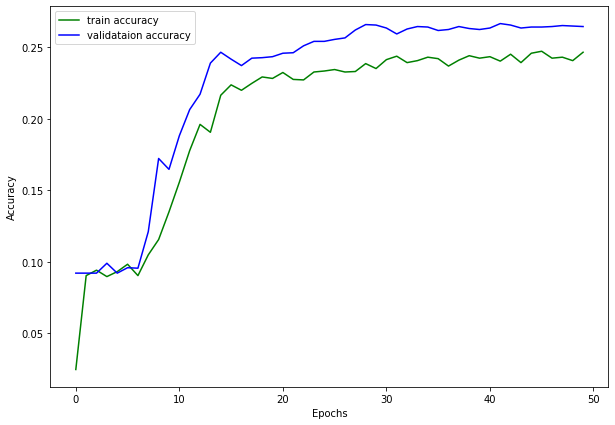

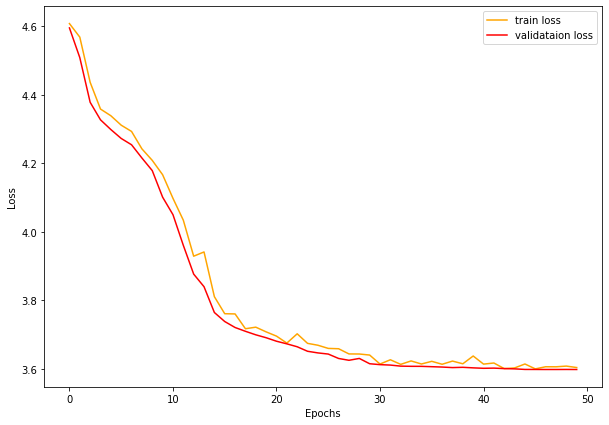

100%|██████████| 12/12 [00:06<00:00,  1.85it/s]

Test Accuracy: 0.26132042862080884


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 10
#default alexnet transformation on ImageNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=preprocess)
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net = alexnet(pretrained = True) # Loading AlexNet model

net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

# Unfreeze conv layer weigths
net.features = nn.Sequential(
  nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
  nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
  nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  nn.ReLU(inplace=True),
  nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  nn.ReLU(inplace=True),
  nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


criterion = nn.CrossEntropyLoss() 
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="alexnet_tl_conv_freeze")
print_acc_loss(tl,ta,vl,va,"alexnet_tl_conv_freeze")
test(net,test_dataloader)

*Transfer learning + data augmentation*

train dataset length:  5784
augmented train dataset length:  11568
Starting epoch 1/50, LR = [0.01]
Step 0, Loss 4.859961032867432
Step 10, Loss 2.099574089050293
Step 20, Loss 1.0995270013809204


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]



Train Loss: 2.2677, Train Acc: 0.48
Val Loss: 0.8840, Val Acc: 0.76


Starting epoch 2/50, LR = [0.01]
Step 30, Loss 0.5797832012176514
Step 40, Loss 0.4651665687561035


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]



Train Loss: 0.5047, Train Acc: 0.84
Val Loss: 0.5403, Val Acc: 0.85


Starting epoch 3/50, LR = [0.01]
Step 50, Loss 0.2235400676727295
Step 60, Loss 0.15137851238250732


100%|██████████| 23/23 [00:11<00:00,  1.98it/s]



Train Loss: 0.2390, Train Acc: 0.90
Val Loss: 0.4839, Val Acc: 0.87


Starting epoch 4/50, LR = [0.01]
Step 70, Loss 0.11454331129789352
Step 80, Loss 0.20739014446735382


100%|██████████| 23/23 [00:11<00:00,  1.97it/s]


Train Loss: 0.1330, Train Acc: 0.93
Val Loss: 0.4939, Val Acc: 0.88


Starting epoch 5/50, LR = [0.01]


Step 90, Loss 0.10641737282276154
Step 100, Loss 0.0510098934173584


100%|██████████| 23/23 [00:11<00:00,  1.95it/s]



Train Loss: 0.1097, Train Acc: 0.94
Val Loss: 0.4747, Val Acc: 0.89


Starting epoch 6/50, LR = [0.01]
Step 110, Loss 0.06042127311229706
Step 120, Loss 0.0763285905122757
Step 130, Loss 0.07206327468156815


100%|██████████| 23/23 [00:11<00:00,  1.96it/s]



Train Loss: 0.0606, Train Acc: 0.95
Val Loss: 0.4562, Val Acc: 0.90


Starting epoch 7/50, LR = [0.01]
Step 140, Loss 0.13291549682617188
Step 150, Loss 0.04616972431540489


100%|██████████| 23/23 [00:11<00:00,  1.94it/s]



Train Loss: 0.0622, Train Acc: 0.96
Val Loss: 0.4544, Val Acc: 0.89


Starting epoch 8/50, LR = [0.01]
Step 160, Loss 0.05213531479239464
Step 170, Loss 0.04117077216506004


100%|██████████| 23/23 [00:11<00:00,  1.94it/s]


Train Loss: 0.0388, Train Acc: 0.96
Val Loss: 0.4662, Val Acc: 0.90


Starting epoch 9/50, LR = [0.01]


Step 180, Loss 0.01677185855805874
Step 190, Loss 0.04865112900733948


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]



Train Loss: 0.0298, Train Acc: 0.97
Val Loss: 0.4403, Val Acc: 0.90


Starting epoch 10/50, LR = [0.01]
Step 200, Loss 0.047407180070877075
Step 210, Loss 0.03235122188925743


100%|██████████| 23/23 [00:11<00:00,  1.95it/s]


Train Loss: 0.0217, Train Acc: 0.97
Val Loss: 0.4560, Val Acc: 0.90


Starting epoch 11/50, LR = [0.01]


Step 220, Loss 0.009345583617687225
Step 230, Loss 0.002558678388595581
Step 240, Loss 0.04396691918373108


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]


Train Loss: 0.0198, Train Acc: 0.97
Val Loss: 0.4675, Val Acc: 0.90


Starting epoch 12/50, LR = [0.01]


Step 250, Loss 0.02583812177181244
Step 260, Loss 0.012103457003831863


100%|██████████| 23/23 [00:11<00:00,  1.92it/s]


Train Loss: 0.0203, Train Acc: 0.97
Val Loss: 0.4583, Val Acc: 0.91


Starting epoch 13/50, LR = [0.01]


Step 270, Loss 0.01719239354133606
Step 280, Loss 0.024238519370555878


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]



Train Loss: 0.0177, Train Acc: 0.97
Val Loss: 0.4381, Val Acc: 0.91


Starting epoch 14/50, LR = [0.01]
Step 290, Loss 0.006996229290962219
Step 300, Loss 0.007217284291982651


100%|██████████| 23/23 [00:11<00:00,  1.95it/s]


Train Loss: 0.0126, Train Acc: 0.97
Val Loss: 0.4888, Val Acc: 0.90


Starting epoch 15/50, LR = [0.01]


Step 310, Loss 0.060615867376327515
Step 320, Loss 0.048555050045251846


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]


Train Loss: 0.0222, Train Acc: 0.97
Val Loss: 0.4520, Val Acc: 0.90


Starting epoch 16/50, LR = [0.001]


Step 330, Loss 0.00784195214509964
Step 340, Loss 0.011829491704702377
Step 350, Loss 0.006921436637639999


100%|██████████| 23/23 [00:11<00:00,  1.92it/s]



Train Loss: 0.0073, Train Acc: 0.97
Val Loss: 0.4278, Val Acc: 0.91


Starting epoch 17/50, LR = [0.001]
Step 360, Loss 0.007700938731431961
Step 370, Loss 0.003631874918937683


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]



Train Loss: 0.0055, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 18/50, LR = [0.001]
Step 380, Loss 0.0026330798864364624
Step 390, Loss 0.0021827034652233124


100%|██████████| 23/23 [00:11<00:00,  1.94it/s]


Train Loss: 0.0028, Train Acc: 0.97
Val Loss: 0.4151, Val Acc: 0.91


Starting epoch 19/50, LR = [0.001]


Step 400, Loss 0.0014786086976528168
Step 410, Loss 0.0012119077146053314


100%|██████████| 23/23 [00:11<00:00,  1.94it/s]


Train Loss: 0.0026, Train Acc: 0.97
Val Loss: 0.4167, Val Acc: 0.91


Starting epoch 20/50, LR = [0.001]


Step 420, Loss 0.0032822825014591217
Step 430, Loss 0.001386348158121109


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Train Loss: 0.0027, Train Acc: 0.97
Val Loss: 0.4146, Val Acc: 0.91


Starting epoch 21/50, LR = [0.001]


Step 440, Loss 0.0011442489922046661
Step 450, Loss 0.0013659782707691193
Step 460, Loss 0.0013170912861824036


100%|██████████| 23/23 [00:10<00:00,  2.13it/s]


Train Loss: 0.0015, Train Acc: 0.97
Val Loss: 0.4163, Val Acc: 0.91


Starting epoch 22/50, LR = [0.001]


Step 470, Loss 0.0007125921547412872
Step 480, Loss 0.0017714723944664001


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]



Train Loss: 0.0026, Train Acc: 0.97
Val Loss: 0.4190, Val Acc: 0.91


Early stopping!
Starting epoch 23/50, LR = [0.001]
Step 490, Loss 0.0014559552073478699
Step 500, Loss 0.004964541643857956


100%|██████████| 23/23 [00:10<00:00,  2.13it/s]


Train Loss: 0.0036, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 24/50, LR = [0.001]


Step 510, Loss 0.004582367837429047
Step 520, Loss 0.003126576542854309


100%|██████████| 23/23 [00:11<00:00,  1.96it/s]


Train Loss: 0.0046, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 25/50, LR = [0.001]


Step 530, Loss 0.004445057362318039
Step 540, Loss 0.001574300229549408


100%|██████████| 23/23 [00:11<00:00,  1.97it/s]


Train Loss: 0.0036, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 26/50, LR = [0.001]


Step 550, Loss 0.0030734091997146606
Step 560, Loss 0.0015953630208969116
Step 570, Loss 0.00269332155585289


100%|██████████| 23/23 [00:11<00:00,  1.97it/s]


Train Loss: 0.0035, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 27/50, LR = [0.001]


Step 580, Loss 0.0022921189665794373
Step 590, Loss 0.009251754730939865


100%|██████████| 23/23 [00:11<00:00,  2.02it/s]


Train Loss: 0.0040, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 28/50, LR = [0.001]


Step 600, Loss 0.003655899316072464
Step 610, Loss 0.0018440485000610352


100%|██████████| 23/23 [00:10<00:00,  2.10it/s]


Train Loss: 0.0050, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 29/50, LR = [0.001]


Step 620, Loss 0.0008455812931060791
Step 630, Loss 0.00790979340672493


100%|██████████| 23/23 [00:11<00:00,  2.09it/s]


Train Loss: 0.0045, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 30/50, LR = [0.001]


Step 640, Loss 0.0018051788210868835
Step 650, Loss 0.006404846906661987


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Train Loss: 0.0037, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 31/50, LR = [0.0001]


Step 660, Loss 0.0037777982652187347
Step 670, Loss 0.003934536129236221
Step 680, Loss 0.0037865936756134033


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Train Loss: 0.0036, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 32/50, LR = [0.0001]


Step 690, Loss 0.0027892813086509705
Step 700, Loss 0.0018242448568344116


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]


Train Loss: 0.0047, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 33/50, LR = [0.0001]


Step 710, Loss 0.002240873873233795
Step 720, Loss 0.004073023796081543


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Train Loss: 0.0041, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 34/50, LR = [0.0001]


Step 730, Loss 0.004480134695768356
Step 740, Loss 0.002935342490673065


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Train Loss: 0.0049, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 35/50, LR = [0.0001]


Step 750, Loss 0.00917293131351471
Step 760, Loss 0.0026889927685260773


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Train Loss: 0.0050, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 36/50, LR = [0.0001]


Step 770, Loss 0.001914825290441513
Step 780, Loss 0.0013931132853031158
Step 790, Loss 0.004480138421058655


100%|██████████| 23/23 [00:11<00:00,  2.09it/s]


Train Loss: 0.0033, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 37/50, LR = [0.0001]


Step 800, Loss 0.0036043748259544373
Step 810, Loss 0.002052348107099533


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Train Loss: 0.0041, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 38/50, LR = [0.0001]


Step 820, Loss 0.009016737341880798
Step 830, Loss 0.004590444266796112


100%|██████████| 23/23 [00:11<00:00,  2.07it/s]


Train Loss: 0.0042, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 39/50, LR = [0.0001]


Step 840, Loss 0.00931612029671669
Step 850, Loss 0.0006603337824344635


100%|██████████| 23/23 [00:11<00:00,  2.09it/s]


Train Loss: 0.0040, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 40/50, LR = [0.0001]


Step 860, Loss 0.002901017665863037
Step 870, Loss 0.0029877685010433197


100%|██████████| 23/23 [00:11<00:00,  2.09it/s]


Train Loss: 0.0042, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 41/50, LR = [0.0001]


Step 880, Loss 0.0009317733347415924
Step 890, Loss 0.0031527504324913025
Step 900, Loss 0.0012552440166473389


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Train Loss: 0.0035, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 42/50, LR = [0.0001]


Step 910, Loss 0.006405055522918701
Step 920, Loss 0.002696376293897629


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Train Loss: 0.0034, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 43/50, LR = [0.0001]


Step 930, Loss 0.002070430666208267
Step 940, Loss 0.0016778931021690369


100%|██████████| 23/23 [00:11<00:00,  2.09it/s]


Train Loss: 0.0044, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 44/50, LR = [0.0001]


Step 950, Loss 0.006108194589614868
Step 960, Loss 0.002222258597612381


100%|██████████| 23/23 [00:11<00:00,  2.07it/s]


Train Loss: 0.0039, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 45/50, LR = [0.0001]


Step 970, Loss 0.007838301360607147
Step 980, Loss 0.0032671205699443817


100%|██████████| 23/23 [00:10<00:00,  2.09it/s]


Train Loss: 0.0033, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 46/50, LR = [1e-05]


Step 990, Loss 0.0026198625564575195
Step 1000, Loss 0.0019269250333309174
Step 1010, Loss 0.004712190479040146


100%|██████████| 23/23 [00:10<00:00,  2.10it/s]


Train Loss: 0.0044, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 47/50, LR = [1e-05]


Step 1020, Loss 0.007706772536039352
Step 1030, Loss 0.00667969137430191


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Train Loss: 0.0050, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 48/50, LR = [1e-05]


Step 1040, Loss 0.0042135342955589294
Step 1050, Loss 0.004421740770339966


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Train Loss: 0.0039, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 49/50, LR = [1e-05]


Step 1060, Loss 0.004554092884063721
Step 1070, Loss 0.0029079020023345947


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Train Loss: 0.0044, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


Starting epoch 50/50, LR = [1e-05]


Step 1080, Loss 0.0024908334016799927
Step 1090, Loss 0.0017274804413318634


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]



Train Loss: 0.0032, Train Acc: 0.97
Val Loss: 0.4143, Val Acc: 0.91


[(2.2677486511794003, 0.4801175656984786), (0.5047054223038934, 0.8366182572614108), (0.23895056952129712, 0.904045643153527), (0.1329879252748056, 0.9334370677731674), (0.10969023982232268, 0.940179806362379), (0.06063677929341793, 0.9547026279391425), (0.0622458505359563, 0.9553941908713693), (0.03881480544805527, 0.9616182572614108), (0.029816355302252552, 0.9652489626556017), (0.02166453596543182, 0.9676694329183956), (0.019795352085070175, 0.9676694329183956), (0.020271442661231213, 0.9683609958506224), (0.017677945423532616, 0.9683609958506224), (0.012568922205404802, 0.9699170124481328), (0.022185054353692314, 0.9661134163208852), (0.007274998351931572, 0.9718188105117566), (0.005501588129184463, 0.9726832641770401), (0.0027647567066279325, 0.9735477178423236), (0.0025759782980788837, 0.9732019363762102), (0.002716238864443519, 0.9733748271092669), (0.0015484352003444326, 0.9737206085753803), (0.0025893305851

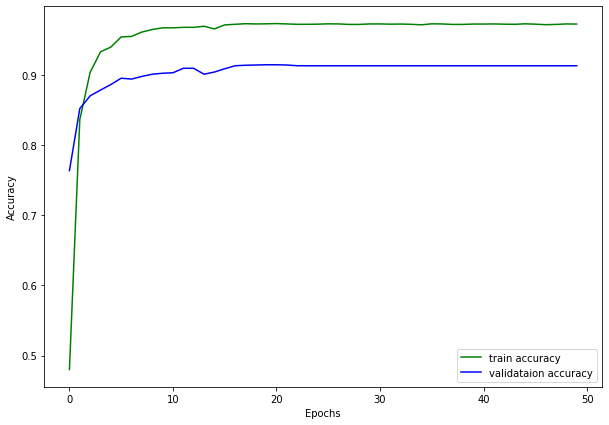

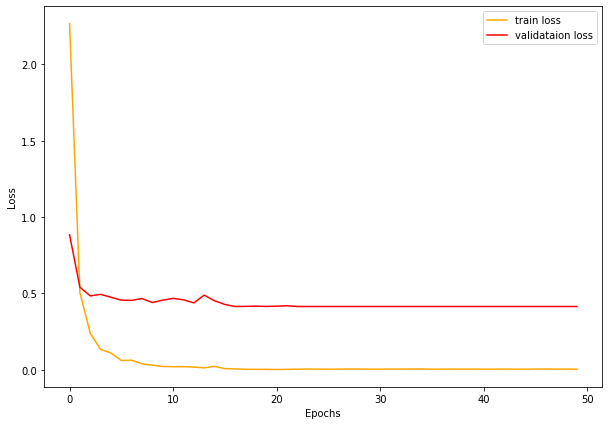

100%|██████████| 12/12 [00:09<00:00,  1.33it/s]

Test Accuracy: 0.8655375043207743


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 10
#default alexnet transformation on ImageNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

augment_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ColorJitter(hue=.05, saturation=.05),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20, resample=Image.BILINEAR),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                      
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])


DATA_DIR = 'Caltech101/101_ObjectCategories'

train_dataset = Caltech(DATA_DIR, split='train',  transform=preprocess)
print("train dataset length: ",len(train_dataset))
train_dataset.__augment__(augment_transform)
print("augmented train dataset length: ",len(train_dataset))
test_dataset = Caltech(DATA_DIR, split='test', transform=preprocess)
train_indexes,val_indexes = train_dataset.__indexes_split__(0.5)

val_dataset = Subset(train_dataset, train_indexes)
train_dataset = Subset(train_dataset, val_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

net = alexnet(pretrained = True) # Loading AlexNet model


net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss() 
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tl,ta,vl,va,net = train(net,train_dataloader=train_dataloader,val_dataloader=val_dataloader,checkpoint_path="alexnet_tf_and_dataaug")
print_acc_loss(tl,ta,vl,va,"alexnet_tf_and_dataaug")
test(net,test_dataloader)